In [1]:
import pandas as pd
import re
import numpy as np
from google.colab import drive
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from os.path import isfile, join
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import itertools
import random
import math
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.neighbors import LocalOutlierFactor

In [2]:
drive.mount('/gdrive')
%cd /gdrive
%cd MyDrive
%cd mgr
files = [f for f in listdir(f"capital-property-structure/") if '.xlsx' in f]

Mounted at /gdrive
/gdrive
/gdrive/MyDrive
/gdrive/MyDrive/mgr


In [3]:
def import_capital_property_data():
  get_filename = lambda file: file.split('/')[-1][:-5]

  def import_sector():
    df_sector = pd.DataFrame(columns=['Nazwa firmy','Sektor'])
    for file in files:
      company_name = get_filename(file)
      df = pd.read_excel(f"capital-property-structure/{file}", sheet_name='Info')
      df = df = df.iloc[:, -2:]
      df = df.T
      df.columns = df.iloc[0]
      df = df.drop(df.index[0])
      new_row = pd.DataFrame({'Sektor': df.loc[:,"Sektor"].values,
                            'Nazwa firmy': [company_name]})
      df_sector = pd.concat([df_sector,new_row],ignore_index=True)

    df_sector.loc[df_sector['Nazwa firmy'] == 'BMW', 'Sektor'] = "motoryzacja"
    df_sector.loc[df_sector['Nazwa firmy'] == 'MERCEDES', 'Sektor'] = "motoryzacja"
    df_sector.loc[df_sector['Nazwa firmy'] == 'UFGAMES', 'Sektor'] = "gry"
    df_sector.loc[df_sector['Nazwa firmy'] == '3LPSA', 'Sektor'] = "transport i logistyka - pozostałe"

    return df_sector

  def import_capital_property_structure():
    dataframes =[]
    for file in files:
      company_name = get_filename(file)
      df = pd.read_excel(f"capital-property-structure/{file}", sheet_name='YC')
      df = df.T
      df.columns = df.iloc[1]
      df = df.drop(df.index[0:14])
      df = df.reset_index()
      df.columns = ["Okres obrachunkowy"] + df.columns[1:].tolist()
      df.insert(0, "Nazwa firmy", np.full(df.shape[0], company_name), True)
      df = df[df.columns[0:1].tolist() + df.columns[29:93].tolist()]
      df = df.loc[:,~df.columns.duplicated(keep='first')].copy()
      df = df.fillna(0)
      df = df[(df["AKTYWA"] != 0) & (df["PASYWA"] != 0)]
      df['Data bilansowa'] = pd.to_datetime(df['Data bilansowa']).dt.year
      df = df.rename(columns={'Data bilansowa': 'Rok'})
      dataframes.append(df)
    df = pd.concat(dataframes, ignore_index=True)
    df = df.loc[:, (df != 0).any(axis=0)]
    return df


  df_sector = import_sector()
  df_capital_property_structure = import_capital_property_structure()
  df = pd.merge(df_capital_property_structure,df_sector, on='Nazwa firmy')
  return df

In [4]:
df_structure = import_capital_property_data()
print(df_structure.shape)
df_structure.head()

(3471, 63)


,Nazwa firmy,Rok,AKTYWA,Aktywa trwałe,Rzeczowe aktywa trwałe,Aktywa z tytułu poszukiwania i oceny zasobów mineralnych,Wartości niematerialne i prawne,Wartość firmy,Nieruchomości inwestycyjne,Aktywa z tytułu prawa do użytkowania,...,Zobowiązania finansowe (kredyty i pożyczki),Zobowiązania z tytułu obligacji,Zobowiązania z tytułu leasingu,Zobowiązania handlowe,Świadczenia pracownicze,Zobowiązania z tytułu bieżącego podatku,Rezerwy,Pozostałe zobowiązania,Rozliczenia międzyokresowe (zobowiązania),Sektor
0,AMREST,2008,1098376.0,939682.0,474062.0,0.0,43347.0,311076.0,0.0,0.0,...,41133.0,0.0,0.0,270364.0,0.0,394.0,0.0,0.0,0.0,hotele i restauracje
1,AMREST,2009,1151095.0,912024.0,538650.0,0.0,45756.0,285214.0,0.0,0.0,...,425042.0,0.0,0.0,200646.0,0.0,4.0,0.0,0.0,0.0,hotele i restauracje
2,AMREST,2010,1368959.0,1034111.0,631833.0,0.0,58253.0,293347.0,21317.0,0.0,...,13505.0,0.0,0.0,215975.0,0.0,1909.0,0.0,0.0,0.0,hotele i restauracje
3,AMREST,2011,2621781.0,2330223.0,953310.0,0.0,563193.0,722348.0,22081.0,0.0,...,79972.0,0.0,0.0,312748.0,0.0,4222.0,0.0,0.0,0.0,hotele i restauracje
4,AMREST,2012,2546463.0,2175994.0,961204.0,0.0,522082.0,610987.0,22152.0,0.0,...,182571.0,0.0,0.0,320485.0,0.0,16209.0,0.0,0.0,0.0,hotele i restauracje


In [5]:
%cd /gdrive
%cd MyDrive
%cd mgr
%cd ./market-value
files_market_value = [f for f in listdir(".") if '.xls' in f]

/gdrive
/gdrive/MyDrive
/gdrive/MyDrive/mgr
/gdrive/MyDrive/mgr/market-value


In [6]:
def import_market_value():
  %cd /gdrive
  %cd MyDrive
  %cd mgr
  %cd ./market-value

  tab_name= {
    '2014': 'Tab 17',
    '2015': 'Tab 17',
    '2016': 'Tab 17',
    '2017': 'Tab 17',
    '2018': 'Tab 12',
    '2019': 'Tab 12',
    '2020': 'Tab 12',
    '2021': 'Tab 12',
    '2022': 'Tab 12'
  }

  get_year = lambda file: re.findall(r'\d+', file.split('/')[-1][:-5])[0]
  dataframes_market_value =[]
  for file in files_market_value:
    year = get_year(file)
    df_market_value_manual = pd.read_excel(f"{file}", sheet_name=tab_name[year])
    df_market_value_manual.columns = df_market_value_manual.iloc[1]
    df_market_value_manual = df_market_value_manual.iloc[3:]
    df_market_value_manual = df_market_value_manual.loc[:, df_market_value_manual.columns.str.contains('Company|Market value', case=False, na=False)]
    df_market_value_manual.columns = ['Nazwa firmy', 'Wartość rynkowa']
    df_market_value_manual['Rok'] = int(year)-1

    dataframes_market_value.append(df_market_value_manual)

  df_market_value_manual = pd.concat(dataframes_market_value, ignore_index=True)

  %cd ../market-value-exported
  df_market_value_exported = pd.read_csv("./market_value.csv")
  df_market_value_exported = df_market_value_exported.rename(columns={'Name': 'Nazwa firmy', 'Market value': 'Wartość rynkowa', 'Period end': 'Rok'})
  df_market_value_exported['Rok'] = df_market_value_exported['Rok'].apply(lambda x: x[:4])
  df_market_value_exported['Wartość rynkowa'] = df_market_value_exported['Wartość rynkowa'] / 1000000

  df_market_value_manual['Rok'] = df_market_value_manual['Rok'].astype(int)
  df_market_value_exported['Rok'] = df_market_value_exported['Rok'].astype(int)
  df_market_value = pd.concat([df_market_value_manual, df_market_value_exported]).drop_duplicates(subset=['Rok', 'Nazwa firmy'])
  return df_market_value


In [7]:
df_market_value = import_market_value()
print(df_market_value.shape)
df_market_value.head()
df_market_value[df_market_value['Nazwa firmy'] == 'AGROWILL'].head(10)

/gdrive
/gdrive/MyDrive
/gdrive/MyDrive/mgr
/gdrive/MyDrive/mgr/market-value
WARNING *** file size (1183124) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
/gdrive/MyDrive/mgr/market-value-exported
(7258, 3)


,Nazwa firmy,Wartość rynkowa,Rok
839,AGROWILL,194.91,2014
2574,AGROWILL,356.09,2016
3456,AGROWILL,166.8,2015
3922,AGROWILL,80.58,2013
221,AGROWILL,55.13,2011
222,AGROWILL,50.89,2012


In [8]:
df_basic = df_structure.merge(df_market_value, on=['Nazwa firmy', 'Rok'], how='inner')
df_basic[df_basic['Nazwa firmy'] == 'AGROWILL'].head(100)

,Nazwa firmy,Rok,AKTYWA,Aktywa trwałe,Rzeczowe aktywa trwałe,Aktywa z tytułu poszukiwania i oceny zasobów mineralnych,Wartości niematerialne i prawne,Wartość firmy,Nieruchomości inwestycyjne,Aktywa z tytułu prawa do użytkowania,...,Zobowiązania z tytułu obligacji,Zobowiązania z tytułu leasingu,Zobowiązania handlowe,Świadczenia pracownicze,Zobowiązania z tytułu bieżącego podatku,Rezerwy,Pozostałe zobowiązania,Rozliczenia międzyokresowe (zobowiązania),Sektor,Wartość rynkowa
2096,AGROWILL,2011,279643.0,235944.0,139711.0,0.0,1446.0,0.0,68732.0,0.0,...,0.0,0.0,10987.0,0.0,0.0,0.0,6439.0,0.0,produkcja rolna i rybołówstwo,55.13
2097,AGROWILL,2012,295229.0,243606.0,148110.0,0.0,1717.0,0.0,69048.0,0.0,...,0.0,0.0,14248.0,0.0,0.0,0.0,16081.0,0.0,produkcja rolna i rybołówstwo,50.89
2098,AGROWILL,2013,136815.0,115271.0,111351.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,12714.0,0.0,270.0,0.0,1708.0,0.0,produkcja rolna i rybołówstwo,80.58
2099,AGROWILL,2014,123031.0,96918.0,80784.0,0.0,206.0,0.0,8940.0,0.0,...,0.0,1586.0,10375.0,0.0,520.0,0.0,7742.0,0.0,produkcja rolna i rybołówstwo,194.91
2100,AGROWILL,2015,135266.0,106861.0,89634.0,0.0,55.0,0.0,9636.0,0.0,...,0.0,1991.0,8473.0,0.0,663.0,0.0,3650.0,0.0,produkcja rolna i rybołówstwo,166.8
2101,AGROWILL,2016,122090.0,86693.0,76262.0,0.0,19.0,0.0,0.0,0.0,...,0.0,2690.0,8796.0,0.0,566.0,0.0,4781.0,0.0,produkcja rolna i rybołówstwo,356.09


In [9]:
def transform_to_diff(df_in):
  df_diff = df_in.copy()
  df_diff.sort_values(by=['Nazwa firmy', 'Rok'])

  df_diff['Rok poprzedni'] = df_diff.groupby('Nazwa firmy')['Rok'].shift(1)
  columns_to_diff = [col for col in df_diff.columns if col not in ['Nazwa firmy', 'Rok','Rok poprzedni', 'Sektor']]
  new_columns = []

  df_diff['Wartość rynkowa'] = pd.to_numeric(df_diff['Wartość rynkowa'], errors='coerce')
  df_diff['Aktywa biologiczne'] = pd.to_numeric(df_diff['Aktywa biologiczne'], errors='coerce')

  for column in columns_to_diff:
    new_columns.append(column)
    old_market_value = df_diff.groupby('Nazwa firmy')[column].shift(1)
    new_market_value = df_diff[column]
    df_diff[column] = np.where(
        old_market_value != 0,
        np.where(
            new_market_value == 0,
            -100,
            -(old_market_value - new_market_value) * 100 / old_market_value
        ),
        np.where(
            new_market_value == 0,
            0,
            100
        )
    )

  print(df_diff.shape)
  df_diff = df_diff.dropna()
  print(df_diff.shape)
  df_diff = df_diff[['Nazwa firmy', 'Sektor'] + new_columns + ['Rok']]
  df_diff = df_diff.reset_index(drop=True)
  return df_diff

def transform_scaler(df_in):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  df_scaled = df_in.copy()
  columns_not_to_scale = ['Sektor','Nazwa firmy', 'Wartość rynkowa', 'Rok']
  columns_to_scale = df_scaled.columns.difference(columns_not_to_scale)
  df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])
  return df_scaled

In [10]:
df_diff = transform_to_diff(df_basic)
print(df_diff.shape)
df_diff[df_diff['Nazwa firmy'] == 'AGROWILL'].head(100)

(2102, 65)
(1876, 65)
(1876, 64)


,Nazwa firmy,Sektor,AKTYWA,Aktywa trwałe,Rzeczowe aktywa trwałe,Aktywa z tytułu poszukiwania i oceny zasobów mineralnych,Wartości niematerialne i prawne,Wartość firmy,Nieruchomości inwestycyjne,Aktywa z tytułu prawa do użytkowania,...,Zobowiązania z tytułu obligacji,Zobowiązania z tytułu leasingu,Zobowiązania handlowe,Świadczenia pracownicze,Zobowiązania z tytułu bieżącego podatku,Rezerwy,Pozostałe zobowiązania,Rozliczenia międzyokresowe (zobowiązania),Wartość rynkowa,Rok
1871,AGROWILL,produkcja rolna i rybołówstwo,5.573535,3.247381,6.011696,0.0,18.741355,0.0,0.459757,0.0,...,0.0,0.000000,29.680532,0.0,0.000000,0.0,149.743749,0.0,-7.690912,2012
1872,AGROWILL,produkcja rolna i rybołówstwo,-53.658008,-52.681379,-24.818716,0.0,-99.883518,0.0,-100.000000,0.0,...,0.0,0.000000,-10.766423,0.0,100.000000,0.0,-89.378770,0.0,58.341521,2013
1873,AGROWILL,produkcja rolna i rybołówstwo,-10.074919,-15.921611,-27.451033,0.0,10200.000000,0.0,100.000000,0.0,...,0.0,100.000000,-18.397043,0.0,92.592593,0.0,353.278689,0.0,141.883842,2014
1874,AGROWILL,produkcja rolna i rybołówstwo,9.944648,10.259188,10.955140,0.0,-73.300971,0.0,7.785235,0.0,...,0.0,25.535939,-18.332530,0.0,27.500000,0.0,-52.854560,0.0,-14.422041,2015
1875,AGROWILL,produkcja rolna i rybołówstwo,-9.740807,-18.873116,-14.918446,0.0,-65.454545,0.0,-100.000000,0.0,...,0.0,35.107986,3.812109,0.0,-14.630468,0.0,30.986301,0.0,113.483213,2016


In [11]:
df_transformed = transform_scaler(df_diff)
print(df_transformed.size)
df_transformed.head()

120064


,Nazwa firmy,Sektor,AKTYWA,Aktywa trwałe,Rzeczowe aktywa trwałe,Aktywa z tytułu poszukiwania i oceny zasobów mineralnych,Wartości niematerialne i prawne,Wartość firmy,Nieruchomości inwestycyjne,Aktywa z tytułu prawa do użytkowania,...,Zobowiązania z tytułu obligacji,Zobowiązania z tytułu leasingu,Zobowiązania handlowe,Świadczenia pracownicze,Zobowiązania z tytułu bieżącego podatku,Rezerwy,Pozostałe zobowiązania,Rozliczenia międzyokresowe (zobowiązania),Wartość rynkowa,Rok
0,AMREST,hotele i restauracje,-0.948444,-0.942228,-0.998928,-0.994447,-0.998466,-0.999828,-0.999783,-0.991513,...,-0.999387,-0.999321,-0.995787,-0.994513,-0.999996,-0.791995,-0.999996,-0.994209,70.831926,2009
1,AMREST,hotele i restauracje,-0.941314,-0.932410,-0.998894,-0.994447,-0.998149,-0.999807,-0.999566,-0.991513,...,-0.999387,-0.999321,-0.993890,-0.994513,-0.802340,-0.791995,-0.999996,-0.994209,38.350182,2010
2,AMREST,hotele i restauracje,-0.904678,-0.865103,-0.998577,-0.994447,-0.985946,-0.999538,-0.999775,-0.991513,...,-0.999387,-0.999321,-0.991780,-0.994513,-0.999084,-0.791995,-0.999996,-0.994209,-15.639990,2011
3,AMREST,hotele i restauracje,-0.952317,-0.944438,-0.999049,-0.994447,-0.998652,-0.999841,-0.999782,-0.991513,...,-0.999387,-0.999321,-0.994183,-0.994513,-0.998410,-0.791995,-0.999996,-0.994209,50.312663,2012
4,AMREST,hotele i restauracje,-0.949182,-0.939364,-0.999013,-0.994447,-0.998553,-0.999815,-0.999783,-0.991513,...,-0.999387,-0.999321,-0.994049,-0.994513,-0.999713,-0.791995,-0.999996,-0.994209,-6.445085,2013


In [12]:
#df_transformed.describe()

In [13]:
def transform_pca(df_in):
  columns_to_exclude = ['Nazwa firmy', 'Wartość rynkowa', 'Rok', 'Sektor']
  columns_to_include = [col for col in df_in.columns if col not in columns_to_exclude]
  df_in_filtered = df_in[columns_to_include]

  pca_test = PCA().fit(df_in_filtered)
  plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
  plt.xlabel('Number of Principal Components')
  plt.ylabel('Cumulative Explained Variance')
  plt.show()

  explained_variance_ratio_cumulative = np.cumsum(pca_test.explained_variance_ratio_)
  n_components = np.argmax(explained_variance_ratio_cumulative > 0.99995) + 1
  print(n_components)
  pca = PCA(n_components=n_components)
  principal_components = pca.fit(df_in_filtered).transform(df_in_filtered)
  return principal_components

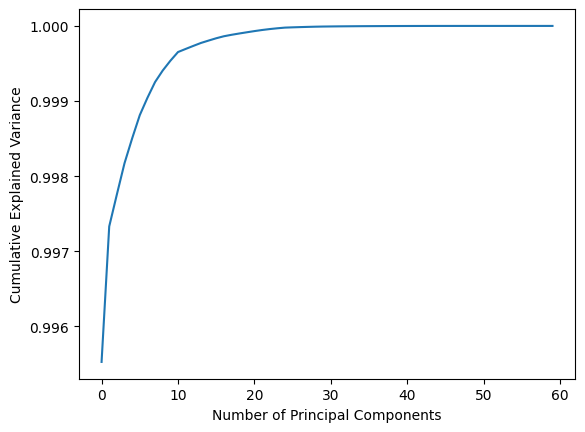

23


In [14]:
df_pca = transform_pca(df_diff)

## Predykcja

#### Regresja liniowa

In [15]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from IPython.display import clear_output

def convert(data):
    return np.asarray(data).astype('float32')

def result_test_summary(y_test, y_pred):
    msle = tf.keras.metrics.MeanSquaredLogarithmicError()
    msle.update_state(convert(y_test), convert(y_pred))
    msle_result = msle.result().numpy()

    mape = tf.keras.metrics.MeanAbsolutePercentageError()
    mape.update_state(convert(y_test), convert(y_pred))
    mape_result = mape.result().numpy()

    mse = tf.keras.metrics.MeanSquaredError()
    mse.update_state(convert(y_test), convert(y_pred))
    mse_result = mse.result().numpy()

    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(convert(y_test), convert(y_pred))
    mae_result = mae.result().numpy()

    print(f"For test dataset: \nmae = {mae_result},\n mse = {mse_result}, \n msle = {msle_result}, \n mape = {mape_result},\n")


In [16]:
def train_regression_linear(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

  reg = LinearRegression().fit(X_train, y_train)
  y_pred = reg.predict(X_test)
  result_test_summary(y_test, y_pred)

### Sieć neuronowa

In [17]:
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output
import math

class LearningCurvesPlotter(keras.callbacks.Callback):
    """Callback to plot the learning curves for the model during training."""

    def __init__(self, start_epoch=0):
        super(LearningCurvesPlotter, self).__init__()
        self.start_epoch = start_epoch

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch >= self.start_epoch:
            for metric in logs:
                if metric in self.metrics:
                    self.metrics[metric].append(logs.get(metric))
                else:
                    self.metrics[metric] = [logs.get(metric)]

            metrics = [x for x in logs if 'val' not in x]
            num_metrics = len(metrics)
            num_cols = 2
            num_rows = math.ceil(num_metrics / num_cols)

            f, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
            clear_output(wait=True)

            # Flatten axs for easy iteration if there are multiple subplots
            if num_metrics > 1:
                axs = axs.flatten()
            else:
                axs = [axs]

            # Define y-axis labels for each metric
            y_labels = {
                'loss': 'MSE (Loss)',
                'mae': 'MAE',
                'mean_absolute_percentage_error': 'MAPE',
                'mean_squared_logarithmic_error': 'MSLE',
                'accuracy': "Accuracy"
            }

            for i, metric in enumerate(metrics):
                ax = axs[i]

                ax.plot(range(self.start_epoch + 1, epoch + 2), self.metrics[metric], label='train')
                if 'val_' + metric in self.metrics:
                    ax.plot(range(self.start_epoch + 1, epoch + 2), self.metrics['val_' + metric], label='validation')

                ax.set_xlabel("Epochs", fontsize=14)
                ax.set_ylabel(y_labels.get(metric, metric.upper()), fontsize=16)
                ax.legend(fontsize=12)
                ax.tick_params(axis='both', which='major', labelsize=14)

            # If the number of metrics is odd and greater than 1, hide the last subplot
            if num_metrics % 2 != 0 and num_metrics > 1:
                f.delaxes(axs[-1])

            plt.suptitle("Learning Curves", fontsize=18)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()


In [18]:
callbacks_list = [LearningCurvesPlotter()]

In [19]:
def train_regression_nn(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
  input_shape = (X_train.shape[1],)

  dense_nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
      tf.keras.layers.Dropout(rate=0.2),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(rate=0.2),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(rate=0.2),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(rate=0.2),
      tf.keras.layers.Dense(1)
  ])

  dense_nn_model.compile(optimizer='adam', loss = 'mse', metrics = ['mae', tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredLogarithmicError()])
  dense_nn_model.fit(np.asarray(X_train).astype('float32'), np.asarray(y_train).astype('float32'), validation_data=(np.asarray(X_val).astype('float32'), np.asarray(y_val).astype('float32')), epochs = 80, verbose=1, callbacks=callbacks_list)
  dense_nn_model.evaluate(x=np.asarray(X_test).astype('float32'), y=np.asarray(y_test).astype('float32'))
  y_pred = dense_nn_model.predict(np.asarray(X_test).astype('float32'))

  result_test_summary(y_test, y_pred)

### Experiments

In [20]:
def to_training(df):
  columns_to_exclude = ['Nazwa firmy', 'Wartość rynkowa', 'Rok', 'Sektor']
  columns_to_include = [col for col in df.columns if col not in columns_to_exclude]
  return df[columns_to_include]

def clean_anomalies(X,y):
  lof = LocalOutlierFactor(contamination=0.05)
  outlier_predictions = lof.fit_predict(X)
  X = X[outlier_predictions != -1]
  y = y[outlier_predictions != -1]
  return X,y

label_encoder = LabelEncoder()
def replace_values(x):
  if 0 <= x < 1:
      return 1
  elif -1 < x < 0:
      return -1
  else:
      return x

# Apply the function to the 'Wartość rynkowa' column
df_labels = df_diff['Wartość rynkowa'].apply(replace_values).copy().to_numpy()
df_labels_encoded = label_encoder.fit_transform(df_diff['Wartość rynkowa'] > 0)

In [21]:
X_transformed = to_training(df_transformed)

df_diff

In [22]:
X_diff = to_training(df_diff)
y_diff = df_labels.copy()

In [23]:
df_diff[df_diff['Nazwa firmy'] == 'AGROWIL'].head()

,Nazwa firmy,Sektor,AKTYWA,Aktywa trwałe,Rzeczowe aktywa trwałe,Aktywa z tytułu poszukiwania i oceny zasobów mineralnych,Wartości niematerialne i prawne,Wartość firmy,Nieruchomości inwestycyjne,Aktywa z tytułu prawa do użytkowania,...,Zobowiązania z tytułu obligacji,Zobowiązania z tytułu leasingu,Zobowiązania handlowe,Świadczenia pracownicze,Zobowiązania z tytułu bieżącego podatku,Rezerwy,Pozostałe zobowiązania,Rozliczenia międzyokresowe (zobowiązania),Wartość rynkowa,Rok


#### TEST

In [24]:
X_pca = df_pca
y_pca = df_labels.copy()
X_pca_no_anomalies, y_pca_no_anomalies = clean_anomalies(X_pca,y_pca)

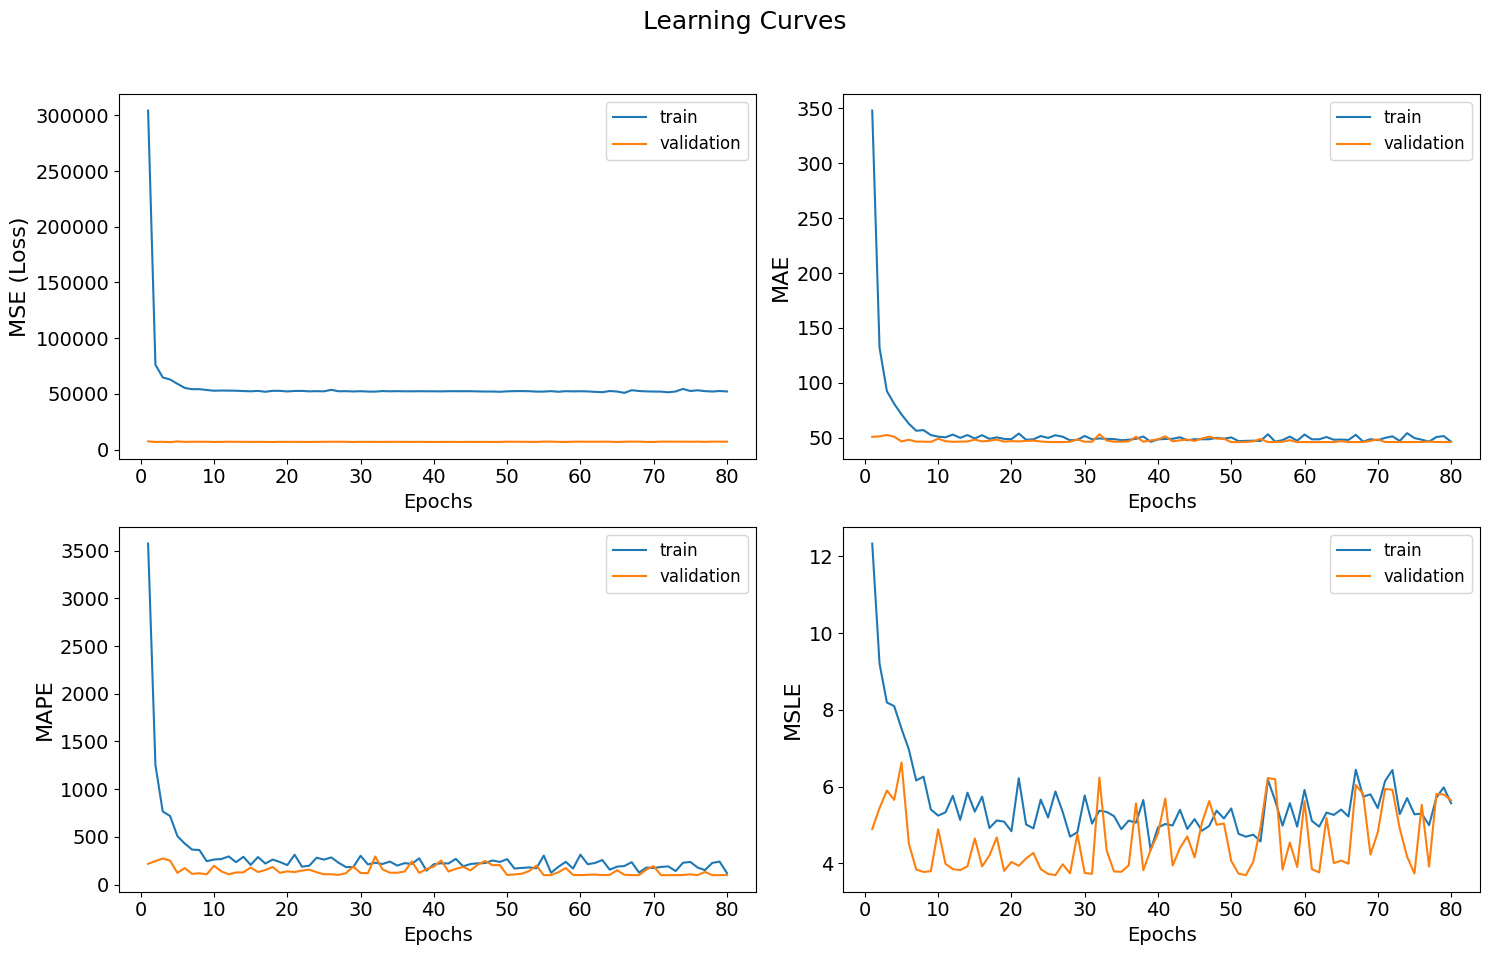

12/12 [==============================] - 0s 2ms/step
For test dataset: 
mae = 52.493003845214844,
 mse = 52492.46875, 
 msle = 5.535351276397705, 
 mape = 99.92853546142578,



In [ ]:
train_regression_nn(X_pca_no_anomalies,y_pca_no_anomalies)

#### Others

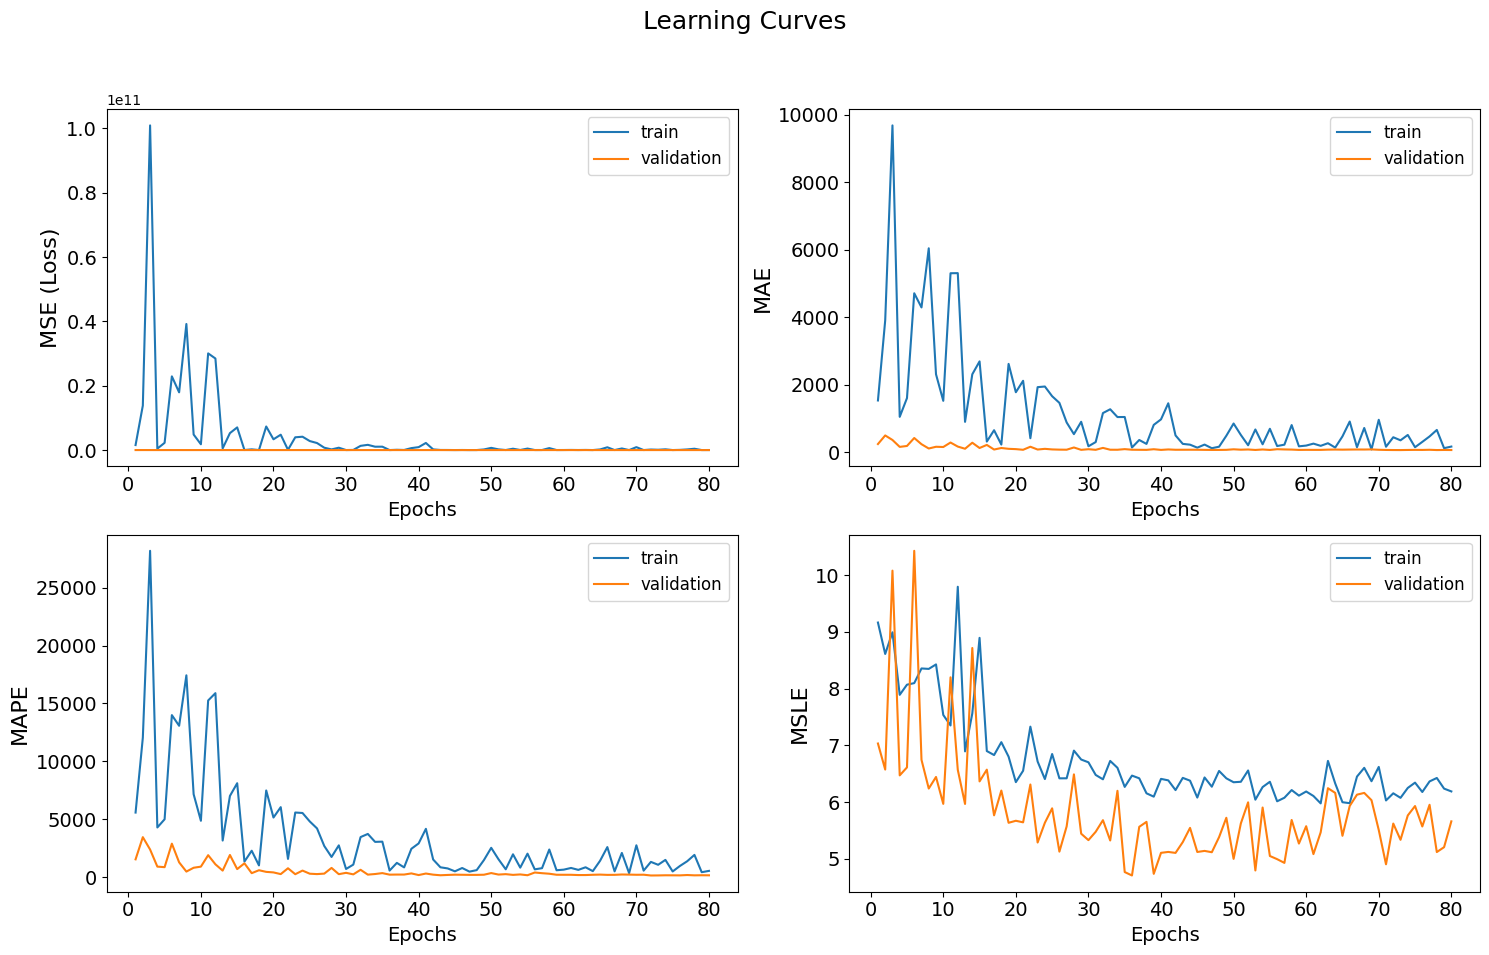

12/12 [==============================] - 0s 3ms/step
For test dataset: 
mae = 49.46161651611328,
 mse = 15980.8857421875, 
 msle = 5.938884258270264, 
 mape = 188.7821044921875,



In [ ]:
train_regression_nn(X_diff,y_diff)

In [ ]:
train_regression_linear(X_diff,y_diff)

For test dataset: 
mae = 75.2228012084961,
 mse = 58214.69140625, 
 msle = 5.346752643585205, 
 mape = 392.38897705078125,



df_diff_no_anomalies

In [ ]:
X_diff = to_training(df_diff)
y_diff = df_labels.copy()
X_diff_no_anomalies, y_diff_no_anomalies = clean_anomalies(X_diff,y_diff)

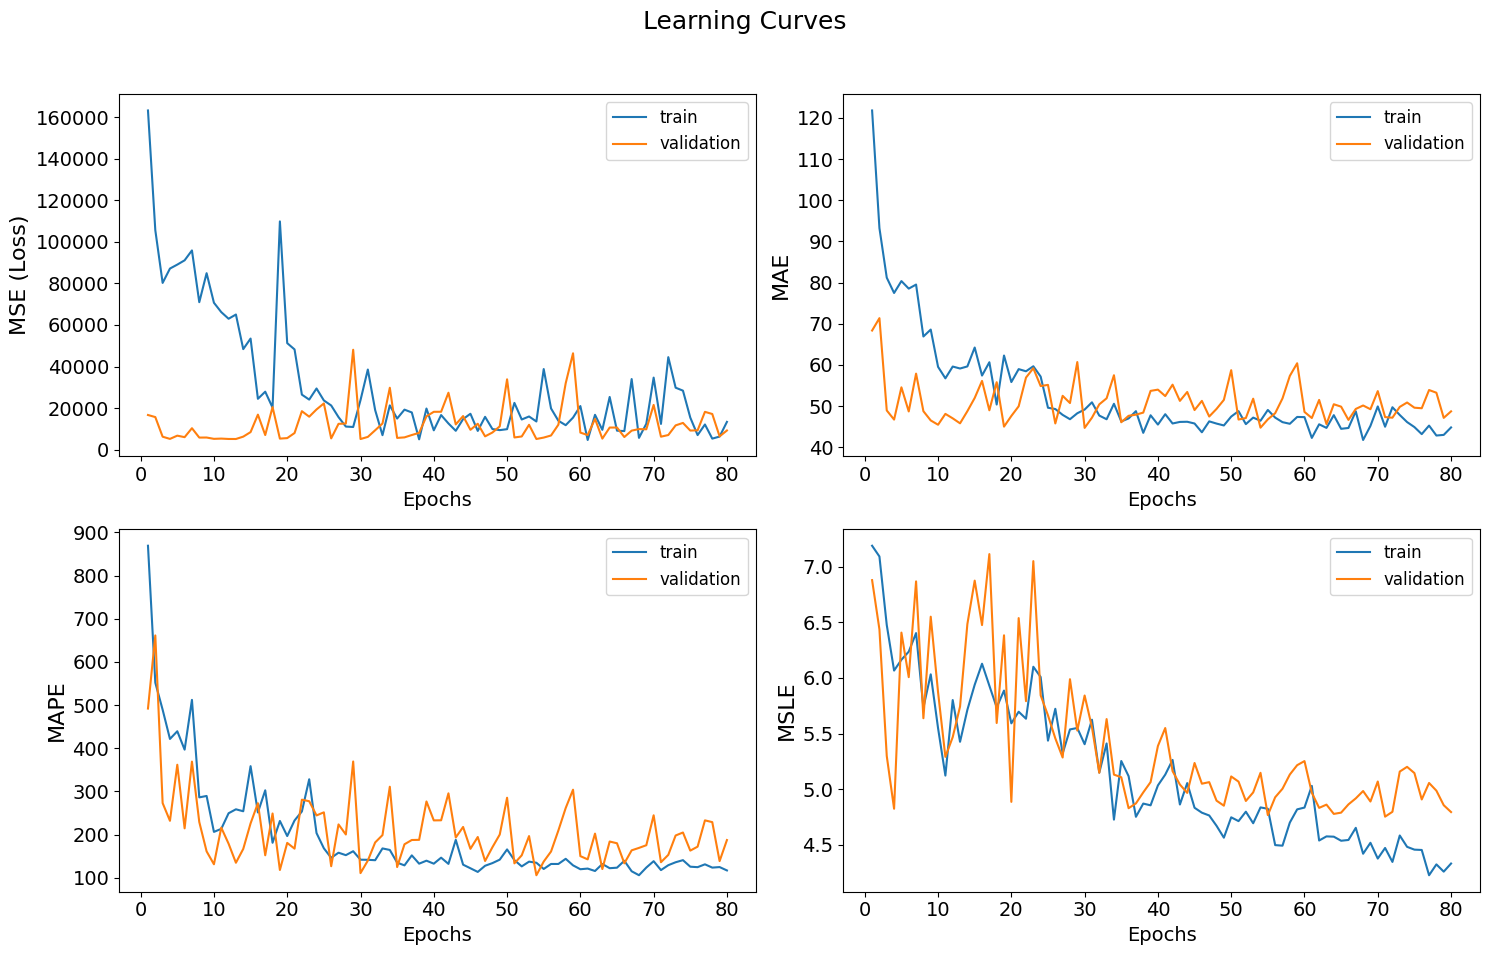

12/12 [==============================] - 0s 2ms/step
For test dataset: 
mae = 42.62085723876953,
 mse = 5921.04541015625, 
 msle = 4.341864585876465, 
 mape = 138.70838928222656,



In [ ]:
train_regression_nn(X_diff_no_anomalies,y_diff_no_anomalies)

In [ ]:
train_regression_linear(X_diff_no_anomalies,y_diff_no_anomalies)

For test dataset: 
mae = 117.62857055664062,
 mse = 306521.875, 
 msle = 6.904773712158203, 
 mape = 893.83935546875,



df_pca

In [ ]:
X_pca = df_pca
y_pca = df_labels.copy()

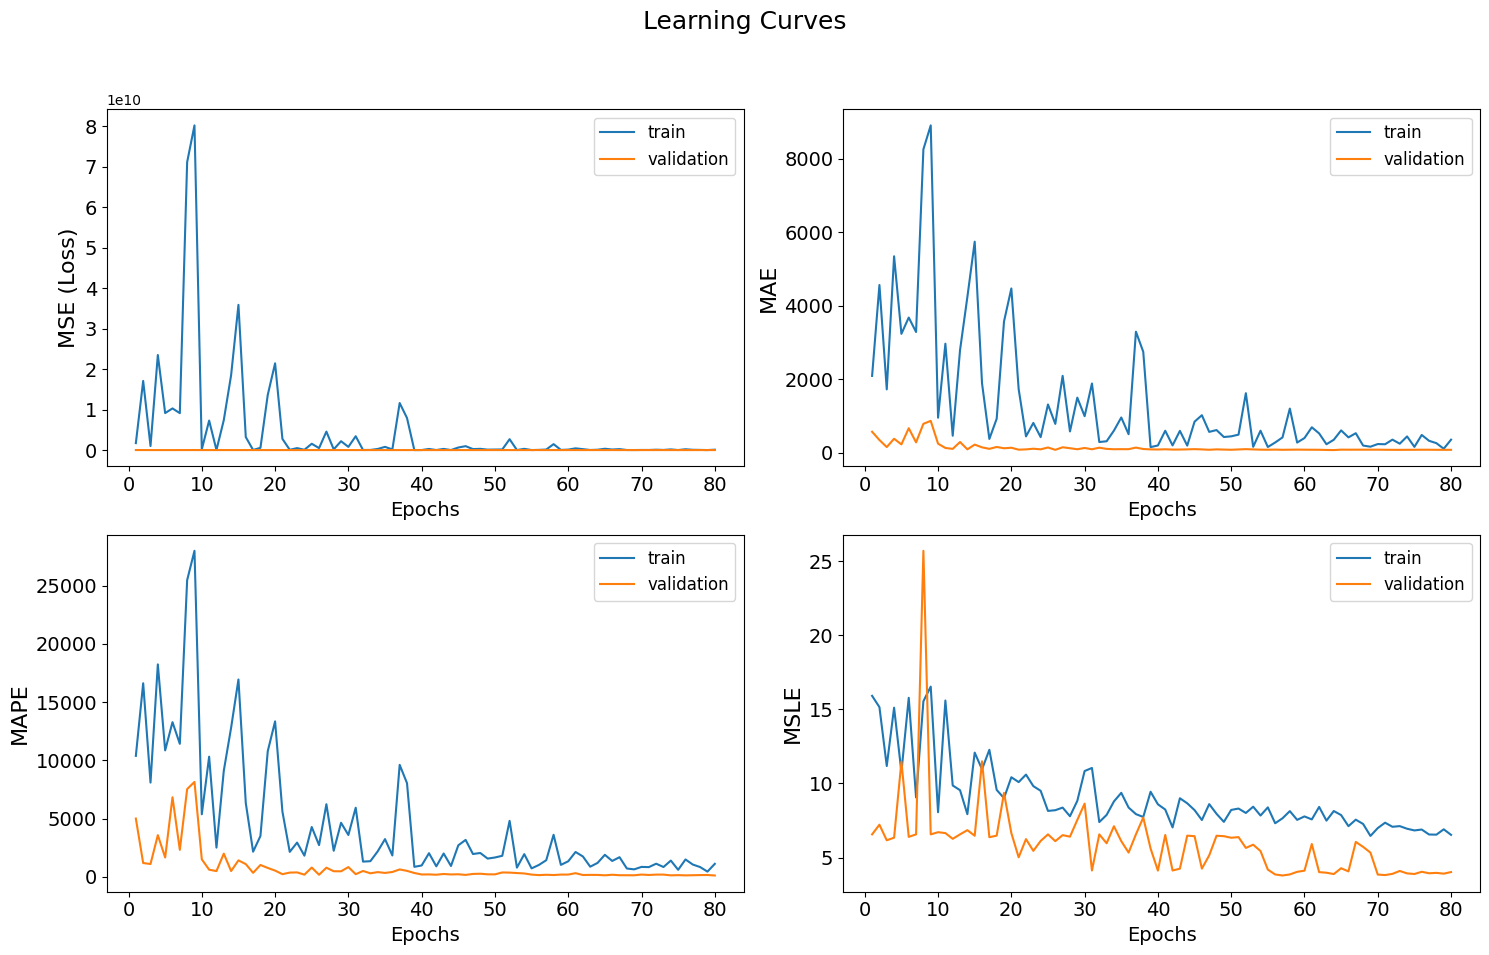

12/12 [==============================] - 0s 2ms/step
For test dataset: 
mae = 50.98568344116211,
 mse = 19491.255859375, 
 msle = 4.181337833404541, 
 mape = 241.95094299316406,



In [ ]:
train_regression_nn(X_pca,y_pca)

In [ ]:
train_regression_linear(X_pca,y_pca)

For test dataset: 
mae = 52.71577835083008,
 mse = 19313.97265625, 
 msle = 5.472799301147461, 
 mape = 276.12554931640625,



df_pca_no_anomalies

In [ ]:
X_pca = df_pca
y_pca = df_labels.copy()
X_pca_no_anomalies, y_pca_no_anomalies = clean_anomalies(X_pca,y_pca)

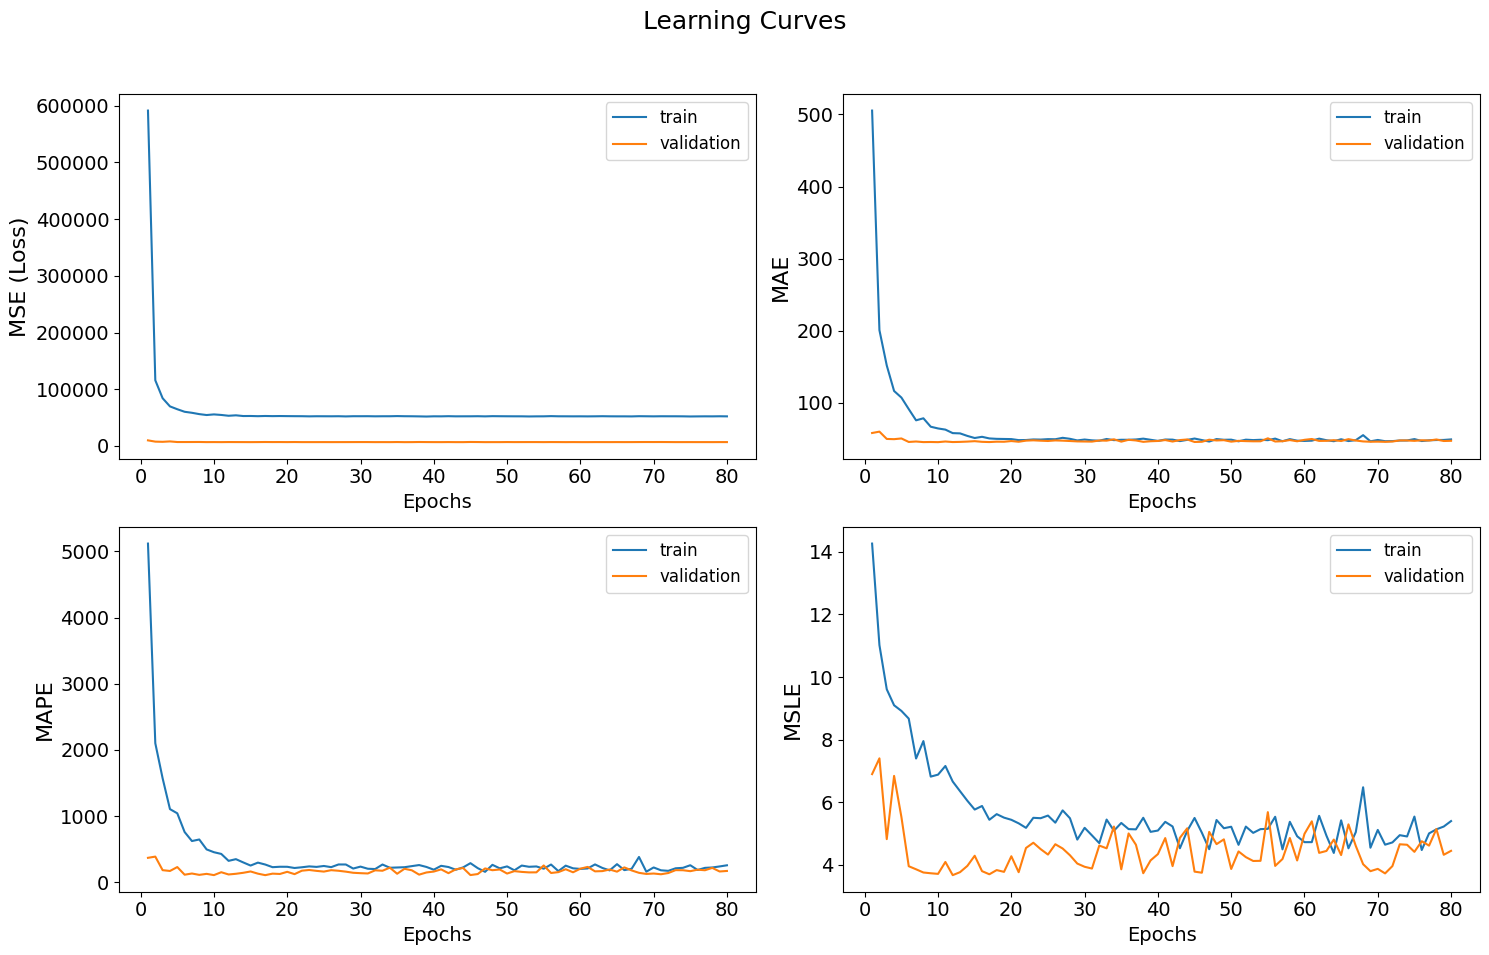

12/12 [==============================] - 0s 2ms/step
For test dataset: 
mae = 54.13640213012695,
 mse = 52187.8671875, 
 msle = 4.514533042907715, 
 mape = 171.9388427734375,



In [ ]:
train_regression_nn(X_pca_no_anomalies,y_pca_no_anomalies)

In [ ]:
train_regression_linear(X_pca_no_anomalies,y_pca_no_anomalies)

For test dataset: 
mae = 57.09683609008789,
 mse = 54390.78515625, 
 msle = 5.1754889488220215, 
 mape = 222.73635864257812,



### Modele klasyfikacyjne

In [ ]:
y = df_labels_encoded
num_ones = np.sum(y == 1)
num_zeros = np.sum(y == 0)
X = X_transformed
columns_to_exclude = ['Nazwa firmy', 'Wartość rynkowa', 'Rok', 'Sektor']
#columns_to_include = [col for col in X.columns if col not in columns_to_exclude]
#X = X[columns_to_include]
y_with_anomalies =y
print("Number of ones:", num_ones)
print("Number of zeros:", num_zeros)

Number of ones: 994
Number of zeros: 882


In [ ]:
trainX_with_anomalies, testX_with_anomalies, trainy_with_anomalies, testy_with_anomalies = train_test_split(X, y, test_size=0.2, random_state=42)
testX_with_anomalies, valX_with_anomalies, testy_with_anomalies, valy_with_anomalies = train_test_split(testX_with_anomalies, testy_with_anomalies, test_size=0.2, random_state=42)
trainy_with_anomalies, testy_with_anomalies, valy_with_anomalies = np.asarray(trainy_with_anomalies).astype('int32'), np.asarray(testy_with_anomalies).astype('int32'), np.asarray(valy_with_anomalies).astype('int32')

In [ ]:
# Create an instance of LOF
lof = LocalOutlierFactor(contamination=0.05)

# Fit the model and predict outliers
outlier_predictions = lof.fit_predict(X)

# Filter out the outliers
X = X[outlier_predictions != -1]
y = y[outlier_predictions != -1]
print(X.shape)

(1782, 60)


In [ ]:
from sklearn.svm import SVC

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=42)
testX, valX, testy, valy = train_test_split(testX, testy, test_size=0.2, random_state=42)
trainy, testy, valy = np.asarray(trainy).astype('int32'), np.asarray(testy).astype('int32'), np.asarray(valy).astype('int32')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression: Mean ROC AUC = 0.582 +/- 0.026
SVC: Mean ROC AUC = 0.556 +/- 0.024
Decision Tree: Mean ROC AUC = 0.574 +/- 0.022
KNN: Mean ROC AUC = 0.569 +/- 0.041


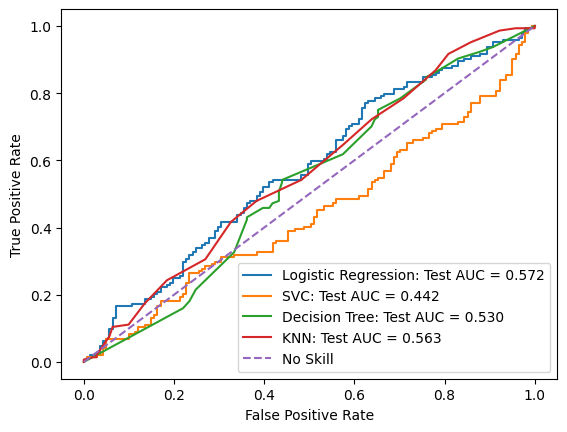

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

# Define the models
models = {
    'Logistic Regression': LogisticRegression(solver='lbfgs'),
    'SVC': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier()
}

# Define the parameter grids for each model
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10, 100]},
    'SVC': {'C': [0.1, 1, 1,0, 100], 'class_weight': [None, 'balanced']},
    'Decision Tree': {'max_depth': [None, 10, 20, 50], 'min_samples_split': [2, 5, 10], 'class_weight': [None, 'balanced']},
    'KNN': {'n_neighbors': [5, 10, 20, 50]}
}

# Perform grid search and select the best model for each classifier
best_models = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5)
    grid_search.fit(trainX, trainy)
    best_models[name] = grid_search.best_estimator_

# Evaluate each best model using cross-validation
for name, model in best_models.items():
    # Perform cross-validation
    scores = cross_val_score(model, trainX if name=='Decision Tree' else trainX_with_anomalies, trainy if name=='Decision Tree' else trainy_with_anomalies, cv=5, scoring='roc_auc')
    mean_auc = scores.mean()
    std_auc = scores.std()
    print(f'{name}: Mean ROC AUC = {mean_auc:.3f} +/- {std_auc:.3f}')

    # Fit the model on the full training data
    model.fit(trainX, trainy)

    # Predict probabilities on the test set
    probs = model.predict_proba(testX)[:, 1]
    # Calculate ROC AUC score on the test set
    auc = roc_auc_score(testy, probs)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(testy, probs)
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name}: Test AUC = {auc:.3f}')

# Plot No Skill ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend()
# Show plot
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

def model_scores(y_true, y_pred, title):
    print(title)
    print(f"accuracy  = {accuracy_score(y_true, y_pred)}")
    print(f"f1        = {f1_score(y_true, y_pred)}")
    print(f"precision = {precision_score(y_true, y_pred)}")
    print(f"recall    = {recall_score(y_true, y_pred)}")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Lossing', 'Growing'])
    cm_display.plot()
    plt.show()

Deep NN
accuracy  = 0.6078431372549019
f1        = 0.5833333333333333
precision = 0.5730994152046783
recall    = 0.593939393939394


<Figure size 640x480 with 0 Axes>

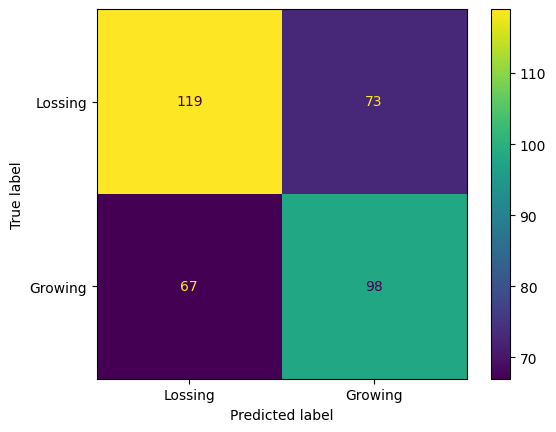

In [ ]:
# Given counts
counts = {'true_0_pred_0': 119, 'true_1_pred_0': 67, 'true_0_pred_1': 73, 'true_1_pred_1': 98}

# Generate true labels and predicted labels
true_labels = np.concatenate([
    np.zeros(counts['true_0_pred_0'] + counts['true_0_pred_1']),  # 0s for true_0_pred_0 and true_0_pred_1
    np.ones(counts['true_1_pred_0'] + counts['true_1_pred_1'])    # 1s for true_1_pred_0 and true_1_pred_1
])

predicted_labels = np.concatenate([
    np.zeros(counts['true_0_pred_0']),    # 0s for true_0_pred_0
    np.ones(counts['true_0_pred_1']),     # 1s for true_1_pred_0
    np.ones(counts['true_1_pred_1']),     # 1s for true_0_pred_1
    np.zeros(counts['true_1_pred_0'])      # 1s for true_1_pred_1
])

model_scores(true_labels,predicted_labels,"Deep NN")

Logistic Regression
accuracy  = 0.5684210526315789
f1        = 0.64756446991404
precision = 0.551219512195122
recall    = 0.7847222222222222


<Figure size 640x480 with 0 Axes>

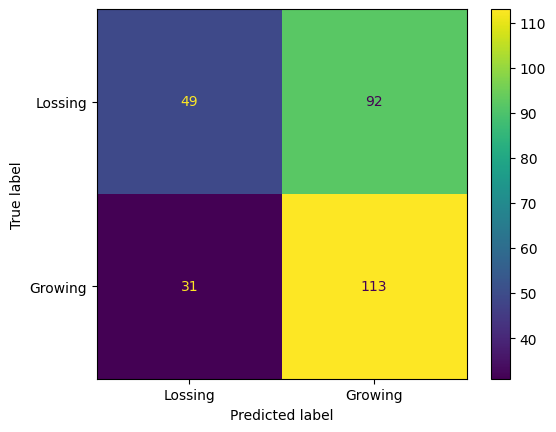

SVC
accuracy  = 0.5052631578947369
f1        = 0.6713286713286714
precision = 0.5052631578947369
recall    = 1.0


<Figure size 640x480 with 0 Axes>

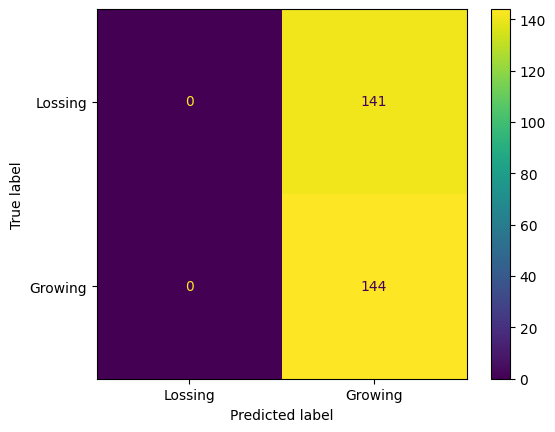

Decision Tree
accuracy  = 0.5473684210526316
f1        = 0.5441696113074205
precision = 0.5539568345323741
recall    = 0.5347222222222222


<Figure size 640x480 with 0 Axes>

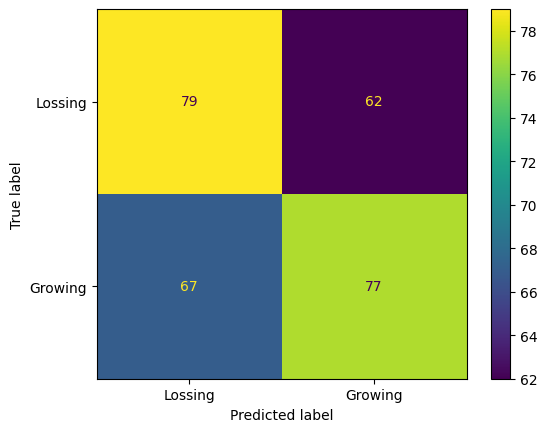

KNN
accuracy  = 0.5298245614035088
f1        = 0.5379310344827586
precision = 0.5342465753424658
recall    = 0.5416666666666666


<Figure size 640x480 with 0 Axes>

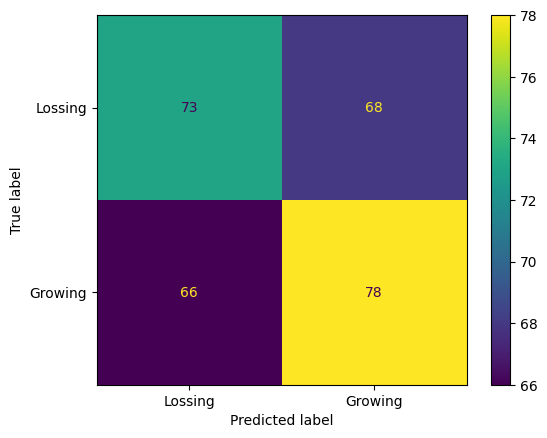

In [ ]:
for name, model in best_models.items():
    model_scores(testy, model.predict(testX), name)

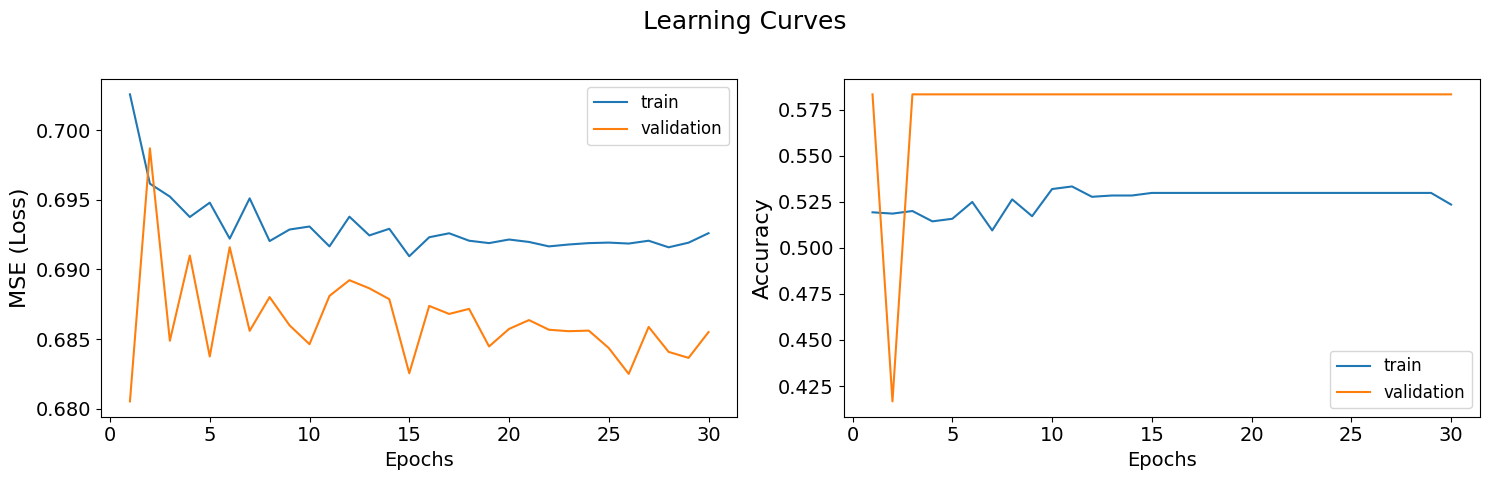

9/9 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5053
Test Loss: 0.6940
Test Accuracy: 0.5053
1/1 [==============================] - 0s 90ms/step
Neural network
accuracy  = 0.5052631578947369
f1        = 0.6713286713286714
precision = 0.5052631578947369
recall    = 1.0


<Figure size 640x480 with 0 Axes>

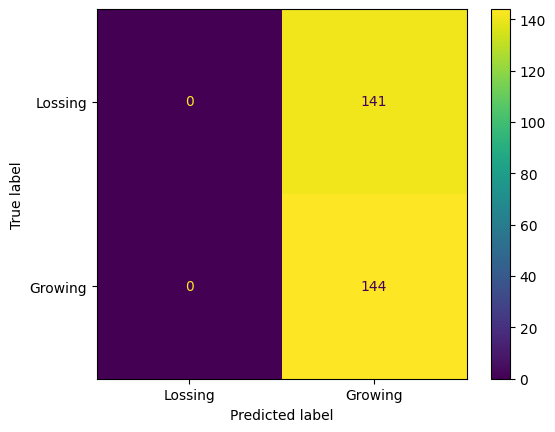

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight

# Compute class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(trainy), y=trainy)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
model.fit(np.asarray(trainX).astype('float32'), np.asarray(trainy).astype('float32'),
          validation_data=(np.asarray(valX).astype('float32'), np.asarray(valy).astype('float32')),
          epochs=30, verbose=1, callbacks=callbacks_list)


# Evaluate the model
loss, accuracy = model.evaluate(x=np.asarray(testX).astype('float32'), y=np.asarray(testy).astype('float32'))
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Make predictions
y_pred_probs = model.predict(np.asarray(testX).astype('float32'), steps=1)
y_pred = np.round(y_pred_probs).flatten()

# Do something with predictions (not specified in the provided code)
# For example, append predictions to a list
pred = y_pred.tolist()

model_scores(testy, pred, "Neural network")

## Convolutional

In [ ]:

df_diff.head()

,Nazwa firmy,Sektor,AKTYWA,Aktywa trwałe,Rzeczowe aktywa trwałe,Aktywa z tytułu poszukiwania i oceny zasobów mineralnych,Wartości niematerialne i prawne,Wartość firmy,Nieruchomości inwestycyjne,Aktywa z tytułu prawa do użytkowania,...,Zobowiązania z tytułu obligacji,Zobowiązania z tytułu leasingu,Zobowiązania handlowe,Świadczenia pracownicze,Zobowiązania z tytułu bieżącego podatku,Rezerwy,Pozostałe zobowiązania,Rozliczenia międzyokresowe (zobowiązania),Wartość rynkowa,Rok
0,AMREST,hotele i restauracje,4.799722,-2.943336,13.624378,0.0,5.557478,-8.313724,0.000000,0.0,...,0.0,0.0,-25.786717,0.0,-98.984772,0.0,0.0,0.0,70.831926,2009
1,AMREST,hotele i restauracje,18.926674,13.386380,17.299360,0.0,27.312265,2.851543,100.000000,0.0,...,0.0,0.0,7.639823,0.0,47625.000000,0.0,0.0,0.0,38.350182,2010
2,AMREST,hotele i restauracje,91.516400,125.335868,50.880058,0.0,866.805143,146.243527,3.583994,0.0,...,0.0,0.0,44.807501,0.0,121.162913,0.0,0.0,0.0,-15.639990,2011
3,AMREST,hotele i restauracje,-2.872780,-6.618637,0.828062,0.0,-7.299629,-15.416531,0.321543,0.0,...,0.0,0.0,2.473877,0.0,283.917575,0.0,0.0,0.0,50.312663,2012
4,AMREST,hotele i restauracje,3.337414,1.821283,4.630131,0.0,-0.450121,-1.578266,-0.000000,0.0,...,0.0,0.0,4.834548,0.0,-30.779197,0.0,0.0,0.0,-6.445085,2013


In [ ]:
#X_df = X_diff
X_df = X_transformed

In [ ]:
def generate_ratios(data):
    ratios = pd.DataFrame(index=data.index)
    ratio_columns = []

    for col1, col2 in itertools.combinations(data.columns, 2):
        ratio_name = f'{col1}_{col2}_ratio'
        ratio_columns.append(data[col1] / data[col2])

    ratios = pd.concat(ratio_columns, axis=1)
    ratios.columns = [f'{col1}_{col2}_ratio' for col1, col2 in itertools.combinations(data.columns, 2)]

    return ratios

ratios = generate_ratios(X_df)

In [ ]:
ratios.head()

,AKTYWA_Aktywa trwałe_ratio,AKTYWA_Rzeczowe aktywa trwałe_ratio,AKTYWA_Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_ratio,AKTYWA_Wartości niematerialne i prawne_ratio,AKTYWA_Wartość firmy_ratio,AKTYWA_Nieruchomości inwestycyjne_ratio,AKTYWA_Aktywa z tytułu prawa do użytkowania_ratio,AKTYWA_Inwestycje w jednostki powiązane_ratio,AKTYWA_Długoterminowe aktywa finansowe_ratio,AKTYWA_Długoterminowe pożyczki i należności_ratio,...,Świadczenia pracownicze_Zobowiązania z tytułu bieżącego podatku_ratio,Świadczenia pracownicze_Rezerwy_ratio,Świadczenia pracownicze_Pozostałe zobowiązania_ratio,Świadczenia pracownicze_Rozliczenia międzyokresowe (zobowiązania)_ratio,Zobowiązania z tytułu bieżącego podatku_Rezerwy_ratio,Zobowiązania z tytułu bieżącego podatku_Pozostałe zobowiązania_ratio,Zobowiązania z tytułu bieżącego podatku_Rozliczenia międzyokresowe (zobowiązania)_ratio,Rezerwy_Pozostałe zobowiązania_ratio,Rezerwy_Rozliczenia międzyokresowe (zobowiązania)_ratio,Pozostałe zobowiązania_Rozliczenia międzyokresowe (zobowiązania)_ratio
0,1.006597,0.949462,0.953741,0.949902,0.948608,0.948650,0.956563,0.957261,0.949449,0.950175,...,0.994517,1.255707,0.994517,1.000305,1.262630,1.000000,1.005820,0.791998,0.796607,1.005821
1,1.009550,0.942357,0.946571,0.943060,0.941496,0.941723,0.949372,0.951066,0.941314,0.941864,...,1.239516,1.255707,0.994517,1.000305,1.013063,0.802343,0.807013,0.791998,0.796607,1.005821
2,1.045746,0.905967,0.909730,0.917574,0.905096,0.904881,0.912422,0.914483,0.905157,0.905234,...,0.995425,1.255707,0.994517,1.000305,1.261478,0.999088,1.004903,0.791998,0.796607,1.005821
3,1.008342,0.953223,0.957635,0.953602,0.952468,0.952524,0.960468,0.965388,0.952821,0.952774,...,0.996097,1.255707,0.994517,1.000305,1.260627,0.998414,1.004225,0.791998,0.796607,1.005821
4,1.010453,0.950120,0.954483,0.950558,0.949358,0.949389,0.957307,0.958998,0.949685,0.949182,...,0.994798,1.255707,0.994517,1.000305,1.262273,0.999717,1.005536,0.791998,0.796607,1.005821


In [ ]:
def rescale_to_positive(df):
    # Apply Min-Max scaling to ensure all values are between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))  # Set the range to start from 0.1 to ensure strictly greater than 0
    scaled_data = scaler.fit_transform(df)

    # Convert the scaled data back to a dataframe with the original column names
    rescaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
    return rescaled_df

In [ ]:
X_df.corr().head()

,AKTYWA,Aktywa trwałe,Rzeczowe aktywa trwałe,Aktywa z tytułu poszukiwania i oceny zasobów mineralnych,Wartości niematerialne i prawne,Wartość firmy,Nieruchomości inwestycyjne,Aktywa z tytułu prawa do użytkowania,Inwestycje w jednostki powiązane,Długoterminowe aktywa finansowe,...,Zobowiązania z tytułu instrumentów pochodnych,Zobowiązania finansowe (kredyty i pożyczki),Zobowiązania z tytułu obligacji,Zobowiązania z tytułu leasingu,Zobowiązania handlowe,Świadczenia pracownicze,Zobowiązania z tytułu bieżącego podatku,Rezerwy,Pozostałe zobowiązania,Rozliczenia międzyokresowe (zobowiązania)
AKTYWA,1.000000,0.622226,0.011144,-0.002647,0.097966,0.010532,0.006980,0.000909,0.011040,-0.009967,...,0.000488,0.046643,-0.001602,0.003810,0.908973,0.009778,0.002266,0.034289,0.011287,0.080939
Aktywa trwałe,0.622226,1.000000,0.006297,-0.003624,0.136087,0.010061,0.004359,0.003911,0.023454,-0.008894,...,-0.004643,0.055394,-0.004058,0.000715,0.494607,0.014499,0.004556,0.025597,0.358626,0.089576
Rzeczowe aktywa trwałe,0.011144,0.006297,1.000000,-0.000638,0.025822,0.001279,-0.000975,-0.000886,-0.001788,-0.001857,...,-0.001535,-0.000649,-0.000776,-0.000772,0.002602,-0.001338,-0.001351,0.000828,-0.000234,-0.001186
Aktywa z tytułu poszukiwania i oceny zasobów mineralnych,-0.002647,-0.003624,-0.000638,1.000000,-0.001705,-0.000593,-0.000562,-0.002000,-0.000840,-0.001532,...,-0.001499,-0.001252,-0.000690,-0.000646,-0.001292,-0.001551,-0.001273,-0.003409,-0.000537,-0.003099
Wartości niematerialne i prawne,0.097966,0.136087,0.025822,-0.001705,1.000000,-0.000444,-0.001825,-0.002422,-0.001526,-0.004539,...,-0.004883,0.021677,-0.001507,-0.001832,0.060895,0.051802,-0.000296,0.031286,0.008500,-0.006431


In [ ]:
def simulated_annealing(data, initial_temperature = 2000, cooling_rate=0.99, lowest_temperature =0.1):
    correlation_matrix = rescale_to_positive(data.corr())

    financial_ratios = list(data.columns)
    N = len(financial_ratios)
    sqrt_N = int(np.ceil(np.sqrt(N)))
    pixels = [(x, y) for x in range(sqrt_N) for y in range(sqrt_N)]

    def energy_function(correlation_matrix, pixels):
      energy = 0
      for v1 in range(len(financial_ratios)):
          for v2 in range(v1,len(financial_ratios)):
              if v1 != v2:
                  corr = correlation_matrix.at[financial_ratios[v1], financial_ratios[v2]]
                  pixel1, pixel2 = pixels[v1], pixels[v2]
                  distance = (pixel1[0] - pixel2[0]) ** 2 + (pixel1[1] - pixel2[1]) ** 2
                  energy_ij = np.abs(corr) * distance
                  if not np.isnan(energy_ij):
                    energy += energy_ij
      return energy

    def update_energy(correlation_matrix, pixels, old_energy, v1, v2):
      pixel_v1, pixel_v2 = pixels[v1], pixels[v2]
      for i in range(len(financial_ratios)):
        pixel_i = pixels[i]
        corr_v1_i = np.abs(correlation_matrix.at[financial_ratios[v1], financial_ratios[i]])
        corr_v2_i = np.abs(correlation_matrix.at[financial_ratios[v2], financial_ratios[i]])

        distance_v1_i_before = (pixel_v1[0] - pixel_i[0]) ** 2 + (pixel_v1[1] - pixel_i[1]) ** 2
        distance_v2_i_before = (pixel_v2[0] - pixel_i[0]) ** 2 + (pixel_v2[1] - pixel_i[1]) ** 2

        old_energy -= 0 if np.isnan(corr_v1_i) else corr_v1_i*distance_v1_i_before
        old_energy -= 0 if np.isnan(corr_v2_i) else corr_v2_i*distance_v2_i_before

        old_energy += 0 if np.isnan(corr_v1_i) else corr_v1_i*distance_v2_i_before
        old_energy += 0 if np.isnan(corr_v2_i) else corr_v2_i*distance_v1_i_before
      return old_energy


    correlation_matrix = rescale_to_positive(data.corr())
    current_energy = energy_function(correlation_matrix, pixels)

    energies = []
    temperatures = []

    temperature = initial_temperature
    while temperature > lowest_temperature:
        v1,v2 = random.sample(range(len(financial_ratios)), 2)
        pixel1, pixel2 = pixels[v1], pixels[v2]

        new_energy = update_energy(correlation_matrix, pixels, current_energy,v1,v2)
        #print(f'{temperature}, {current_energy}, {new_energy}')
        print(f'{temperature}')

        new_pixels = pixels.copy()
        new_pixels[v1], new_pixels[v2] = pixel2, pixel1


        energies.append(current_energy)
        temperatures.append(temperature)

        if new_energy < current_energy:
            pixels = new_pixels
            current_energy = new_energy
            print("YYYYYYYYYY")
        else:
            acceptance_probability = math.exp(-(new_energy - current_energy) / temperature)
            #print(temperature,acceptance_probability)
            if random.random() < acceptance_probability:

              print("XXXXXXXXXX")
              pixels = new_pixels
              current_energy = new_energy

        temperature *= cooling_rate

    plt.plot(energies)
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.title('Energy Change during Simulated Annealing')
    plt.show()
    pixel_mapping = {financial_ratios[i]: pixels[i] for i in range(len(financial_ratios))}
    return pixel_mapping

In [ ]:
pixel_mapping_param = simulated_annealing(X_df,1,0.9999,0.1)
print(pixel_mapping_param)

In [ ]:
#pixel_mapping_ratios = simulated_annealing(generate_ratios(X_transformed),100,0.99999,20)
#print(pixel_mapping_ratios)

### Annealing results

In [ ]:
pixel_mapping_ratios_diff = {'AKTYWA_Aktywa trwałe_ratio': (10, 24), 'AKTYWA_Rzeczowe aktywa trwałe_ratio': (20, 17), 'AKTYWA_Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_ratio': (33, 1), 'AKTYWA_Wartości niematerialne i prawne_ratio': (24, 16), 'AKTYWA_Wartość firmy_ratio': (32, 23), 'AKTYWA_Nieruchomości inwestycyjne_ratio': (23, 31), 'AKTYWA_Aktywa z tytułu prawa do użytkowania_ratio': (6, 41), 'AKTYWA_Inwestycje w jednostki powiązane_ratio': (29, 28), 'AKTYWA_Długoterminowe aktywa finansowe_ratio': (27, 23), 'AKTYWA_Długoterminowe pożyczki i należności_ratio': (4, 24), 'AKTYWA_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (24, 10), 'AKTYWA_Długoterminowe rozliczenia międzyokresowe_ratio': (40, 13), 'AKTYWA_Długoterminowe instrumenty pochodne_ratio': (36, 40), 'AKTYWA_Pozostałe aktywa długoterminowe_ratio': (19, 33), 'AKTYWA_Aktywa obrotowe_ratio': (18, 25), 'AKTYWA_Zapasy_ratio': (3, 16), 'AKTYWA_Aktywa niematerialne_ratio': (38, 41), 'AKTYWA_Aktywa biologiczne_ratio': (1, 4), 'AKTYWA_Należności handlowe_ratio': (10, 14), 'AKTYWA_Pożyczki i pozostałe należności_ratio': (32, 18), 'AKTYWA_Aktywa finansowe_ratio': (13, 2), 'AKTYWA_Środki pieniężne i ich ekwiwalenty_ratio': (13, 8), 'AKTYWA_Rozliczenia międzyokresowe_ratio': (32, 11), 'AKTYWA_Aktywa z tytułu bieżącego podatku_ratio': (23, 7), 'AKTYWA_Instrumenty pochodne_ratio': (38, 29), 'AKTYWA_Pozostałe aktywa_ratio': (23, 35), 'AKTYWA_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (23, 33), 'AKTYWA_PASYWA_ratio': (0, 11), 'AKTYWA_Kapitał własny udziałowców podmiotu dominującego_ratio': (23, 16), 'AKTYWA_Kapitał podstawowy_ratio': (31, 29), 'AKTYWA_Należne wpłaty na kapitał podstawowy_ratio': (38, 1), 'AKTYWA_Akcje/udziały własne_ratio': (2, 38), 'AKTYWA_Kapitał zapasowy_ratio': (31, 20), 'AKTYWA_Wyceny i różnice kursowe_ratio': (9, 25), 'AKTYWA_Pozostałe kapitały_ratio': (11, 18), 'AKTYWA_Zyski zatrzymane / niepokryte straty_ratio': (9, 12), 'AKTYWA_Udziały niekontrolujące_ratio': (31, 19), 'AKTYWA_Zobowiązania długoterminowe_ratio': (2, 15), 'AKTYWA_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (33, 34), 'AKTYWA_Długoterminowe kredyty i pożyczki_ratio': (7, 15), 'AKTYWA_Długoterminowe zobowiązania z tytułu obligacji_ratio': (18, 42), 'AKTYWA_Długoterminowe zobowiązania z tytułu leasingu_ratio': (9, 37), 'AKTYWA_Długoterminowe zobowiązania handlowe_ratio': (35, 27), 'AKTYWA_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (31, 26), 'AKTYWA_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (14, 14), 'AKTYWA_Długoterminowe rezerwy_ratio': (35, 13), 'AKTYWA_Pozostałe zobowiązania długoterminowe_ratio': (15, 12), 'AKTYWA_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (26, 1), 'AKTYWA_Zobowiązania krótkoterminowe_ratio': (8, 13), 'AKTYWA_Zobowiązania z tytułu instrumentów pochodnych_ratio': (37, 31), 'AKTYWA_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (14, 18), 'AKTYWA_Zobowiązania z tytułu obligacji_ratio': (26, 40), 'AKTYWA_Zobowiązania z tytułu leasingu_ratio': (2, 36), 'AKTYWA_Zobowiązania handlowe_ratio': (17, 15), 'AKTYWA_Świadczenia pracownicze_ratio': (12, 2), 'AKTYWA_Zobowiązania z tytułu bieżącego podatku_ratio': (22, 27), 'AKTYWA_Rezerwy_ratio': (20, 6), 'AKTYWA_Pozostałe zobowiązania_ratio': (22, 18), 'AKTYWA_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 6), 'Aktywa trwałe_Rzeczowe aktywa trwałe_ratio': (23, 8), 'Aktywa trwałe_Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_ratio': (36, 3), 'Aktywa trwałe_Wartości niematerialne i prawne_ratio': (25, 15), 'Aktywa trwałe_Wartość firmy_ratio': (29, 31), 'Aktywa trwałe_Nieruchomości inwestycyjne_ratio': (25, 32), 'Aktywa trwałe_Aktywa z tytułu prawa do użytkowania_ratio': (7, 40), 'Aktywa trwałe_Inwestycje w jednostki powiązane_ratio': (27, 28), 'Aktywa trwałe_Długoterminowe aktywa finansowe_ratio': (30, 19), 'Aktywa trwałe_Długoterminowe pożyczki i należności_ratio': (4, 23), 'Aktywa trwałe_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (27, 14), 'Aktywa trwałe_Długoterminowe rozliczenia międzyokresowe_ratio': (40, 17), 'Aktywa trwałe_Długoterminowe instrumenty pochodne_ratio': (36, 38), 'Aktywa trwałe_Pozostałe aktywa długoterminowe_ratio': (18, 31), 'Aktywa trwałe_Aktywa obrotowe_ratio': (16, 25), 'Aktywa trwałe_Zapasy_ratio': (6, 13), 'Aktywa trwałe_Aktywa niematerialne_ratio': (40, 37), 'Aktywa trwałe_Aktywa biologiczne_ratio': (2, 5), 'Aktywa trwałe_Należności handlowe_ratio': (5, 18), 'Aktywa trwałe_Pożyczki i pozostałe należności_ratio': (32, 17), 'Aktywa trwałe_Aktywa finansowe_ratio': (7, 6), 'Aktywa trwałe_Środki pieniężne i ich ekwiwalenty_ratio': (12, 12), 'Aktywa trwałe_Rozliczenia międzyokresowe_ratio': (31, 5), 'Aktywa trwałe_Aktywa z tytułu bieżącego podatku_ratio': (23, 6), 'Aktywa trwałe_Instrumenty pochodne_ratio': (39, 28), 'Aktywa trwałe_Pozostałe aktywa_ratio': (21, 34), 'Aktywa trwałe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (23, 30), 'Aktywa trwałe_PASYWA_ratio': (14, 11), 'Aktywa trwałe_Kapitał własny udziałowców podmiotu dominującego_ratio': (24, 17), 'Aktywa trwałe_Kapitał podstawowy_ratio': (28, 30), 'Aktywa trwałe_Należne wpłaty na kapitał podstawowy_ratio': (37, 0), 'Aktywa trwałe_Akcje/udziały własne_ratio': (0, 36), 'Aktywa trwałe_Kapitał zapasowy_ratio': (29, 24), 'Aktywa trwałe_Wyceny i różnice kursowe_ratio': (7, 26), 'Aktywa trwałe_Pozostałe kapitały_ratio': (19, 26), 'Aktywa trwałe_Zyski zatrzymane / niepokryte straty_ratio': (10, 18), 'Aktywa trwałe_Udziały niekontrolujące_ratio': (30, 17), 'Aktywa trwałe_Zobowiązania długoterminowe_ratio': (1, 18), 'Aktywa trwałe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (34, 35), 'Aktywa trwałe_Długoterminowe kredyty i pożyczki_ratio': (5, 15), 'Aktywa trwałe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (25, 42), 'Aktywa trwałe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (10, 35), 'Aktywa trwałe_Długoterminowe zobowiązania handlowe_ratio': (33, 31), 'Aktywa trwałe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (30, 29), 'Aktywa trwałe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (15, 17), 'Aktywa trwałe_Długoterminowe rezerwy_ratio': (36, 18), 'Aktywa trwałe_Pozostałe zobowiązania długoterminowe_ratio': (21, 7), 'Aktywa trwałe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (20, 1), 'Aktywa trwałe_Zobowiązania krótkoterminowe_ratio': (8, 8), 'Aktywa trwałe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 29), 'Aktywa trwałe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (14, 20), 'Aktywa trwałe_Zobowiązania z tytułu obligacji_ratio': (24, 41), 'Aktywa trwałe_Zobowiązania z tytułu leasingu_ratio': (3, 34), 'Aktywa trwałe_Zobowiązania handlowe_ratio': (15, 18), 'Aktywa trwałe_Świadczenia pracownicze_ratio': (22, 4), 'Aktywa trwałe_Zobowiązania z tytułu bieżącego podatku_ratio': (20, 26), 'Aktywa trwałe_Rezerwy_ratio': (26, 4), 'Aktywa trwałe_Pozostałe zobowiązania_ratio': (16, 23), 'Aktywa trwałe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (31, 3), 'Rzeczowe aktywa trwałe_Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_ratio': (38, 5), 'Rzeczowe aktywa trwałe_Wartości niematerialne i prawne_ratio': (24, 15), 'Rzeczowe aktywa trwałe_Wartość firmy_ratio': (28, 28), 'Rzeczowe aktywa trwałe_Nieruchomości inwestycyjne_ratio': (32, 24), 'Rzeczowe aktywa trwałe_Aktywa z tytułu prawa do użytkowania_ratio': (7, 41), 'Rzeczowe aktywa trwałe_Inwestycje w jednostki powiązane_ratio': (30, 24), 'Rzeczowe aktywa trwałe_Długoterminowe aktywa finansowe_ratio': (26, 24), 'Rzeczowe aktywa trwałe_Długoterminowe pożyczki i należności_ratio': (3, 22), 'Rzeczowe aktywa trwałe_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (31, 15), 'Rzeczowe aktywa trwałe_Długoterminowe rozliczenia międzyokresowe_ratio': (38, 20), 'Rzeczowe aktywa trwałe_Długoterminowe instrumenty pochodne_ratio': (36, 35), 'Rzeczowe aktywa trwałe_Pozostałe aktywa długoterminowe_ratio': (14, 33), 'Rzeczowe aktywa trwałe_Aktywa obrotowe_ratio': (7, 20), 'Rzeczowe aktywa trwałe_Zapasy_ratio': (9, 9), 'Rzeczowe aktywa trwałe_Aktywa niematerialne_ratio': (36, 41), 'Rzeczowe aktywa trwałe_Aktywa biologiczne_ratio': (1, 5), 'Rzeczowe aktywa trwałe_Należności handlowe_ratio': (10, 17), 'Rzeczowe aktywa trwałe_Pożyczki i pozostałe należności_ratio': (28, 26), 'Rzeczowe aktywa trwałe_Aktywa finansowe_ratio': (2, 12), 'Rzeczowe aktywa trwałe_Środki pieniężne i ich ekwiwalenty_ratio': (8, 18), 'Rzeczowe aktywa trwałe_Rozliczenia międzyokresowe_ratio': (31, 9), 'Rzeczowe aktywa trwałe_Aktywa z tytułu bieżącego podatku_ratio': (27, 11), 'Rzeczowe aktywa trwałe_Instrumenty pochodne_ratio': (37, 32), 'Rzeczowe aktywa trwałe_Pozostałe aktywa_ratio': (19, 34), 'Rzeczowe aktywa trwałe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (29, 21), 'Rzeczowe aktywa trwałe_PASYWA_ratio': (13, 12), 'Rzeczowe aktywa trwałe_Kapitał własny udziałowców podmiotu dominującego_ratio': (18, 12), 'Rzeczowe aktywa trwałe_Kapitał podstawowy_ratio': (28, 31), 'Rzeczowe aktywa trwałe_Należne wpłaty na kapitał podstawowy_ratio': (34, 0), 'Rzeczowe aktywa trwałe_Akcje/udziały własne_ratio': (2, 35), 'Rzeczowe aktywa trwałe_Kapitał zapasowy_ratio': (32, 21), 'Rzeczowe aktywa trwałe_Wyceny i różnice kursowe_ratio': (6, 18), 'Rzeczowe aktywa trwałe_Pozostałe kapitały_ratio': (18, 11), 'Rzeczowe aktywa trwałe_Zyski zatrzymane / niepokryte straty_ratio': (9, 27), 'Rzeczowe aktywa trwałe_Udziały niekontrolujące_ratio': (28, 17), 'Rzeczowe aktywa trwałe_Zobowiązania długoterminowe_ratio': (4, 7), 'Rzeczowe aktywa trwałe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (35, 34), 'Rzeczowe aktywa trwałe_Długoterminowe kredyty i pożyczki_ratio': (9, 14), 'Rzeczowe aktywa trwałe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (28, 42), 'Rzeczowe aktywa trwałe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (4, 31), 'Rzeczowe aktywa trwałe_Długoterminowe zobowiązania handlowe_ratio': (22, 37), 'Rzeczowe aktywa trwałe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (32, 26), 'Rzeczowe aktywa trwałe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (12, 15), 'Rzeczowe aktywa trwałe_Długoterminowe rezerwy_ratio': (36, 9), 'Rzeczowe aktywa trwałe_Pozostałe zobowiązania długoterminowe_ratio': (20, 33), 'Rzeczowe aktywa trwałe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (24, 5), 'Rzeczowe aktywa trwałe_Zobowiązania krótkoterminowe_ratio': (17, 16), 'Rzeczowe aktywa trwałe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 7), 'Rzeczowe aktywa trwałe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (19, 17), 'Rzeczowe aktywa trwałe_Zobowiązania z tytułu obligacji_ratio': (20, 41), 'Rzeczowe aktywa trwałe_Zobowiązania z tytułu leasingu_ratio': (3, 33), 'Rzeczowe aktywa trwałe_Zobowiązania handlowe_ratio': (12, 17), 'Rzeczowe aktywa trwałe_Świadczenia pracownicze_ratio': (31, 6), 'Rzeczowe aktywa trwałe_Zobowiązania z tytułu bieżącego podatku_ratio': (26, 25), 'Rzeczowe aktywa trwałe_Rezerwy_ratio': (25, 9), 'Rzeczowe aktywa trwałe_Pozostałe zobowiązania_ratio': (11, 24), 'Rzeczowe aktywa trwałe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (31, 2), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Wartości niematerialne i prawne_ratio': (30, 1), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Wartość firmy_ratio': (16, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Nieruchomości inwestycyjne_ratio': (24, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa z tytułu prawa do użytkowania_ratio': (0, 1), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Inwestycje w jednostki powiązane_ratio': (11, 2), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe aktywa finansowe_ratio': (34, 2), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe pożyczki i należności_ratio': (26, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (10, 2), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe rozliczenia międzyokresowe_ratio': (6, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe instrumenty pochodne_ratio': (40, 8), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Pozostałe aktywa długoterminowe_ratio': (9, 2), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa obrotowe_ratio': (5, 6), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zapasy_ratio': (7, 2), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa niematerialne_ratio': (0, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa biologiczne_ratio': (39, 41), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Należności handlowe_ratio': (2, 11), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Pożyczki i pozostałe należności_ratio': (37, 3), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa finansowe_ratio': (10, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Środki pieniężne i ich ekwiwalenty_ratio': (0, 25), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Rozliczenia międzyokresowe_ratio': (13, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa z tytułu bieżącego podatku_ratio': (30, 2), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Instrumenty pochodne_ratio': (37, 4), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Pozostałe aktywa_ratio': (29, 1), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (17, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_PASYWA_ratio': (0, 16), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Kapitał własny udziałowców podmiotu dominującego_ratio': (5, 7), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Kapitał podstawowy_ratio': (2, 4), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Należne wpłaty na kapitał podstawowy_ratio': (41, 5), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Akcje/udziały własne_ratio': (1, 2), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Kapitał zapasowy_ratio': (5, 1), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Wyceny i różnice kursowe_ratio': (7, 4), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Pozostałe kapitały_ratio': (5, 3), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zyski zatrzymane / niepokryte straty_ratio': (1, 14), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Udziały niekontrolujące_ratio': (36, 4), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania długoterminowe_ratio': (4, 8), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (38, 4), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe kredyty i pożyczki_ratio': (29, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe zobowiązania z tytułu obligacji_ratio': (40, 41), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe zobowiązania z tytułu leasingu_ratio': (6, 4), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe zobowiązania handlowe_ratio': (4, 3), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (21, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (8, 4), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe rezerwy_ratio': (4, 5), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Pozostałe zobowiązania długoterminowe_ratio': (34, 3), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (36, 2), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania krótkoterminowe_ratio': (1, 16), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 6), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (31, 1), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania z tytułu obligacji_ratio': (5, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania z tytułu leasingu_ratio': (2, 9), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania handlowe_ratio': (19, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Świadczenia pracownicze_ratio': (28, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania z tytułu bieżącego podatku_ratio': (12, 1), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Rezerwy_ratio': (3, 7), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Pozostałe zobowiązania_ratio': (17, 1), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Rozliczenia międzyokresowe (zobowiązania)_ratio': (6, 5), 'Wartości niematerialne i prawne_Wartość firmy_ratio': (12, 32), 'Wartości niematerialne i prawne_Nieruchomości inwestycyjne_ratio': (26, 34), 'Wartości niematerialne i prawne_Aktywa z tytułu prawa do użytkowania_ratio': (9, 42), 'Wartości niematerialne i prawne_Inwestycje w jednostki powiązane_ratio': (27, 31), 'Wartości niematerialne i prawne_Długoterminowe aktywa finansowe_ratio': (23, 13), 'Wartości niematerialne i prawne_Długoterminowe pożyczki i należności_ratio': (3, 11), 'Wartości niematerialne i prawne_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (14, 19), 'Wartości niematerialne i prawne_Długoterminowe rozliczenia międzyokresowe_ratio': (39, 18), 'Wartości niematerialne i prawne_Długoterminowe instrumenty pochodne_ratio': (33, 39), 'Wartości niematerialne i prawne_Pozostałe aktywa długoterminowe_ratio': (23, 27), 'Wartości niematerialne i prawne_Aktywa obrotowe_ratio': (26, 27), 'Wartości niematerialne i prawne_Zapasy_ratio': (2, 13), 'Wartości niematerialne i prawne_Aktywa niematerialne_ratio': (38, 42), 'Wartości niematerialne i prawne_Aktywa biologiczne_ratio': (0, 39), 'Wartości niematerialne i prawne_Należności handlowe_ratio': (5, 8), 'Wartości niematerialne i prawne_Pożyczki i pozostałe należności_ratio': (31, 17), 'Wartości niematerialne i prawne_Aktywa finansowe_ratio': (26, 21), 'Wartości niematerialne i prawne_Środki pieniężne i ich ekwiwalenty_ratio': (12, 7), 'Wartości niematerialne i prawne_Rozliczenia międzyokresowe_ratio': (30, 10), 'Wartości niematerialne i prawne_Aktywa z tytułu bieżącego podatku_ratio': (24, 11), 'Wartości niematerialne i prawne_Instrumenty pochodne_ratio': (40, 18), 'Wartości niematerialne i prawne_Pozostałe aktywa_ratio': (15, 34), 'Wartości niematerialne i prawne_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (11, 31), 'Wartości niematerialne i prawne_PASYWA_ratio': (11, 6), 'Wartości niematerialne i prawne_Kapitał własny udziałowców podmiotu dominującego_ratio': (21, 9), 'Wartości niematerialne i prawne_Kapitał podstawowy_ratio': (27, 32), 'Wartości niematerialne i prawne_Należne wpłaty na kapitał podstawowy_ratio': (38, 2), 'Wartości niematerialne i prawne_Akcje/udziały własne_ratio': (1, 34), 'Wartości niematerialne i prawne_Kapitał zapasowy_ratio': (25, 26), 'Wartości niematerialne i prawne_Wyceny i różnice kursowe_ratio': (19, 21), 'Wartości niematerialne i prawne_Pozostałe kapitały_ratio': (6, 22), 'Wartości niematerialne i prawne_Zyski zatrzymane / niepokryte straty_ratio': (6, 17), 'Wartości niematerialne i prawne_Udziały niekontrolujące_ratio': (27, 29), 'Wartości niematerialne i prawne_Zobowiązania długoterminowe_ratio': (6, 14), 'Wartości niematerialne i prawne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (35, 38), 'Wartości niematerialne i prawne_Długoterminowe kredyty i pożyczki_ratio': (11, 17), 'Wartości niematerialne i prawne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (10, 41), 'Wartości niematerialne i prawne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (7, 31), 'Wartości niematerialne i prawne_Długoterminowe zobowiązania handlowe_ratio': (39, 19), 'Wartości niematerialne i prawne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (26, 28), 'Wartości niematerialne i prawne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (22, 20), 'Wartości niematerialne i prawne_Długoterminowe rezerwy_ratio': (34, 24), 'Wartości niematerialne i prawne_Pozostałe zobowiązania długoterminowe_ratio': (29, 9), 'Wartości niematerialne i prawne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (29, 29), 'Wartości niematerialne i prawne_Zobowiązania krótkoterminowe_ratio': (6, 9), 'Wartości niematerialne i prawne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 32), 'Wartości niematerialne i prawne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (14, 23), 'Wartości niematerialne i prawne_Zobowiązania z tytułu obligacji_ratio': (24, 39), 'Wartości niematerialne i prawne_Zobowiązania z tytułu leasingu_ratio': (2, 32), 'Wartości niematerialne i prawne_Zobowiązania handlowe_ratio': (9, 8), 'Wartości niematerialne i prawne_Świadczenia pracownicze_ratio': (6, 7), 'Wartości niematerialne i prawne_Zobowiązania z tytułu bieżącego podatku_ratio': (24, 27), 'Wartości niematerialne i prawne_Rezerwy_ratio': (10, 5), 'Wartości niematerialne i prawne_Pozostałe zobowiązania_ratio': (26, 14), 'Wartości niematerialne i prawne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (36, 6), 'Wartość firmy_Nieruchomości inwestycyjne_ratio': (16, 31), 'Wartość firmy_Aktywa z tytułu prawa do użytkowania_ratio': (11, 40), 'Wartość firmy_Inwestycje w jednostki powiązane_ratio': (22, 30), 'Wartość firmy_Długoterminowe aktywa finansowe_ratio': (33, 4), 'Wartość firmy_Długoterminowe pożyczki i należności_ratio': (3, 26), 'Wartość firmy_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (23, 1), 'Wartość firmy_Długoterminowe rozliczenia międzyokresowe_ratio': (39, 15), 'Wartość firmy_Długoterminowe instrumenty pochodne_ratio': (38, 36), 'Wartość firmy_Pozostałe aktywa długoterminowe_ratio': (8, 29), 'Wartość firmy_Aktywa obrotowe_ratio': (19, 29), 'Wartość firmy_Zapasy_ratio': (13, 28), 'Wartość firmy_Aktywa niematerialne_ratio': (37, 40), 'Wartość firmy_Aktywa biologiczne_ratio': (0, 6), 'Wartość firmy_Należności handlowe_ratio': (18, 28), 'Wartość firmy_Pożyczki i pozostałe należności_ratio': (23, 25), 'Wartość firmy_Aktywa finansowe_ratio': (12, 30), 'Wartość firmy_Środki pieniężne i ich ekwiwalenty_ratio': (14, 2), 'Wartość firmy_Rozliczenia międzyokresowe_ratio': (24, 29), 'Wartość firmy_Aktywa z tytułu bieżącego podatku_ratio': (23, 29), 'Wartość firmy_Instrumenty pochodne_ratio': (33, 33), 'Wartość firmy_Pozostałe aktywa_ratio': (22, 32), 'Wartość firmy_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (27, 1), 'Wartość firmy_PASYWA_ratio': (15, 27), 'Wartość firmy_Kapitał własny udziałowców podmiotu dominującego_ratio': (17, 26), 'Wartość firmy_Kapitał podstawowy_ratio': (26, 30), 'Wartość firmy_Należne wpłaty na kapitał podstawowy_ratio': (39, 3), 'Wartość firmy_Akcje/udziały własne_ratio': (4, 41), 'Wartość firmy_Kapitał zapasowy_ratio': (16, 28), 'Wartość firmy_Wyceny i różnice kursowe_ratio': (18, 27), 'Wartość firmy_Pozostałe kapitały_ratio': (20, 29), 'Wartość firmy_Zyski zatrzymane / niepokryte straty_ratio': (16, 29), 'Wartość firmy_Udziały niekontrolujące_ratio': (19, 27), 'Wartość firmy_Zobowiązania długoterminowe_ratio': (12, 29), 'Wartość firmy_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (34, 34), 'Wartość firmy_Długoterminowe kredyty i pożyczki_ratio': (14, 27), 'Wartość firmy_Długoterminowe zobowiązania z tytułu obligacji_ratio': (12, 42), 'Wartość firmy_Długoterminowe zobowiązania z tytułu leasingu_ratio': (13, 34), 'Wartość firmy_Długoterminowe zobowiązania handlowe_ratio': (34, 30), 'Wartość firmy_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (18, 32), 'Wartość firmy_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (16, 27), 'Wartość firmy_Długoterminowe rezerwy_ratio': (21, 31), 'Wartość firmy_Pozostałe zobowiązania długoterminowe_ratio': (20, 30), 'Wartość firmy_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (22, 0), 'Wartość firmy_Zobowiązania krótkoterminowe_ratio': (18, 30), 'Wartość firmy_Zobowiązania z tytułu instrumentów pochodnych_ratio': (37, 28), 'Wartość firmy_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (11, 27), 'Wartość firmy_Zobowiązania z tytułu obligacji_ratio': (22, 42), 'Wartość firmy_Zobowiązania z tytułu leasingu_ratio': (8, 36), 'Wartość firmy_Zobowiązania handlowe_ratio': (20, 28), 'Wartość firmy_Świadczenia pracownicze_ratio': (20, 31), 'Wartość firmy_Zobowiązania z tytułu bieżącego podatku_ratio': (13, 29), 'Wartość firmy_Rezerwy_ratio': (20, 27), 'Wartość firmy_Pozostałe zobowiązania_ratio': (24, 26), 'Wartość firmy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (35, 22), 'Nieruchomości inwestycyjne_Aktywa z tytułu prawa do użytkowania_ratio': (8, 41), 'Nieruchomości inwestycyjne_Inwestycje w jednostki powiązane_ratio': (24, 31), 'Nieruchomości inwestycyjne_Długoterminowe aktywa finansowe_ratio': (4, 11), 'Nieruchomości inwestycyjne_Długoterminowe pożyczki i należności_ratio': (0, 17), 'Nieruchomości inwestycyjne_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (9, 21), 'Nieruchomości inwestycyjne_Długoterminowe rozliczenia międzyokresowe_ratio': (39, 11), 'Nieruchomości inwestycyjne_Długoterminowe instrumenty pochodne_ratio': (38, 40), 'Nieruchomości inwestycyjne_Pozostałe aktywa długoterminowe_ratio': (29, 15), 'Nieruchomości inwestycyjne_Aktywa obrotowe_ratio': (8, 23), 'Nieruchomości inwestycyjne_Zapasy_ratio': (6, 19), 'Nieruchomości inwestycyjne_Aktywa niematerialne_ratio': (36, 42), 'Nieruchomości inwestycyjne_Aktywa biologiczne_ratio': (2, 1), 'Nieruchomości inwestycyjne_Należności handlowe_ratio': (33, 9), 'Nieruchomości inwestycyjne_Pożyczki i pozostałe należności_ratio': (33, 13), 'Nieruchomości inwestycyjne_Aktywa finansowe_ratio': (16, 1), 'Nieruchomości inwestycyjne_Środki pieniężne i ich ekwiwalenty_ratio': (11, 22), 'Nieruchomości inwestycyjne_Rozliczenia międzyokresowe_ratio': (8, 22), 'Nieruchomości inwestycyjne_Aktywa z tytułu bieżącego podatku_ratio': (25, 5), 'Nieruchomości inwestycyjne_Instrumenty pochodne_ratio': (39, 32), 'Nieruchomości inwestycyjne_Pozostałe aktywa_ratio': (20, 34), 'Nieruchomości inwestycyjne_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (13, 27), 'Nieruchomości inwestycyjne_PASYWA_ratio': (7, 16), 'Nieruchomości inwestycyjne_Kapitał własny udziałowców podmiotu dominującego_ratio': (10, 21), 'Nieruchomości inwestycyjne_Kapitał podstawowy_ratio': (28, 34), 'Nieruchomości inwestycyjne_Należne wpłaty na kapitał podstawowy_ratio': (41, 6), 'Nieruchomości inwestycyjne_Akcje/udziały własne_ratio': (3, 37), 'Nieruchomości inwestycyjne_Kapitał zapasowy_ratio': (18, 26), 'Nieruchomości inwestycyjne_Wyceny i różnice kursowe_ratio': (9, 18), 'Nieruchomości inwestycyjne_Pozostałe kapitały_ratio': (5, 14), 'Nieruchomości inwestycyjne_Zyski zatrzymane / niepokryte straty_ratio': (30, 11), 'Nieruchomości inwestycyjne_Udziały niekontrolujące_ratio': (17, 30), 'Nieruchomości inwestycyjne_Zobowiązania długoterminowe_ratio': (7, 21), 'Nieruchomości inwestycyjne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 21), 'Nieruchomości inwestycyjne_Długoterminowe kredyty i pożyczki_ratio': (6, 12), 'Nieruchomości inwestycyjne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (24, 42), 'Nieruchomości inwestycyjne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (11, 33), 'Nieruchomości inwestycyjne_Długoterminowe zobowiązania handlowe_ratio': (13, 40), 'Nieruchomości inwestycyjne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (37, 25), 'Nieruchomości inwestycyjne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (7, 13), 'Nieruchomości inwestycyjne_Długoterminowe rezerwy_ratio': (37, 23), 'Nieruchomości inwestycyjne_Pozostałe zobowiązania długoterminowe_ratio': (5, 20), 'Nieruchomości inwestycyjne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (4, 18), 'Nieruchomości inwestycyjne_Zobowiązania krótkoterminowe_ratio': (5, 19), 'Nieruchomości inwestycyjne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (38, 31), 'Nieruchomości inwestycyjne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (5, 17), 'Nieruchomości inwestycyjne_Zobowiązania z tytułu obligacji_ratio': (29, 41), 'Nieruchomości inwestycyjne_Zobowiązania z tytułu leasingu_ratio': (10, 38), 'Nieruchomości inwestycyjne_Zobowiązania handlowe_ratio': (9, 15), 'Nieruchomości inwestycyjne_Świadczenia pracownicze_ratio': (6, 21), 'Nieruchomości inwestycyjne_Zobowiązania z tytułu bieżącego podatku_ratio': (18, 8), 'Nieruchomości inwestycyjne_Rezerwy_ratio': (10, 7), 'Nieruchomości inwestycyjne_Pozostałe zobowiązania_ratio': (25, 30), 'Nieruchomości inwestycyjne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (5, 23), 'Aktywa z tytułu prawa do użytkowania_Inwestycje w jednostki powiązane_ratio': (14, 37), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe aktywa finansowe_ratio': (11, 36), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe pożyczki i należności_ratio': (4, 26), 'Aktywa z tytułu prawa do użytkowania_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (8, 34), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe rozliczenia międzyokresowe_ratio': (32, 38), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe instrumenty pochodne_ratio': (37, 38), 'Aktywa z tytułu prawa do użytkowania_Pozostałe aktywa długoterminowe_ratio': (4, 34), 'Aktywa z tytułu prawa do użytkowania_Aktywa obrotowe_ratio': (13, 33), 'Aktywa z tytułu prawa do użytkowania_Zapasy_ratio': (12, 35), 'Aktywa z tytułu prawa do użytkowania_Aktywa niematerialne_ratio': (36, 39), 'Aktywa z tytułu prawa do użytkowania_Aktywa biologiczne_ratio': (0, 3), 'Aktywa z tytułu prawa do użytkowania_Należności handlowe_ratio': (1, 21), 'Aktywa z tytułu prawa do użytkowania_Pożyczki i pozostałe należności_ratio': (2, 22), 'Aktywa z tytułu prawa do użytkowania_Aktywa finansowe_ratio': (0, 18), 'Aktywa z tytułu prawa do użytkowania_Środki pieniężne i ich ekwiwalenty_ratio': (10, 32), 'Aktywa z tytułu prawa do użytkowania_Rozliczenia międzyokresowe_ratio': (8, 40), 'Aktywa z tytułu prawa do użytkowania_Aktywa z tytułu bieżącego podatku_ratio': (7, 28), 'Aktywa z tytułu prawa do użytkowania_Instrumenty pochodne_ratio': (31, 38), 'Aktywa z tytułu prawa do użytkowania_Pozostałe aktywa_ratio': (6, 34), 'Aktywa z tytułu prawa do użytkowania_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (8, 33), 'Aktywa z tytułu prawa do użytkowania_PASYWA_ratio': (8, 32), 'Aktywa z tytułu prawa do użytkowania_Kapitał własny udziałowców podmiotu dominującego_ratio': (9, 31), 'Aktywa z tytułu prawa do użytkowania_Kapitał podstawowy_ratio': (16, 36), 'Aktywa z tytułu prawa do użytkowania_Należne wpłaty na kapitał podstawowy_ratio': (40, 2), 'Aktywa z tytułu prawa do użytkowania_Akcje/udziały własne_ratio': (6, 42), 'Aktywa z tytułu prawa do użytkowania_Kapitał zapasowy_ratio': (2, 28), 'Aktywa z tytułu prawa do użytkowania_Wyceny i różnice kursowe_ratio': (9, 30), 'Aktywa z tytułu prawa do użytkowania_Pozostałe kapitały_ratio': (3, 25), 'Aktywa z tytułu prawa do użytkowania_Zyski zatrzymane / niepokryte straty_ratio': (6, 30), 'Aktywa z tytułu prawa do użytkowania_Udziały niekontrolujące_ratio': (10, 34), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania długoterminowe_ratio': (10, 31), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (34, 38), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe kredyty i pożyczki_ratio': (1, 22), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe zobowiązania z tytułu obligacji_ratio': (34, 40), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe zobowiązania z tytułu leasingu_ratio': (8, 38), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe zobowiązania handlowe_ratio': (27, 39), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (15, 39), 'Aktywa z tytułu prawa do użytkowania_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (0, 19), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe rezerwy_ratio': (25, 38), 'Aktywa z tytułu prawa do użytkowania_Pozostałe zobowiązania długoterminowe_ratio': (0, 24), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (0, 21), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania krótkoterminowe_ratio': (9, 32), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 34), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (0, 23), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania z tytułu obligacji_ratio': (7, 42), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania z tytułu leasingu_ratio': (9, 38), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania handlowe_ratio': (1, 23), 'Aktywa z tytułu prawa do użytkowania_Świadczenia pracownicze_ratio': (8, 35), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania z tytułu bieżącego podatku_ratio': (9, 34), 'Aktywa z tytułu prawa do użytkowania_Rezerwy_ratio': (8, 30), 'Aktywa z tytułu prawa do użytkowania_Pozostałe zobowiązania_ratio': (2, 23), 'Aktywa z tytułu prawa do użytkowania_Rozliczenia międzyokresowe (zobowiązania)_ratio': (22, 39), 'Inwestycje w jednostki powiązane_Długoterminowe aktywa finansowe_ratio': (17, 31), 'Inwestycje w jednostki powiązane_Długoterminowe pożyczki i należności_ratio': (1, 20), 'Inwestycje w jednostki powiązane_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (26, 29), 'Inwestycje w jednostki powiązane_Długoterminowe rozliczenia międzyokresowe_ratio': (35, 3), 'Inwestycje w jednostki powiązane_Długoterminowe instrumenty pochodne_ratio': (32, 42), 'Inwestycje w jednostki powiązane_Pozostałe aktywa długoterminowe_ratio': (22, 35), 'Inwestycje w jednostki powiązane_Aktywa obrotowe_ratio': (17, 33), 'Inwestycje w jednostki powiązane_Zapasy_ratio': (16, 32), 'Inwestycje w jednostki powiązane_Aktywa niematerialne_ratio': (39, 37), 'Inwestycje w jednostki powiązane_Aktywa biologiczne_ratio': (4, 1), 'Inwestycje w jednostki powiązane_Należności handlowe_ratio': (11, 29), 'Inwestycje w jednostki powiązane_Pożyczki i pozostałe należności_ratio': (33, 19), 'Inwestycje w jednostki powiązane_Aktywa finansowe_ratio': (23, 3), 'Inwestycje w jednostki powiązane_Środki pieniężne i ich ekwiwalenty_ratio': (21, 3), 'Inwestycje w jednostki powiązane_Rozliczenia międzyokresowe_ratio': (28, 4), 'Inwestycje w jednostki powiązane_Aktywa z tytułu bieżącego podatku_ratio': (24, 2), 'Inwestycje w jednostki powiązane_Instrumenty pochodne_ratio': (36, 32), 'Inwestycje w jednostki powiązane_Pozostałe aktywa_ratio': (23, 37), 'Inwestycje w jednostki powiązane_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (5, 22), 'Inwestycje w jednostki powiązane_PASYWA_ratio': (13, 5), 'Inwestycje w jednostki powiązane_Kapitał własny udziałowców podmiotu dominującego_ratio': (20, 4), 'Inwestycje w jednostki powiązane_Kapitał podstawowy_ratio': (20, 32), 'Inwestycje w jednostki powiązane_Należne wpłaty na kapitał podstawowy_ratio': (36, 0), 'Inwestycje w jednostki powiązane_Akcje/udziały własne_ratio': (2, 42), 'Inwestycje w jednostki powiązane_Kapitał zapasowy_ratio': (32, 19), 'Inwestycje w jednostki powiązane_Wyceny i różnice kursowe_ratio': (9, 24), 'Inwestycje w jednostki powiązane_Pozostałe kapitały_ratio': (8, 10), 'Inwestycje w jednostki powiązane_Zyski zatrzymane / niepokryte straty_ratio': (17, 3), 'Inwestycje w jednostki powiązane_Udziały niekontrolujące_ratio': (15, 30), 'Inwestycje w jednostki powiązane_Zobowiązania długoterminowe_ratio': (14, 4), 'Inwestycje w jednostki powiązane_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 12), 'Inwestycje w jednostki powiązane_Długoterminowe kredyty i pożyczki_ratio': (18, 3), 'Inwestycje w jednostki powiązane_Długoterminowe zobowiązania z tytułu obligacji_ratio': (31, 42), 'Inwestycje w jednostki powiązane_Długoterminowe zobowiązania z tytułu leasingu_ratio': (9, 35), 'Inwestycje w jednostki powiązane_Długoterminowe zobowiązania handlowe_ratio': (20, 42), 'Inwestycje w jednostki powiązane_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (31, 18), 'Inwestycje w jednostki powiązane_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (15, 25), 'Inwestycje w jednostki powiązane_Długoterminowe rezerwy_ratio': (32, 2), 'Inwestycje w jednostki powiązane_Pozostałe zobowiązania długoterminowe_ratio': (8, 28), 'Inwestycje w jednostki powiązane_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (26, 3), 'Inwestycje w jednostki powiązane_Zobowiązania krótkoterminowe_ratio': (19, 4), 'Inwestycje w jednostki powiązane_Zobowiązania z tytułu instrumentów pochodnych_ratio': (36, 26), 'Inwestycje w jednostki powiązane_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (18, 29), 'Inwestycje w jednostki powiązane_Zobowiązania z tytułu obligacji_ratio': (25, 39), 'Inwestycje w jednostki powiązane_Zobowiązania z tytułu leasingu_ratio': (6, 37), 'Inwestycje w jednostki powiązane_Zobowiązania handlowe_ratio': (15, 6), 'Inwestycje w jednostki powiązane_Świadczenia pracownicze_ratio': (25, 2), 'Inwestycje w jednostki powiązane_Zobowiązania z tytułu bieżącego podatku_ratio': (22, 1), 'Inwestycje w jednostki powiązane_Rezerwy_ratio': (31, 12), 'Inwestycje w jednostki powiązane_Pozostałe zobowiązania_ratio': (19, 18), 'Inwestycje w jednostki powiązane_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 28), 'Długoterminowe aktywa finansowe_Długoterminowe pożyczki i należności_ratio': (5, 26), 'Długoterminowe aktywa finansowe_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (17, 4), 'Długoterminowe aktywa finansowe_Długoterminowe rozliczenia międzyokresowe_ratio': (38, 33), 'Długoterminowe aktywa finansowe_Długoterminowe instrumenty pochodne_ratio': (38, 38), 'Długoterminowe aktywa finansowe_Pozostałe aktywa długoterminowe_ratio': (30, 6), 'Długoterminowe aktywa finansowe_Aktywa obrotowe_ratio': (26, 19), 'Długoterminowe aktywa finansowe_Zapasy_ratio': (7, 23), 'Długoterminowe aktywa finansowe_Aktywa niematerialne_ratio': (39, 42), 'Długoterminowe aktywa finansowe_Aktywa biologiczne_ratio': (1, 3), 'Długoterminowe aktywa finansowe_Należności handlowe_ratio': (15, 15), 'Długoterminowe aktywa finansowe_Pożyczki i pozostałe należności_ratio': (13, 32), 'Długoterminowe aktywa finansowe_Aktywa finansowe_ratio': (25, 27), 'Długoterminowe aktywa finansowe_Środki pieniężne i ich ekwiwalenty_ratio': (14, 5), 'Długoterminowe aktywa finansowe_Rozliczenia międzyokresowe_ratio': (25, 4), 'Długoterminowe aktywa finansowe_Aktywa z tytułu bieżącego podatku_ratio': (31, 13), 'Długoterminowe aktywa finansowe_Instrumenty pochodne_ratio': (36, 27), 'Długoterminowe aktywa finansowe_Pozostałe aktywa_ratio': (22, 34), 'Długoterminowe aktywa finansowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (30, 15), 'Długoterminowe aktywa finansowe_PASYWA_ratio': (23, 20), 'Długoterminowe aktywa finansowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (21, 5), 'Długoterminowe aktywa finansowe_Kapitał podstawowy_ratio': (25, 34), 'Długoterminowe aktywa finansowe_Należne wpłaty na kapitał podstawowy_ratio': (39, 5), 'Długoterminowe aktywa finansowe_Akcje/udziały własne_ratio': (1, 35), 'Długoterminowe aktywa finansowe_Kapitał zapasowy_ratio': (23, 24), 'Długoterminowe aktywa finansowe_Wyceny i różnice kursowe_ratio': (5, 21), 'Długoterminowe aktywa finansowe_Pozostałe kapitały_ratio': (29, 19), 'Długoterminowe aktywa finansowe_Zyski zatrzymane / niepokryte straty_ratio': (24, 23), 'Długoterminowe aktywa finansowe_Udziały niekontrolujące_ratio': (11, 30), 'Długoterminowe aktywa finansowe_Zobowiązania długoterminowe_ratio': (25, 22), 'Długoterminowe aktywa finansowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (36, 33), 'Długoterminowe aktywa finansowe_Długoterminowe kredyty i pożyczki_ratio': (19, 30), 'Długoterminowe aktywa finansowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (34, 41), 'Długoterminowe aktywa finansowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (3, 27), 'Długoterminowe aktywa finansowe_Długoterminowe zobowiązania handlowe_ratio': (38, 8), 'Długoterminowe aktywa finansowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (36, 14), 'Długoterminowe aktywa finansowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (10, 29), 'Długoterminowe aktywa finansowe_Długoterminowe rezerwy_ratio': (36, 12), 'Długoterminowe aktywa finansowe_Pozostałe zobowiązania długoterminowe_ratio': (24, 33), 'Długoterminowe aktywa finansowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (2, 14), 'Długoterminowe aktywa finansowe_Zobowiązania krótkoterminowe_ratio': (22, 12), 'Długoterminowe aktywa finansowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 20), 'Długoterminowe aktywa finansowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (13, 21), 'Długoterminowe aktywa finansowe_Zobowiązania z tytułu obligacji_ratio': (30, 41), 'Długoterminowe aktywa finansowe_Zobowiązania z tytułu leasingu_ratio': (0, 31), 'Długoterminowe aktywa finansowe_Zobowiązania handlowe_ratio': (26, 6), 'Długoterminowe aktywa finansowe_Świadczenia pracownicze_ratio': (27, 3), 'Długoterminowe aktywa finansowe_Zobowiązania z tytułu bieżącego podatku_ratio': (27, 21), 'Długoterminowe aktywa finansowe_Rezerwy_ratio': (28, 15), 'Długoterminowe aktywa finansowe_Pozostałe zobowiązania_ratio': (6, 26), 'Długoterminowe aktywa finansowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (27, 27), 'Długoterminowe pożyczki i należności_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (22, 9), 'Długoterminowe pożyczki i należności_Długoterminowe rozliczenia międzyokresowe_ratio': (39, 10), 'Długoterminowe pożyczki i należności_Długoterminowe instrumenty pochodne_ratio': (33, 41), 'Długoterminowe pożyczki i należności_Pozostałe aktywa długoterminowe_ratio': (19, 35), 'Długoterminowe pożyczki i należności_Aktywa obrotowe_ratio': (24, 21), 'Długoterminowe pożyczki i należności_Zapasy_ratio': (4, 6), 'Długoterminowe pożyczki i należności_Aktywa niematerialne_ratio': (37, 39), 'Długoterminowe pożyczki i należności_Aktywa biologiczne_ratio': (0, 2), 'Długoterminowe pożyczki i należności_Należności handlowe_ratio': (9, 6), 'Długoterminowe pożyczki i należności_Pożyczki i pozostałe należności_ratio': (27, 26), 'Długoterminowe pożyczki i należności_Aktywa finansowe_ratio': (19, 32), 'Długoterminowe pożyczki i należności_Środki pieniężne i ich ekwiwalenty_ratio': (4, 13), 'Długoterminowe pożyczki i należności_Rozliczenia międzyokresowe_ratio': (34, 15), 'Długoterminowe pożyczki i należności_Aktywa z tytułu bieżącego podatku_ratio': (25, 11), 'Długoterminowe pożyczki i należności_Instrumenty pochodne_ratio': (35, 37), 'Długoterminowe pożyczki i należności_Pozostałe aktywa_ratio': (14, 39), 'Długoterminowe pożyczki i należności_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (27, 25), 'Długoterminowe pożyczki i należności_PASYWA_ratio': (12, 18), 'Długoterminowe pożyczki i należności_Kapitał własny udziałowców podmiotu dominującego_ratio': (22, 23), 'Długoterminowe pożyczki i należności_Kapitał podstawowy_ratio': (35, 15), 'Długoterminowe pożyczki i należności_Należne wpłaty na kapitał podstawowy_ratio': (37, 1), 'Długoterminowe pożyczki i należności_Akcje/udziały własne_ratio': (0, 34), 'Długoterminowe pożyczki i należności_Kapitał zapasowy_ratio': (24, 28), 'Długoterminowe pożyczki i należności_Wyceny i różnice kursowe_ratio': (21, 6), 'Długoterminowe pożyczki i należności_Pozostałe kapitały_ratio': (23, 28), 'Długoterminowe pożyczki i należności_Zyski zatrzymane / niepokryte straty_ratio': (13, 6), 'Długoterminowe pożyczki i należności_Udziały niekontrolujące_ratio': (26, 16), 'Długoterminowe pożyczki i należności_Zobowiązania długoterminowe_ratio': (21, 28), 'Długoterminowe pożyczki i należności_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (36, 36), 'Długoterminowe pożyczki i należności_Długoterminowe kredyty i pożyczki_ratio': (9, 13), 'Długoterminowe pożyczki i należności_Długoterminowe zobowiązania z tytułu obligacji_ratio': (32, 41), 'Długoterminowe pożyczki i należności_Długoterminowe zobowiązania z tytułu leasingu_ratio': (0, 32), 'Długoterminowe pożyczki i należności_Długoterminowe zobowiązania handlowe_ratio': (29, 33), 'Długoterminowe pożyczki i należności_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (29, 23), 'Długoterminowe pożyczki i należności_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (26, 20), 'Długoterminowe pożyczki i należności_Długoterminowe rezerwy_ratio': (34, 20), 'Długoterminowe pożyczki i należności_Pozostałe zobowiązania długoterminowe_ratio': (29, 26), 'Długoterminowe pożyczki i należności_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (17, 2), 'Długoterminowe pożyczki i należności_Zobowiązania krótkoterminowe_ratio': (10, 4), 'Długoterminowe pożyczki i należności_Zobowiązania z tytułu instrumentów pochodnych_ratio': (35, 33), 'Długoterminowe pożyczki i należności_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (21, 23), 'Długoterminowe pożyczki i należności_Zobowiązania z tytułu obligacji_ratio': (27, 41), 'Długoterminowe pożyczki i należności_Zobowiązania z tytułu leasingu_ratio': (14, 34), 'Długoterminowe pożyczki i należności_Zobowiązania handlowe_ratio': (18, 24), 'Długoterminowe pożyczki i należności_Świadczenia pracownicze_ratio': (24, 4), 'Długoterminowe pożyczki i należności_Zobowiązania z tytułu bieżącego podatku_ratio': (31, 24), 'Długoterminowe pożyczki i należności_Rezerwy_ratio': (15, 1), 'Długoterminowe pożyczki i należności_Pozostałe zobowiązania_ratio': (6, 27), 'Długoterminowe pożyczki i należności_Rozliczenia międzyokresowe (zobowiązania)_ratio': (35, 9), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe rozliczenia międzyokresowe_ratio': (38, 22), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe instrumenty pochodne_ratio': (34, 39), 'Aktywa z tytułu odroczonego podatku dochodowego_Pozostałe aktywa długoterminowe_ratio': (17, 24), 'Aktywa z tytułu odroczonego podatku dochodowego_Aktywa obrotowe_ratio': (14, 12), 'Aktywa z tytułu odroczonego podatku dochodowego_Zapasy_ratio': (11, 25), 'Aktywa z tytułu odroczonego podatku dochodowego_Aktywa niematerialne_ratio': (40, 36), 'Aktywa z tytułu odroczonego podatku dochodowego_Aktywa biologiczne_ratio': (0, 7), 'Aktywa z tytułu odroczonego podatku dochodowego_Należności handlowe_ratio': (7, 17), 'Aktywa z tytułu odroczonego podatku dochodowego_Pożyczki i pozostałe należności_ratio': (30, 20), 'Aktywa z tytułu odroczonego podatku dochodowego_Aktywa finansowe_ratio': (25, 20), 'Aktywa z tytułu odroczonego podatku dochodowego_Środki pieniężne i ich ekwiwalenty_ratio': (17, 8), 'Aktywa z tytułu odroczonego podatku dochodowego_Rozliczenia międzyokresowe_ratio': (34, 17), 'Aktywa z tytułu odroczonego podatku dochodowego_Aktywa z tytułu bieżącego podatku_ratio': (28, 10), 'Aktywa z tytułu odroczonego podatku dochodowego_Instrumenty pochodne_ratio': (35, 30), 'Aktywa z tytułu odroczonego podatku dochodowego_Pozostałe aktywa_ratio': (15, 33), 'Aktywa z tytułu odroczonego podatku dochodowego_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (13, 31), 'Aktywa z tytułu odroczonego podatku dochodowego_PASYWA_ratio': (20, 13), 'Aktywa z tytułu odroczonego podatku dochodowego_Kapitał własny udziałowców podmiotu dominującego_ratio': (22, 16), 'Aktywa z tytułu odroczonego podatku dochodowego_Kapitał podstawowy_ratio': (31, 30), 'Aktywa z tytułu odroczonego podatku dochodowego_Należne wpłaty na kapitał podstawowy_ratio': (30, 0), 'Aktywa z tytułu odroczonego podatku dochodowego_Akcje/udziały własne_ratio': (3, 38), 'Aktywa z tytułu odroczonego podatku dochodowego_Kapitał zapasowy_ratio': (28, 23), 'Aktywa z tytułu odroczonego podatku dochodowego_Wyceny i różnice kursowe_ratio': (12, 25), 'Aktywa z tytułu odroczonego podatku dochodowego_Pozostałe kapitały_ratio': (1, 15), 'Aktywa z tytułu odroczonego podatku dochodowego_Zyski zatrzymane / niepokryte straty_ratio': (9, 23), 'Aktywa z tytułu odroczonego podatku dochodowego_Udziały niekontrolujące_ratio': (7, 25), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania długoterminowe_ratio': (18, 1), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 28), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe kredyty i pożyczki_ratio': (17, 9), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe zobowiązania z tytułu obligacji_ratio': (33, 40), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe zobowiązania z tytułu leasingu_ratio': (7, 37), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe zobowiązania handlowe_ratio': (27, 36), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (27, 30), 'Aktywa z tytułu odroczonego podatku dochodowego_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (17, 22), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe rezerwy_ratio': (31, 21), 'Aktywa z tytułu odroczonego podatku dochodowego_Pozostałe zobowiązania długoterminowe_ratio': (16, 4), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (27, 5), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania krótkoterminowe_ratio': (20, 8), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu instrumentów pochodnych_ratio': (36, 28), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (21, 12), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu obligacji_ratio': (26, 39), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu leasingu_ratio': (3, 35), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania handlowe_ratio': (24, 9), 'Aktywa z tytułu odroczonego podatku dochodowego_Świadczenia pracownicze_ratio': (8, 24), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu bieżącego podatku_ratio': (30, 21), 'Aktywa z tytułu odroczonego podatku dochodowego_Rezerwy_ratio': (22, 13), 'Aktywa z tytułu odroczonego podatku dochodowego_Pozostałe zobowiązania_ratio': (20, 5), 'Aktywa z tytułu odroczonego podatku dochodowego_Rozliczenia międzyokresowe (zobowiązania)_ratio': (36, 7), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe instrumenty pochodne_ratio': (37, 41), 'Długoterminowe rozliczenia międzyokresowe_Pozostałe aktywa długoterminowe_ratio': (40, 9), 'Długoterminowe rozliczenia międzyokresowe_Aktywa obrotowe_ratio': (26, 32), 'Długoterminowe rozliczenia międzyokresowe_Zapasy_ratio': (26, 31), 'Długoterminowe rozliczenia międzyokresowe_Aktywa niematerialne_ratio': (40, 4), 'Długoterminowe rozliczenia międzyokresowe_Aktywa biologiczne_ratio': (0, 40), 'Długoterminowe rozliczenia międzyokresowe_Należności handlowe_ratio': (33, 25), 'Długoterminowe rozliczenia międzyokresowe_Pożyczki i pozostałe należności_ratio': (34, 31), 'Długoterminowe rozliczenia międzyokresowe_Aktywa finansowe_ratio': (34, 8), 'Długoterminowe rozliczenia międzyokresowe_Środki pieniężne i ich ekwiwalenty_ratio': (29, 30), 'Długoterminowe rozliczenia międzyokresowe_Rozliczenia międzyokresowe_ratio': (38, 7), 'Długoterminowe rozliczenia międzyokresowe_Aktywa z tytułu bieżącego podatku_ratio': (32, 20), 'Długoterminowe rozliczenia międzyokresowe_Instrumenty pochodne_ratio': (36, 37), 'Długoterminowe rozliczenia międzyokresowe_Pozostałe aktywa_ratio': (5, 38), 'Długoterminowe rozliczenia międzyokresowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (38, 21), 'Długoterminowe rozliczenia międzyokresowe_PASYWA_ratio': (33, 20), 'Długoterminowe rozliczenia międzyokresowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (30, 5), 'Długoterminowe rozliczenia międzyokresowe_Kapitał podstawowy_ratio': (27, 34), 'Długoterminowe rozliczenia międzyokresowe_Należne wpłaty na kapitał podstawowy_ratio': (40, 1), 'Długoterminowe rozliczenia międzyokresowe_Akcje/udziały własne_ratio': (3, 39), 'Długoterminowe rozliczenia międzyokresowe_Kapitał zapasowy_ratio': (35, 26), 'Długoterminowe rozliczenia międzyokresowe_Wyceny i różnice kursowe_ratio': (28, 25), 'Długoterminowe rozliczenia międzyokresowe_Pozostałe kapitały_ratio': (35, 14), 'Długoterminowe rozliczenia międzyokresowe_Zyski zatrzymane / niepokryte straty_ratio': (28, 29), 'Długoterminowe rozliczenia międzyokresowe_Udziały niekontrolujące_ratio': (31, 33), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania długoterminowe_ratio': (33, 15), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (34, 33), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe kredyty i pożyczki_ratio': (30, 4), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (2, 39), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (15, 40), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe zobowiązania handlowe_ratio': (33, 3), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (37, 9), 'Długoterminowe rozliczenia międzyokresowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (34, 12), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe rezerwy_ratio': (38, 15), 'Długoterminowe rozliczenia międzyokresowe_Pozostałe zobowiązania długoterminowe_ratio': (20, 40), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (36, 24), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania krótkoterminowe_ratio': (34, 29), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (37, 27), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (23, 34), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania z tytułu obligacji_ratio': (11, 42), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania z tytułu leasingu_ratio': (4, 38), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania handlowe_ratio': (33, 26), 'Długoterminowe rozliczenia międzyokresowe_Świadczenia pracownicze_ratio': (34, 21), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania z tytułu bieżącego podatku_ratio': (36, 15), 'Długoterminowe rozliczenia międzyokresowe_Rezerwy_ratio': (35, 24), 'Długoterminowe rozliczenia międzyokresowe_Pozostałe zobowiązania_ratio': (31, 32), 'Długoterminowe rozliczenia międzyokresowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (32, 31), 'Długoterminowe instrumenty pochodne_Pozostałe aktywa długoterminowe_ratio': (33, 2), 'Długoterminowe instrumenty pochodne_Aktywa obrotowe_ratio': (21, 36), 'Długoterminowe instrumenty pochodne_Zapasy_ratio': (18, 37), 'Długoterminowe instrumenty pochodne_Aktywa niematerialne_ratio': (39, 39), 'Długoterminowe instrumenty pochodne_Aktywa biologiczne_ratio': (38, 0), 'Długoterminowe instrumenty pochodne_Należności handlowe_ratio': (18, 35), 'Długoterminowe instrumenty pochodne_Pożyczki i pozostałe należności_ratio': (18, 36), 'Długoterminowe instrumenty pochodne_Aktywa finansowe_ratio': (13, 41), 'Długoterminowe instrumenty pochodne_Środki pieniężne i ich ekwiwalenty_ratio': (24, 36), 'Długoterminowe instrumenty pochodne_Rozliczenia międzyokresowe_ratio': (0, 14), 'Długoterminowe instrumenty pochodne_Aktywa z tytułu bieżącego podatku_ratio': (0, 26), 'Długoterminowe instrumenty pochodne_Instrumenty pochodne_ratio': (37, 37), 'Długoterminowe instrumenty pochodne_Pozostałe aktywa_ratio': (29, 37), 'Długoterminowe instrumenty pochodne_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (31, 35), 'Długoterminowe instrumenty pochodne_PASYWA_ratio': (22, 36), 'Długoterminowe instrumenty pochodne_Kapitał własny udziałowców podmiotu dominującego_ratio': (25, 36), 'Długoterminowe instrumenty pochodne_Kapitał podstawowy_ratio': (20, 39), 'Długoterminowe instrumenty pochodne_Należne wpłaty na kapitał podstawowy_ratio': (39, 0), 'Długoterminowe instrumenty pochodne_Akcje/udziały własne_ratio': (2, 41), 'Długoterminowe instrumenty pochodne_Kapitał zapasowy_ratio': (13, 35), 'Długoterminowe instrumenty pochodne_Wyceny i różnice kursowe_ratio': (20, 36), 'Długoterminowe instrumenty pochodne_Pozostałe kapitały_ratio': (11, 35), 'Długoterminowe instrumenty pochodne_Zyski zatrzymane / niepokryte straty_ratio': (24, 38), 'Długoterminowe instrumenty pochodne_Udziały niekontrolujące_ratio': (26, 37), 'Długoterminowe instrumenty pochodne_Zobowiązania długoterminowe_ratio': (1, 26), 'Długoterminowe instrumenty pochodne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (32, 39), 'Długoterminowe instrumenty pochodne_Długoterminowe kredyty i pożyczki_ratio': (19, 36), 'Długoterminowe instrumenty pochodne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (37, 42), 'Długoterminowe instrumenty pochodne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (20, 38), 'Długoterminowe instrumenty pochodne_Długoterminowe zobowiązania handlowe_ratio': (30, 38), 'Długoterminowe instrumenty pochodne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (28, 36), 'Długoterminowe instrumenty pochodne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (15, 36), 'Długoterminowe instrumenty pochodne_Długoterminowe rezerwy_ratio': (30, 33), 'Długoterminowe instrumenty pochodne_Pozostałe zobowiązania długoterminowe_ratio': (26, 38), 'Długoterminowe instrumenty pochodne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (14, 40), 'Długoterminowe instrumenty pochodne_Zobowiązania krótkoterminowe_ratio': (28, 35), 'Długoterminowe instrumenty pochodne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (31, 37), 'Długoterminowe instrumenty pochodne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (0, 28), 'Długoterminowe instrumenty pochodne_Zobowiązania z tytułu obligacji_ratio': (39, 38), 'Długoterminowe instrumenty pochodne_Zobowiązania z tytułu leasingu_ratio': (27, 37), 'Długoterminowe instrumenty pochodne_Zobowiązania handlowe_ratio': (16, 35), 'Długoterminowe instrumenty pochodne_Świadczenia pracownicze_ratio': (27, 35), 'Długoterminowe instrumenty pochodne_Zobowiązania z tytułu bieżącego podatku_ratio': (29, 36), 'Długoterminowe instrumenty pochodne_Rezerwy_ratio': (7, 29), 'Długoterminowe instrumenty pochodne_Pozostałe zobowiązania_ratio': (25, 37), 'Długoterminowe instrumenty pochodne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (23, 38), 'Pozostałe aktywa długoterminowe_Aktywa obrotowe_ratio': (7, 19), 'Pozostałe aktywa długoterminowe_Zapasy_ratio': (4, 19), 'Pozostałe aktywa długoterminowe_Aktywa niematerialne_ratio': (40, 40), 'Pozostałe aktywa długoterminowe_Aktywa biologiczne_ratio': (2, 6), 'Pozostałe aktywa długoterminowe_Należności handlowe_ratio': (17, 18), 'Pozostałe aktywa długoterminowe_Pożyczki i pozostałe należności_ratio': (5, 27), 'Pozostałe aktywa długoterminowe_Aktywa finansowe_ratio': (22, 28), 'Pozostałe aktywa długoterminowe_Środki pieniężne i ich ekwiwalenty_ratio': (21, 32), 'Pozostałe aktywa długoterminowe_Rozliczenia międzyokresowe_ratio': (32, 15), 'Pozostałe aktywa długoterminowe_Aktywa z tytułu bieżącego podatku_ratio': (24, 12), 'Pozostałe aktywa długoterminowe_Instrumenty pochodne_ratio': (38, 24), 'Pozostałe aktywa długoterminowe_Pozostałe aktywa_ratio': (1, 19), 'Pozostałe aktywa długoterminowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (35, 19), 'Pozostałe aktywa długoterminowe_PASYWA_ratio': (5, 12), 'Pozostałe aktywa długoterminowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (16, 14), 'Pozostałe aktywa długoterminowe_Kapitał podstawowy_ratio': (29, 27), 'Pozostałe aktywa długoterminowe_Należne wpłaty na kapitał podstawowy_ratio': (41, 3), 'Pozostałe aktywa długoterminowe_Akcje/udziały własne_ratio': (1, 39), 'Pozostałe aktywa długoterminowe_Kapitał zapasowy_ratio': (23, 19), 'Pozostałe aktywa długoterminowe_Wyceny i różnice kursowe_ratio': (19, 28), 'Pozostałe aktywa długoterminowe_Pozostałe kapitały_ratio': (18, 13), 'Pozostałe aktywa długoterminowe_Zyski zatrzymane / niepokryte straty_ratio': (2, 18), 'Pozostałe aktywa długoterminowe_Udziały niekontrolujące_ratio': (3, 15), 'Pozostałe aktywa długoterminowe_Zobowiązania długoterminowe_ratio': (2, 20), 'Pozostałe aktywa długoterminowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (38, 35), 'Pozostałe aktywa długoterminowe_Długoterminowe kredyty i pożyczki_ratio': (3, 23), 'Pozostałe aktywa długoterminowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (8, 42), 'Pozostałe aktywa długoterminowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (1, 27), 'Pozostałe aktywa długoterminowe_Długoterminowe zobowiązania handlowe_ratio': (21, 39), 'Pozostałe aktywa długoterminowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (38, 12), 'Pozostałe aktywa długoterminowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (12, 13), 'Pozostałe aktywa długoterminowe_Długoterminowe rezerwy_ratio': (24, 3), 'Pozostałe aktywa długoterminowe_Pozostałe zobowiązania długoterminowe_ratio': (20, 18), 'Pozostałe aktywa długoterminowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (22, 3), 'Pozostałe aktywa długoterminowe_Zobowiązania krótkoterminowe_ratio': (25, 8), 'Pozostałe aktywa długoterminowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 22), 'Pozostałe aktywa długoterminowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (9, 29), 'Pozostałe aktywa długoterminowe_Zobowiązania z tytułu obligacji_ratio': (30, 39), 'Pozostałe aktywa długoterminowe_Zobowiązania z tytułu leasingu_ratio': (6, 29), 'Pozostałe aktywa długoterminowe_Zobowiązania handlowe_ratio': (12, 10), 'Pozostałe aktywa długoterminowe_Świadczenia pracownicze_ratio': (11, 28), 'Pozostałe aktywa długoterminowe_Zobowiązania z tytułu bieżącego podatku_ratio': (23, 17), 'Pozostałe aktywa długoterminowe_Rezerwy_ratio': (18, 5), 'Pozostałe aktywa długoterminowe_Pozostałe zobowiązania_ratio': (6, 10), 'Pozostałe aktywa długoterminowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (12, 8), 'Aktywa obrotowe_Zapasy_ratio': (10, 10), 'Aktywa obrotowe_Aktywa niematerialne_ratio': (40, 38), 'Aktywa obrotowe_Aktywa biologiczne_ratio': (0, 5), 'Aktywa obrotowe_Należności handlowe_ratio': (17, 12), 'Aktywa obrotowe_Pożyczki i pozostałe należności_ratio': (31, 14), 'Aktywa obrotowe_Aktywa finansowe_ratio': (19, 6), 'Aktywa obrotowe_Środki pieniężne i ich ekwiwalenty_ratio': (18, 6), 'Aktywa obrotowe_Rozliczenia międzyokresowe_ratio': (31, 8), 'Aktywa obrotowe_Aktywa z tytułu bieżącego podatku_ratio': (18, 7), 'Aktywa obrotowe_Instrumenty pochodne_ratio': (38, 26), 'Aktywa obrotowe_Pozostałe aktywa_ratio': (26, 36), 'Aktywa obrotowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (21, 30), 'Aktywa obrotowe_PASYWA_ratio': (20, 15), 'Aktywa obrotowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (22, 15), 'Aktywa obrotowe_Kapitał podstawowy_ratio': (32, 27), 'Aktywa obrotowe_Należne wpłaty na kapitał podstawowy_ratio': (39, 2), 'Aktywa obrotowe_Akcje/udziały własne_ratio': (3, 36), 'Aktywa obrotowe_Kapitał zapasowy_ratio': (27, 22), 'Aktywa obrotowe_Wyceny i różnice kursowe_ratio': (16, 26), 'Aktywa obrotowe_Pozostałe kapitały_ratio': (11, 20), 'Aktywa obrotowe_Zyski zatrzymane / niepokryte straty_ratio': (12, 9), 'Aktywa obrotowe_Udziały niekontrolujące_ratio': (29, 14), 'Aktywa obrotowe_Zobowiązania długoterminowe_ratio': (8, 6), 'Aktywa obrotowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (34, 36), 'Aktywa obrotowe_Długoterminowe kredyty i pożyczki_ratio': (11, 9), 'Aktywa obrotowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (16, 42), 'Aktywa obrotowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (8, 39), 'Aktywa obrotowe_Długoterminowe zobowiązania handlowe_ratio': (26, 35), 'Aktywa obrotowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (35, 17), 'Aktywa obrotowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (17, 14), 'Aktywa obrotowe_Długoterminowe rezerwy_ratio': (33, 16), 'Aktywa obrotowe_Pozostałe zobowiązania długoterminowe_ratio': (16, 3), 'Aktywa obrotowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (21, 2), 'Aktywa obrotowe_Zobowiązania krótkoterminowe_ratio': (19, 24), 'Aktywa obrotowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 29), 'Aktywa obrotowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (9, 17), 'Aktywa obrotowe_Zobowiązania z tytułu obligacji_ratio': (16, 41), 'Aktywa obrotowe_Zobowiązania z tytułu leasingu_ratio': (2, 34), 'Aktywa obrotowe_Zobowiązania handlowe_ratio': (18, 14), 'Aktywa obrotowe_Świadczenia pracownicze_ratio': (4, 12), 'Aktywa obrotowe_Zobowiązania z tytułu bieżącego podatku_ratio': (21, 21), 'Aktywa obrotowe_Rezerwy_ratio': (17, 7), 'Aktywa obrotowe_Pozostałe zobowiązania_ratio': (27, 10), 'Aktywa obrotowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (33, 8), 'Zapasy_Aktywa niematerialne_ratio': (39, 40), 'Zapasy_Aktywa biologiczne_ratio': (0, 35), 'Zapasy_Należności handlowe_ratio': (18, 18), 'Zapasy_Pożyczki i pozostałe należności_ratio': (30, 22), 'Zapasy_Aktywa finansowe_ratio': (23, 21), 'Zapasy_Środki pieniężne i ich ekwiwalenty_ratio': (19, 23), 'Zapasy_Rozliczenia międzyokresowe_ratio': (32, 12), 'Zapasy_Aktywa z tytułu bieżącego podatku_ratio': (10, 9), 'Zapasy_Instrumenty pochodne_ratio': (39, 27), 'Zapasy_Pozostałe aktywa_ratio': (17, 34), 'Zapasy_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (26, 26), 'Zapasy_PASYWA_ratio': (16, 7), 'Zapasy_Kapitał własny udziałowców podmiotu dominującego_ratio': (18, 22), 'Zapasy_Kapitał podstawowy_ratio': (30, 8), 'Zapasy_Należne wpłaty na kapitał podstawowy_ratio': (39, 1), 'Zapasy_Akcje/udziały własne_ratio': (5, 39), 'Zapasy_Kapitał zapasowy_ratio': (30, 18), 'Zapasy_Wyceny i różnice kursowe_ratio': (9, 22), 'Zapasy_Pozostałe kapitały_ratio': (8, 15), 'Zapasy_Zyski zatrzymane / niepokryte straty_ratio': (6, 23), 'Zapasy_Udziały niekontrolujące_ratio': (3, 19), 'Zapasy_Zobowiązania długoterminowe_ratio': (3, 20), 'Zapasy_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 31), 'Zapasy_Długoterminowe kredyty i pożyczki_ratio': (10, 11), 'Zapasy_Długoterminowe zobowiązania z tytułu obligacji_ratio': (30, 42), 'Zapasy_Długoterminowe zobowiązania z tytułu leasingu_ratio': (11, 34), 'Zapasy_Długoterminowe zobowiązania handlowe_ratio': (33, 32), 'Zapasy_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (33, 24), 'Zapasy_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (18, 15), 'Zapasy_Długoterminowe rezerwy_ratio': (33, 17), 'Zapasy_Pozostałe zobowiązania długoterminowe_ratio': (11, 8), 'Zapasy_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (28, 18), 'Zapasy_Zobowiązania krótkoterminowe_ratio': (15, 14), 'Zapasy_Zobowiązania z tytułu instrumentów pochodnych_ratio': (37, 35), 'Zapasy_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (7, 22), 'Zapasy_Zobowiązania z tytułu obligacji_ratio': (6, 40), 'Zapasy_Zobowiązania z tytułu leasingu_ratio': (1, 28), 'Zapasy_Zobowiązania handlowe_ratio': (24, 22), 'Zapasy_Świadczenia pracownicze_ratio': (3, 18), 'Zapasy_Zobowiązania z tytułu bieżącego podatku_ratio': (21, 27), 'Zapasy_Rezerwy_ratio': (22, 14), 'Zapasy_Pozostałe zobowiązania_ratio': (25, 18), 'Zapasy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (33, 6), 'Aktywa niematerialne_Aktywa biologiczne_ratio': (1, 1), 'Aktywa niematerialne_Należności handlowe_ratio': (12, 36), 'Aktywa niematerialne_Pożyczki i pozostałe należności_ratio': (30, 36), 'Aktywa niematerialne_Aktywa finansowe_ratio': (10, 39), 'Aktywa niematerialne_Środki pieniężne i ich ekwiwalenty_ratio': (11, 38), 'Aktywa niematerialne_Rozliczenia międzyokresowe_ratio': (39, 14), 'Aktywa niematerialne_Aktywa z tytułu bieżącego podatku_ratio': (13, 38), 'Aktywa niematerialne_Instrumenty pochodne_ratio': (38, 6), 'Aktywa niematerialne_Pozostałe aktywa_ratio': (11, 39), 'Aktywa niematerialne_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (12, 39), 'Aktywa niematerialne_PASYWA_ratio': (15, 37), 'Aktywa niematerialne_Kapitał własny udziałowców podmiotu dominującego_ratio': (13, 36), 'Aktywa niematerialne_Kapitał podstawowy_ratio': (18, 0), 'Aktywa niematerialne_Należne wpłaty na kapitał podstawowy_ratio': (41, 2), 'Aktywa niematerialne_Akcje/udziały własne_ratio': (3, 2), 'Aktywa niematerialne_Kapitał zapasowy_ratio': (20, 35), 'Aktywa niematerialne_Wyceny i różnice kursowe_ratio': (17, 36), 'Aktywa niematerialne_Pozostałe kapitały_ratio': (5, 5), 'Aktywa niematerialne_Zyski zatrzymane / niepokryte straty_ratio': (13, 37), 'Aktywa niematerialne_Udziały niekontrolujące_ratio': (13, 39), 'Aktywa niematerialne_Zobowiązania długoterminowe_ratio': (17, 37), 'Aktywa niematerialne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 35), 'Aktywa niematerialne_Długoterminowe kredyty i pożyczki_ratio': (16, 38), 'Aktywa niematerialne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (35, 42), 'Aktywa niematerialne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (30, 37), 'Aktywa niematerialne_Długoterminowe zobowiązania handlowe_ratio': (35, 31), 'Aktywa niematerialne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (39, 9), 'Aktywa niematerialne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (14, 36), 'Aktywa niematerialne_Długoterminowe rezerwy_ratio': (18, 39), 'Aktywa niematerialne_Pozostałe zobowiązania długoterminowe_ratio': (24, 37), 'Aktywa niematerialne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (21, 38), 'Aktywa niematerialne_Zobowiązania krótkoterminowe_ratio': (6, 36), 'Aktywa niematerialne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 6), 'Aktywa niematerialne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (17, 35), 'Aktywa niematerialne_Zobowiązania z tytułu obligacji_ratio': (40, 39), 'Aktywa niematerialne_Zobowiązania z tytułu leasingu_ratio': (33, 36), 'Aktywa niematerialne_Zobowiązania handlowe_ratio': (16, 39), 'Aktywa niematerialne_Świadczenia pracownicze_ratio': (39, 8), 'Aktywa niematerialne_Zobowiązania z tytułu bieżącego podatku_ratio': (19, 40), 'Aktywa niematerialne_Rezerwy_ratio': (12, 38), 'Aktywa niematerialne_Pozostałe zobowiązania_ratio': (21, 35), 'Aktywa niematerialne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (14, 35), 'Aktywa biologiczne_Należności handlowe_ratio': (1, 12), 'Aktywa biologiczne_Pożyczki i pozostałe należności_ratio': (4, 4), 'Aktywa biologiczne_Aktywa finansowe_ratio': (1, 10), 'Aktywa biologiczne_Środki pieniężne i ich ekwiwalenty_ratio': (3, 9), 'Aktywa biologiczne_Rozliczenia międzyokresowe_ratio': (3, 1), 'Aktywa biologiczne_Aktywa z tytułu bieżącego podatku_ratio': (0, 15), 'Aktywa biologiczne_Instrumenty pochodne_ratio': (1, 42), 'Aktywa biologiczne_Pozostałe aktywa_ratio': (3, 4), 'Aktywa biologiczne_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (1, 13), 'Aktywa biologiczne_PASYWA_ratio': (1, 9), 'Aktywa biologiczne_Kapitał własny udziałowców podmiotu dominującego_ratio': (2, 10), 'Aktywa biologiczne_Kapitał podstawowy_ratio': (1, 6), 'Aktywa biologiczne_Należne wpłaty na kapitał podstawowy_ratio': (1, 0), 'Aktywa biologiczne_Akcje/udziały własne_ratio': (1, 40), 'Aktywa biologiczne_Kapitał zapasowy_ratio': (6, 3), 'Aktywa biologiczne_Wyceny i różnice kursowe_ratio': (3, 6), 'Aktywa biologiczne_Pozostałe kapitały_ratio': (0, 9), 'Aktywa biologiczne_Zyski zatrzymane / niepokryte straty_ratio': (0, 12), 'Aktywa biologiczne_Udziały niekontrolujące_ratio': (2, 7), 'Aktywa biologiczne_Zobowiązania długoterminowe_ratio': (2, 8), 'Aktywa biologiczne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (41, 0), 'Aktywa biologiczne_Długoterminowe kredyty i pożyczki_ratio': (1, 8), 'Aktywa biologiczne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (0, 41), 'Aktywa biologiczne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (0, 13), 'Aktywa biologiczne_Długoterminowe zobowiązania handlowe_ratio': (2, 3), 'Aktywa biologiczne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (3, 0), 'Aktywa biologiczne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (3, 8), 'Aktywa biologiczne_Długoterminowe rezerwy_ratio': (3, 5), 'Aktywa biologiczne_Pozostałe zobowiązania długoterminowe_ratio': (0, 8), 'Aktywa biologiczne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (6, 2), 'Aktywa biologiczne_Zobowiązania krótkoterminowe_ratio': (0, 10), 'Aktywa biologiczne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 42), 'Aktywa biologiczne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (1, 11), 'Aktywa biologiczne_Zobowiązania z tytułu obligacji_ratio': (1, 41), 'Aktywa biologiczne_Zobowiązania z tytułu leasingu_ratio': (0, 33), 'Aktywa biologiczne_Zobowiązania handlowe_ratio': (1, 7), 'Aktywa biologiczne_Świadczenia pracownicze_ratio': (7, 0), 'Aktywa biologiczne_Zobowiązania z tytułu bieżącego podatku_ratio': (4, 2), 'Aktywa biologiczne_Rezerwy_ratio': (5, 2), 'Aktywa biologiczne_Pozostałe zobowiązania_ratio': (3, 3), 'Aktywa biologiczne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (2, 2), 'Należności handlowe_Pożyczki i pozostałe należności_ratio': (27, 12), 'Należności handlowe_Aktywa finansowe_ratio': (20, 2), 'Należności handlowe_Środki pieniężne i ich ekwiwalenty_ratio': (16, 5), 'Należności handlowe_Rozliczenia międzyokresowe_ratio': (32, 7), 'Należności handlowe_Aktywa z tytułu bieżącego podatku_ratio': (23, 18), 'Należności handlowe_Instrumenty pochodne_ratio': (39, 25), 'Należności handlowe_Pozostałe aktywa_ratio': (32, 33), 'Należności handlowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (13, 30), 'Należności handlowe_PASYWA_ratio': (4, 14), 'Należności handlowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (20, 12), 'Należności handlowe_Kapitał podstawowy_ratio': (28, 33), 'Należności handlowe_Należne wpłaty na kapitał podstawowy_ratio': (40, 5), 'Należności handlowe_Akcje/udziały własne_ratio': (1, 37), 'Należności handlowe_Kapitał zapasowy_ratio': (30, 14), 'Należności handlowe_Wyceny i różnice kursowe_ratio': (15, 32), 'Należności handlowe_Pozostałe kapitały_ratio': (13, 20), 'Należności handlowe_Zyski zatrzymane / niepokryte straty_ratio': (13, 9), 'Należności handlowe_Udziały niekontrolujące_ratio': (29, 20), 'Należności handlowe_Zobowiązania długoterminowe_ratio': (3, 13), 'Należności handlowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (38, 23), 'Należności handlowe_Długoterminowe kredyty i pożyczki_ratio': (11, 11), 'Należności handlowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (4, 42), 'Należności handlowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (9, 36), 'Należności handlowe_Długoterminowe zobowiązania handlowe_ratio': (36, 25), 'Należności handlowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (35, 8), 'Należności handlowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (14, 9), 'Należności handlowe_Długoterminowe rezerwy_ratio': (34, 14), 'Należności handlowe_Pozostałe zobowiązania długoterminowe_ratio': (5, 9), 'Należności handlowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (25, 10), 'Należności handlowe_Zobowiązania krótkoterminowe_ratio': (5, 13), 'Należności handlowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 35), 'Należności handlowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (11, 16), 'Należności handlowe_Zobowiązania z tytułu obligacji_ratio': (12, 41), 'Należności handlowe_Zobowiązania z tytułu leasingu_ratio': (7, 38), 'Należności handlowe_Zobowiązania handlowe_ratio': (7, 12), 'Należności handlowe_Świadczenia pracownicze_ratio': (28, 7), 'Należności handlowe_Zobowiązania z tytułu bieżącego podatku_ratio': (15, 8), 'Należności handlowe_Rezerwy_ratio': (16, 8), 'Należności handlowe_Pozostałe zobowiązania_ratio': (17, 11), 'Należności handlowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (32, 8), 'Pożyczki i pozostałe należności_Aktywa finansowe_ratio': (28, 22), 'Pożyczki i pozostałe należności_Środki pieniężne i ich ekwiwalenty_ratio': (21, 22), 'Pożyczki i pozostałe należności_Rozliczenia międzyokresowe_ratio': (25, 7), 'Pożyczki i pozostałe należności_Aktywa z tytułu bieżącego podatku_ratio': (17, 28), 'Pożyczki i pozostałe należności_Instrumenty pochodne_ratio': (37, 33), 'Pożyczki i pozostałe należności_Pozostałe aktywa_ratio': (20, 37), 'Pożyczki i pozostałe należności_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (29, 25), 'Pożyczki i pozostałe należności_PASYWA_ratio': (19, 11), 'Pożyczki i pozostałe należności_Kapitał własny udziałowców podmiotu dominującego_ratio': (16, 10), 'Pożyczki i pozostałe należności_Kapitał podstawowy_ratio': (26, 2), 'Pożyczki i pozostałe należności_Należne wpłaty na kapitał podstawowy_ratio': (31, 0), 'Pożyczki i pozostałe należności_Akcje/udziały własne_ratio': (6, 39), 'Pożyczki i pozostałe należności_Kapitał zapasowy_ratio': (6, 20), 'Pożyczki i pozostałe należności_Wyceny i różnice kursowe_ratio': (8, 17), 'Pożyczki i pozostałe należności_Pozostałe kapitały_ratio': (4, 10), 'Pożyczki i pozostałe należności_Zyski zatrzymane / niepokryte straty_ratio': (1, 17), 'Pożyczki i pozostałe należności_Udziały niekontrolujące_ratio': (27, 16), 'Pożyczki i pozostałe należności_Zobowiązania długoterminowe_ratio': (10, 3), 'Pożyczki i pozostałe należności_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 33), 'Pożyczki i pozostałe należności_Długoterminowe kredyty i pożyczki_ratio': (17, 20), 'Pożyczki i pozostałe należności_Długoterminowe zobowiązania z tytułu obligacji_ratio': (19, 42), 'Pożyczki i pozostałe należności_Długoterminowe zobowiązania z tytułu leasingu_ratio': (10, 33), 'Pożyczki i pozostałe należności_Długoterminowe zobowiązania handlowe_ratio': (32, 34), 'Pożyczki i pozostałe należności_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (22, 31), 'Pożyczki i pozostałe należności_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (25, 16), 'Pożyczki i pozostałe należności_Długoterminowe rezerwy_ratio': (35, 18), 'Pożyczki i pozostałe należności_Pozostałe zobowiązania długoterminowe_ratio': (14, 32), 'Pożyczki i pozostałe należności_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (32, 14), 'Pożyczki i pozostałe należności_Zobowiązania krótkoterminowe_ratio': (9, 11), 'Pożyczki i pozostałe należności_Zobowiązania z tytułu instrumentów pochodnych_ratio': (36, 34), 'Pożyczki i pozostałe należności_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (6, 11), 'Pożyczki i pozostałe należności_Zobowiązania z tytułu obligacji_ratio': (11, 41), 'Pożyczki i pozostałe należności_Zobowiązania z tytułu leasingu_ratio': (1, 30), 'Pożyczki i pozostałe należności_Zobowiązania handlowe_ratio': (28, 19), 'Pożyczki i pozostałe należności_Świadczenia pracownicze_ratio': (33, 12), 'Pożyczki i pozostałe należności_Zobowiązania z tytułu bieżącego podatku_ratio': (28, 24), 'Pożyczki i pozostałe należności_Rezerwy_ratio': (14, 10), 'Pożyczki i pozostałe należności_Pozostałe zobowiązania_ratio': (29, 13), 'Pożyczki i pozostałe należności_Rozliczenia międzyokresowe (zobowiązania)_ratio': (32, 3), 'Aktywa finansowe_Środki pieniężne i ich ekwiwalenty_ratio': (10, 23), 'Aktywa finansowe_Rozliczenia międzyokresowe_ratio': (28, 16), 'Aktywa finansowe_Aktywa z tytułu bieżącego podatku_ratio': (16, 30), 'Aktywa finansowe_Instrumenty pochodne_ratio': (38, 32), 'Aktywa finansowe_Pozostałe aktywa_ratio': (32, 28), 'Aktywa finansowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (28, 14), 'Aktywa finansowe_PASYWA_ratio': (7, 24), 'Aktywa finansowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (15, 2), 'Aktywa finansowe_Kapitał podstawowy_ratio': (28, 21), 'Aktywa finansowe_Należne wpłaty na kapitał podstawowy_ratio': (36, 1), 'Aktywa finansowe_Akcje/udziały własne_ratio': (4, 39), 'Aktywa finansowe_Kapitał zapasowy_ratio': (30, 23), 'Aktywa finansowe_Wyceny i różnice kursowe_ratio': (21, 20), 'Aktywa finansowe_Pozostałe kapitały_ratio': (14, 17), 'Aktywa finansowe_Zyski zatrzymane / niepokryte straty_ratio': (7, 7), 'Aktywa finansowe_Udziały niekontrolujące_ratio': (3, 12), 'Aktywa finansowe_Zobowiązania długoterminowe_ratio': (4, 21), 'Aktywa finansowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 15), 'Aktywa finansowe_Długoterminowe kredyty i pożyczki_ratio': (4, 25), 'Aktywa finansowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (26, 42), 'Aktywa finansowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (10, 37), 'Aktywa finansowe_Długoterminowe zobowiązania handlowe_ratio': (35, 29), 'Aktywa finansowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (25, 25), 'Aktywa finansowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (31, 7), 'Aktywa finansowe_Długoterminowe rezerwy_ratio': (38, 9), 'Aktywa finansowe_Pozostałe zobowiązania długoterminowe_ratio': (13, 7), 'Aktywa finansowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 5), 'Aktywa finansowe_Zobowiązania krótkoterminowe_ratio': (8, 26), 'Aktywa finansowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (38, 27), 'Aktywa finansowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (14, 25), 'Aktywa finansowe_Zobowiązania z tytułu obligacji_ratio': (29, 40), 'Aktywa finansowe_Zobowiązania z tytułu leasingu_ratio': (7, 35), 'Aktywa finansowe_Zobowiązania handlowe_ratio': (13, 24), 'Aktywa finansowe_Świadczenia pracownicze_ratio': (15, 21), 'Aktywa finansowe_Zobowiązania z tytułu bieżącego podatku_ratio': (12, 28), 'Aktywa finansowe_Rezerwy_ratio': (19, 14), 'Aktywa finansowe_Pozostałe zobowiązania_ratio': (19, 12), 'Aktywa finansowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (25, 31), 'Środki pieniężne i ich ekwiwalenty_Rozliczenia międzyokresowe_ratio': (33, 18), 'Środki pieniężne i ich ekwiwalenty_Aktywa z tytułu bieżącego podatku_ratio': (8, 27), 'Środki pieniężne i ich ekwiwalenty_Instrumenty pochodne_ratio': (40, 16), 'Środki pieniężne i ich ekwiwalenty_Pozostałe aktywa_ratio': (29, 34), 'Środki pieniężne i ich ekwiwalenty_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (22, 29), 'Środki pieniężne i ich ekwiwalenty_PASYWA_ratio': (13, 19), 'Środki pieniężne i ich ekwiwalenty_Kapitał własny udziałowców podmiotu dominującego_ratio': (15, 26), 'Środki pieniężne i ich ekwiwalenty_Kapitał podstawowy_ratio': (34, 23), 'Środki pieniężne i ich ekwiwalenty_Należne wpłaty na kapitał podstawowy_ratio': (32, 0), 'Środki pieniężne i ich ekwiwalenty_Akcje/udziały własne_ratio': (6, 38), 'Środki pieniężne i ich ekwiwalenty_Kapitał zapasowy_ratio': (23, 26), 'Środki pieniężne i ich ekwiwalenty_Wyceny i różnice kursowe_ratio': (10, 26), 'Środki pieniężne i ich ekwiwalenty_Pozostałe kapitały_ratio': (13, 16), 'Środki pieniężne i ich ekwiwalenty_Zyski zatrzymane / niepokryte straty_ratio': (11, 7), 'Środki pieniężne i ich ekwiwalenty_Udziały niekontrolujące_ratio': (28, 11), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania długoterminowe_ratio': (16, 9), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 23), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe kredyty i pożyczki_ratio': (18, 9), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe zobowiązania z tytułu obligacji_ratio': (35, 41), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe zobowiązania z tytułu leasingu_ratio': (4, 30), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe zobowiązania handlowe_ratio': (22, 38), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (35, 7), 'Środki pieniężne i ich ekwiwalenty_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (17, 13), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe rezerwy_ratio': (32, 13), 'Środki pieniężne i ich ekwiwalenty_Pozostałe zobowiązania długoterminowe_ratio': (11, 5), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (28, 5), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania krótkoterminowe_ratio': (20, 16), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania z tytułu instrumentów pochodnych_ratio': (36, 29), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (26, 13), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania z tytułu obligacji_ratio': (26, 41), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania z tytułu leasingu_ratio': (3, 29), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania handlowe_ratio': (15, 9), 'Środki pieniężne i ich ekwiwalenty_Świadczenia pracownicze_ratio': (16, 2), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania z tytułu bieżącego podatku_ratio': (26, 18), 'Środki pieniężne i ich ekwiwalenty_Rezerwy_ratio': (12, 4), 'Środki pieniężne i ich ekwiwalenty_Pozostałe zobowiązania_ratio': (22, 6), 'Środki pieniężne i ich ekwiwalenty_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 7), 'Rozliczenia międzyokresowe_Aktywa z tytułu bieżącego podatku_ratio': (19, 16), 'Rozliczenia międzyokresowe_Instrumenty pochodne_ratio': (39, 34), 'Rozliczenia międzyokresowe_Pozostałe aktywa_ratio': (31, 34), 'Rozliczenia międzyokresowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (22, 25), 'Rozliczenia międzyokresowe_PASYWA_ratio': (20, 10), 'Rozliczenia międzyokresowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (17, 5), 'Rozliczenia międzyokresowe_Kapitał podstawowy_ratio': (37, 8), 'Rozliczenia międzyokresowe_Należne wpłaty na kapitał podstawowy_ratio': (35, 1), 'Rozliczenia międzyokresowe_Akcje/udziały własne_ratio': (1, 33), 'Rozliczenia międzyokresowe_Kapitał zapasowy_ratio': (21, 25), 'Rozliczenia międzyokresowe_Wyceny i różnice kursowe_ratio': (10, 27), 'Rozliczenia międzyokresowe_Pozostałe kapitały_ratio': (22, 11), 'Rozliczenia międzyokresowe_Zyski zatrzymane / niepokryte straty_ratio': (9, 20), 'Rozliczenia międzyokresowe_Udziały niekontrolujące_ratio': (32, 10), 'Rozliczenia międzyokresowe_Zobowiązania długoterminowe_ratio': (6, 8), 'Rozliczenia międzyokresowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (37, 30), 'Rozliczenia międzyokresowe_Długoterminowe kredyty i pożyczki_ratio': (12, 19), 'Rozliczenia międzyokresowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (34, 42), 'Rozliczenia międzyokresowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (4, 35), 'Rozliczenia międzyokresowe_Długoterminowe zobowiązania handlowe_ratio': (33, 35), 'Rozliczenia międzyokresowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (37, 14), 'Rozliczenia międzyokresowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (13, 14), 'Rozliczenia międzyokresowe_Długoterminowe rezerwy_ratio': (37, 11), 'Rozliczenia międzyokresowe_Pozostałe zobowiązania długoterminowe_ratio': (19, 5), 'Rozliczenia międzyokresowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (8, 5), 'Rozliczenia międzyokresowe_Zobowiązania krótkoterminowe_ratio': (21, 10), 'Rozliczenia międzyokresowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 26), 'Rozliczenia międzyokresowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (24, 8), 'Rozliczenia międzyokresowe_Zobowiązania z tytułu obligacji_ratio': (25, 41), 'Rozliczenia międzyokresowe_Zobowiązania z tytułu leasingu_ratio': (3, 30), 'Rozliczenia międzyokresowe_Zobowiązania handlowe_ratio': (22, 26), 'Rozliczenia międzyokresowe_Świadczenia pracownicze_ratio': (15, 31), 'Rozliczenia międzyokresowe_Zobowiązania z tytułu bieżącego podatku_ratio': (28, 20), 'Rozliczenia międzyokresowe_Rezerwy_ratio': (30, 9), 'Rozliczenia międzyokresowe_Pozostałe zobowiązania_ratio': (28, 13), 'Rozliczenia międzyokresowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 26), 'Aktywa z tytułu bieżącego podatku_Instrumenty pochodne_ratio': (40, 24), 'Aktywa z tytułu bieżącego podatku_Pozostałe aktywa_ratio': (22, 33), 'Aktywa z tytułu bieżącego podatku_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (33, 14), 'Aktywa z tytułu bieżącego podatku_PASYWA_ratio': (9, 5), 'Aktywa z tytułu bieżącego podatku_Kapitał własny udziałowców podmiotu dominującego_ratio': (12, 3), 'Aktywa z tytułu bieżącego podatku_Kapitał podstawowy_ratio': (32, 25), 'Aktywa z tytułu bieżącego podatku_Należne wpłaty na kapitał podstawowy_ratio': (41, 1), 'Aktywa z tytułu bieżącego podatku_Akcje/udziały własne_ratio': (0, 38), 'Aktywa z tytułu bieżącego podatku_Kapitał zapasowy_ratio': (29, 16), 'Aktywa z tytułu bieżącego podatku_Wyceny i różnice kursowe_ratio': (17, 29), 'Aktywa z tytułu bieżącego podatku_Pozostałe kapitały_ratio': (22, 8), 'Aktywa z tytułu bieżącego podatku_Zyski zatrzymane / niepokryte straty_ratio': (3, 10), 'Aktywa z tytułu bieżącego podatku_Udziały niekontrolujące_ratio': (25, 0), 'Aktywa z tytułu bieżącego podatku_Zobowiązania długoterminowe_ratio': (11, 14), 'Aktywa z tytułu bieżącego podatku_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (31, 36), 'Aktywa z tytułu bieżącego podatku_Długoterminowe kredyty i pożyczki_ratio': (15, 23), 'Aktywa z tytułu bieżącego podatku_Długoterminowe zobowiązania z tytułu obligacji_ratio': (29, 42), 'Aktywa z tytułu bieżącego podatku_Długoterminowe zobowiązania z tytułu leasingu_ratio': (10, 36), 'Aktywa z tytułu bieżącego podatku_Długoterminowe zobowiązania handlowe_ratio': (29, 38), 'Aktywa z tytułu bieżącego podatku_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (36, 22), 'Aktywa z tytułu bieżącego podatku_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (11, 12), 'Aktywa z tytułu bieżącego podatku_Długoterminowe rezerwy_ratio': (37, 10), 'Aktywa z tytułu bieżącego podatku_Pozostałe zobowiązania długoterminowe_ratio': (25, 35), 'Aktywa z tytułu bieżącego podatku_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (25, 13), 'Aktywa z tytułu bieżącego podatku_Zobowiązania krótkoterminowe_ratio': (21, 29), 'Aktywa z tytułu bieżącego podatku_Zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 33), 'Aktywa z tytułu bieżącego podatku_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (14, 21), 'Aktywa z tytułu bieżącego podatku_Zobowiązania z tytułu obligacji_ratio': (27, 42), 'Aktywa z tytułu bieżącego podatku_Zobowiązania z tytułu leasingu_ratio': (5, 37), 'Aktywa z tytułu bieżącego podatku_Zobowiązania handlowe_ratio': (14, 28), 'Aktywa z tytułu bieżącego podatku_Świadczenia pracownicze_ratio': (27, 4), 'Aktywa z tytułu bieżącego podatku_Zobowiązania z tytułu bieżącego podatku_ratio': (24, 30), 'Aktywa z tytułu bieżącego podatku_Rezerwy_ratio': (20, 0), 'Aktywa z tytułu bieżącego podatku_Pozostałe zobowiązania_ratio': (30, 12), 'Aktywa z tytułu bieżącego podatku_Rozliczenia międzyokresowe (zobowiązania)_ratio': (25, 1), 'Instrumenty pochodne_Pozostałe aktywa_ratio': (37, 6), 'Instrumenty pochodne_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (40, 12), 'Instrumenty pochodne_PASYWA_ratio': (28, 32), 'Instrumenty pochodne_Kapitał własny udziałowców podmiotu dominującego_ratio': (34, 18), 'Instrumenty pochodne_Kapitał podstawowy_ratio': (35, 25), 'Instrumenty pochodne_Należne wpłaty na kapitał podstawowy_ratio': (40, 3), 'Instrumenty pochodne_Akcje/udziały własne_ratio': (5, 41), 'Instrumenty pochodne_Kapitał zapasowy_ratio': (36, 19), 'Instrumenty pochodne_Wyceny i różnice kursowe_ratio': (10, 30), 'Instrumenty pochodne_Pozostałe kapitały_ratio': (33, 10), 'Instrumenty pochodne_Zyski zatrzymane / niepokryte straty_ratio': (33, 21), 'Instrumenty pochodne_Udziały niekontrolujące_ratio': (36, 21), 'Instrumenty pochodne_Zobowiązania długoterminowe_ratio': (34, 13), 'Instrumenty pochodne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (37, 34), 'Instrumenty pochodne_Długoterminowe kredyty i pożyczki_ratio': (37, 21), 'Instrumenty pochodne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (31, 41), 'Instrumenty pochodne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (19, 38), 'Instrumenty pochodne_Długoterminowe zobowiązania handlowe_ratio': (28, 38), 'Instrumenty pochodne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (38, 13), 'Instrumenty pochodne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (32, 4), 'Instrumenty pochodne_Długoterminowe rezerwy_ratio': (37, 16), 'Instrumenty pochodne_Pozostałe zobowiązania długoterminowe_ratio': (29, 35), 'Instrumenty pochodne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (38, 19), 'Instrumenty pochodne_Zobowiązania krótkoterminowe_ratio': (34, 27), 'Instrumenty pochodne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 24), 'Instrumenty pochodne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (31, 27), 'Instrumenty pochodne_Zobowiązania z tytułu obligacji_ratio': (31, 40), 'Instrumenty pochodne_Zobowiązania z tytułu leasingu_ratio': (17, 38), 'Instrumenty pochodne_Zobowiązania handlowe_ratio': (36, 20), 'Instrumenty pochodne_Świadczenia pracownicze_ratio': (35, 10), 'Instrumenty pochodne_Zobowiązania z tytułu bieżącego podatku_ratio': (37, 24), 'Instrumenty pochodne_Rezerwy_ratio': (35, 20), 'Instrumenty pochodne_Pozostałe zobowiązania_ratio': (33, 29), 'Instrumenty pochodne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (35, 21), 'Pozostałe aktywa_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (31, 16), 'Pozostałe aktywa_PASYWA_ratio': (24, 7), 'Pozostałe aktywa_Kapitał własny udziałowców podmiotu dominującego_ratio': (13, 17), 'Pozostałe aktywa_Kapitał podstawowy_ratio': (31, 22), 'Pozostałe aktywa_Należne wpłaty na kapitał podstawowy_ratio': (35, 0), 'Pozostałe aktywa_Akcje/udziały własne_ratio': (3, 41), 'Pozostałe aktywa_Kapitał zapasowy_ratio': (25, 29), 'Pozostałe aktywa_Wyceny i różnice kursowe_ratio': (12, 23), 'Pozostałe aktywa_Pozostałe kapitały_ratio': (11, 19), 'Pozostałe aktywa_Zyski zatrzymane / niepokryte straty_ratio': (17, 10), 'Pozostałe aktywa_Udziały niekontrolujące_ratio': (13, 3), 'Pozostałe aktywa_Zobowiązania długoterminowe_ratio': (6, 6), 'Pozostałe aktywa_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (31, 39), 'Pozostałe aktywa_Długoterminowe kredyty i pożyczki_ratio': (15, 3), 'Pozostałe aktywa_Długoterminowe zobowiązania z tytułu obligacji_ratio': (35, 40), 'Pozostałe aktywa_Długoterminowe zobowiązania z tytułu leasingu_ratio': (5, 31), 'Pozostałe aktywa_Długoterminowe zobowiązania handlowe_ratio': (4, 40), 'Pozostałe aktywa_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (38, 16), 'Pozostałe aktywa_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (16, 13), 'Pozostałe aktywa_Długoterminowe rezerwy_ratio': (31, 11), 'Pozostałe aktywa_Pozostałe zobowiązania długoterminowe_ratio': (37, 12), 'Pozostałe aktywa_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (19, 2), 'Pozostałe aktywa_Zobowiązania krótkoterminowe_ratio': (16, 12), 'Pozostałe aktywa_Zobowiązania z tytułu instrumentów pochodnych_ratio': (37, 26), 'Pozostałe aktywa_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (27, 8), 'Pozostałe aktywa_Zobowiązania z tytułu obligacji_ratio': (21, 42), 'Pozostałe aktywa_Zobowiązania z tytułu leasingu_ratio': (5, 28), 'Pozostałe aktywa_Zobowiązania handlowe_ratio': (23, 11), 'Pozostałe aktywa_Świadczenia pracownicze_ratio': (32, 16), 'Pozostałe aktywa_Zobowiązania z tytułu bieżącego podatku_ratio': (21, 1), 'Pozostałe aktywa_Rezerwy_ratio': (4, 16), 'Pozostałe aktywa_Pozostałe zobowiązania_ratio': (24, 13), 'Pozostałe aktywa_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 4), 'Aktywa przeznaczone do zbycia i działalność zaniechana_PASYWA_ratio': (18, 4), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Kapitał własny udziałowców podmiotu dominującego_ratio': (12, 5), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Kapitał podstawowy_ratio': (8, 7), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Należne wpłaty na kapitał podstawowy_ratio': (37, 2), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Akcje/udziały własne_ratio': (7, 39), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Kapitał zapasowy_ratio': (4, 20), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Wyceny i różnice kursowe_ratio': (26, 22), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Pozostałe kapitały_ratio': (9, 7), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zyski zatrzymane / niepokryte straty_ratio': (16, 19), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Udziały niekontrolujące_ratio': (2, 19), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania długoterminowe_ratio': (24, 14), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (34, 37), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe kredyty i pożyczki_ratio': (22, 7), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe zobowiązania z tytułu obligacji_ratio': (3, 42), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe zobowiązania z tytułu leasingu_ratio': (1, 36), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe zobowiązania handlowe_ratio': (32, 36), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (28, 1), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (16, 24), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe rezerwy_ratio': (31, 23), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Pozostałe zobowiązania długoterminowe_ratio': (28, 27), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (3, 21), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania krótkoterminowe_ratio': (19, 10), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania z tytułu instrumentów pochodnych_ratio': (38, 25), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (14, 6), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania z tytułu obligacji_ratio': (18, 41), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania z tytułu leasingu_ratio': (8, 37), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania handlowe_ratio': (29, 22), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Świadczenia pracownicze_ratio': (29, 17), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania z tytułu bieżącego podatku_ratio': (15, 5), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Rezerwy_ratio': (18, 20), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Pozostałe zobowiązania_ratio': (4, 15), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Rozliczenia międzyokresowe (zobowiązania)_ratio': (26, 15), 'PASYWA_Kapitał własny udziałowców podmiotu dominującego_ratio': (22, 10), 'PASYWA_Kapitał podstawowy_ratio': (31, 31), 'PASYWA_Należne wpłaty na kapitał podstawowy_ratio': (39, 4), 'PASYWA_Akcje/udziały własne_ratio': (1, 38), 'PASYWA_Kapitał zapasowy_ratio': (30, 16), 'PASYWA_Wyceny i różnice kursowe_ratio': (9, 26), 'PASYWA_Pozostałe kapitały_ratio': (15, 20), 'PASYWA_Zyski zatrzymane / niepokryte straty_ratio': (10, 12), 'PASYWA_Udziały niekontrolujące_ratio': (29, 18), 'PASYWA_Zobowiązania długoterminowe_ratio': (2, 17), 'PASYWA_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (32, 37), 'PASYWA_Długoterminowe kredyty i pożyczki_ratio': (5, 16), 'PASYWA_Długoterminowe zobowiązania z tytułu obligacji_ratio': (13, 42), 'PASYWA_Długoterminowe zobowiązania z tytułu leasingu_ratio': (5, 35), 'PASYWA_Długoterminowe zobowiązania handlowe_ratio': (32, 32), 'PASYWA_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (34, 25), 'PASYWA_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (14, 15), 'PASYWA_Długoterminowe rezerwy_ratio': (35, 12), 'PASYWA_Pozostałe zobowiązania długoterminowe_ratio': (16, 11), 'PASYWA_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (24, 1), 'PASYWA_Zobowiązania krótkoterminowe_ratio': (5, 11), 'PASYWA_Zobowiązania z tytułu instrumentów pochodnych_ratio': (38, 28), 'PASYWA_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (14, 22), 'PASYWA_Zobowiązania z tytułu obligacji_ratio': (17, 41), 'PASYWA_Zobowiązania z tytułu leasingu_ratio': (1, 32), 'PASYWA_Zobowiązania handlowe_ratio': (11, 13), 'PASYWA_Świadczenia pracownicze_ratio': (14, 3), 'PASYWA_Zobowiązania z tytułu bieżącego podatku_ratio': (21, 26), 'PASYWA_Rezerwy_ratio': (21, 4), 'PASYWA_Pozostałe zobowiązania_ratio': (20, 20), 'PASYWA_Rozliczenia międzyokresowe (zobowiązania)_ratio': (36, 5), 'Kapitał własny udziałowców podmiotu dominującego_Kapitał podstawowy_ratio': (30, 30), 'Kapitał własny udziałowców podmiotu dominującego_Należne wpłaty na kapitał podstawowy_ratio': (38, 3), 'Kapitał własny udziałowców podmiotu dominującego_Akcje/udziały własne_ratio': (2, 37), 'Kapitał własny udziałowców podmiotu dominującego_Kapitał zapasowy_ratio': (24, 24), 'Kapitał własny udziałowców podmiotu dominującego_Wyceny i różnice kursowe_ratio': (10, 25), 'Kapitał własny udziałowców podmiotu dominującego_Pozostałe kapitały_ratio': (10, 19), 'Kapitał własny udziałowców podmiotu dominującego_Zyski zatrzymane / niepokryte straty_ratio': (7, 14), 'Kapitał własny udziałowców podmiotu dominującego_Udziały niekontrolujące_ratio': (29, 12), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania długoterminowe_ratio': (6, 25), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (36, 31), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe kredyty i pożyczki_ratio': (13, 25), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe zobowiązania z tytułu obligacji_ratio': (17, 42), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe zobowiązania z tytułu leasingu_ratio': (7, 34), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe zobowiązania handlowe_ratio': (35, 32), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (30, 25), 'Kapitał własny udziałowców podmiotu dominującego_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (16, 22), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe rezerwy_ratio': (35, 16), 'Kapitał własny udziałowców podmiotu dominującego_Pozostałe zobowiązania długoterminowe_ratio': (5, 10), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (28, 3), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania krótkoterminowe_ratio': (12, 20), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 23), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (8, 21), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania z tytułu obligacji_ratio': (19, 41), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania z tytułu leasingu_ratio': (3, 32), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania handlowe_ratio': (12, 22), 'Kapitał własny udziałowców podmiotu dominującego_Świadczenia pracownicze_ratio': (11, 10), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania z tytułu bieżącego podatku_ratio': (25, 28), 'Kapitał własny udziałowców podmiotu dominującego_Rezerwy_ratio': (21, 13), 'Kapitał własny udziałowców podmiotu dominującego_Pozostałe zobowiązania_ratio': (15, 29), 'Kapitał własny udziałowców podmiotu dominującego_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 11), 'Kapitał podstawowy_Należne wpłaty na kapitał podstawowy_ratio': (41, 4), 'Kapitał podstawowy_Akcje/udziały własne_ratio': (0, 37), 'Kapitał podstawowy_Kapitał zapasowy_ratio': (18, 21), 'Kapitał podstawowy_Wyceny i różnice kursowe_ratio': (12, 24), 'Kapitał podstawowy_Pozostałe kapitały_ratio': (12, 26), 'Kapitał podstawowy_Zyski zatrzymane / niepokryte straty_ratio': (9, 16), 'Kapitał podstawowy_Udziały niekontrolujące_ratio': (25, 19), 'Kapitał podstawowy_Zobowiązania długoterminowe_ratio': (10, 20), 'Kapitał podstawowy_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (37, 29), 'Kapitał podstawowy_Długoterminowe kredyty i pożyczki_ratio': (9, 10), 'Kapitał podstawowy_Długoterminowe zobowiązania z tytułu obligacji_ratio': (14, 42), 'Kapitał podstawowy_Długoterminowe zobowiązania z tytułu leasingu_ratio': (5, 32), 'Kapitał podstawowy_Długoterminowe zobowiązania handlowe_ratio': (30, 34), 'Kapitał podstawowy_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (33, 22), 'Kapitał podstawowy_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (6, 24), 'Kapitał podstawowy_Długoterminowe rezerwy_ratio': (33, 27), 'Kapitał podstawowy_Pozostałe zobowiązania długoterminowe_ratio': (14, 29), 'Kapitał podstawowy_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (26, 23), 'Kapitał podstawowy_Zobowiązania krótkoterminowe_ratio': (11, 23), 'Kapitał podstawowy_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 30), 'Kapitał podstawowy_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (13, 15), 'Kapitał podstawowy_Zobowiązania z tytułu obligacji_ratio': (15, 41), 'Kapitał podstawowy_Zobowiązania z tytułu leasingu_ratio': (2, 30), 'Kapitał podstawowy_Zobowiązania handlowe_ratio': (15, 24), 'Kapitał podstawowy_Świadczenia pracownicze_ratio': (13, 26), 'Kapitał podstawowy_Zobowiązania z tytułu bieżącego podatku_ratio': (13, 18), 'Kapitał podstawowy_Rezerwy_ratio': (14, 13), 'Kapitał podstawowy_Pozostałe zobowiązania_ratio': (12, 6), 'Kapitał podstawowy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (30, 7), 'Należne wpłaty na kapitał podstawowy_Akcje/udziały własne_ratio': (4, 0), 'Należne wpłaty na kapitał podstawowy_Kapitał zapasowy_ratio': (14, 1), 'Należne wpłaty na kapitał podstawowy_Wyceny i różnice kursowe_ratio': (8, 2), 'Należne wpłaty na kapitał podstawowy_Pozostałe kapitały_ratio': (10, 1), 'Należne wpłaty na kapitał podstawowy_Zyski zatrzymane / niepokryte straty_ratio': (12, 0), 'Należne wpłaty na kapitał podstawowy_Udziały niekontrolujące_ratio': (15, 0), 'Należne wpłaty na kapitał podstawowy_Zobowiązania długoterminowe_ratio': (11, 0), 'Należne wpłaty na kapitał podstawowy_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (33, 0), 'Należne wpłaty na kapitał podstawowy_Długoterminowe kredyty i pożyczki_ratio': (8, 3), 'Należne wpłaty na kapitał podstawowy_Długoterminowe zobowiązania z tytułu obligacji_ratio': (40, 0), 'Należne wpłaty na kapitał podstawowy_Długoterminowe zobowiązania z tytułu leasingu_ratio': (2, 0), 'Należne wpłaty na kapitał podstawowy_Długoterminowe zobowiązania handlowe_ratio': (6, 1), 'Należne wpłaty na kapitał podstawowy_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (9, 0), 'Należne wpłaty na kapitał podstawowy_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (5, 4), 'Należne wpłaty na kapitał podstawowy_Długoterminowe rezerwy_ratio': (35, 2), 'Należne wpłaty na kapitał podstawowy_Pozostałe zobowiązania długoterminowe_ratio': (8, 0), 'Należne wpłaty na kapitał podstawowy_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (7, 1), 'Należne wpłaty na kapitał podstawowy_Zobowiązania krótkoterminowe_ratio': (11, 1), 'Należne wpłaty na kapitał podstawowy_Zobowiązania z tytułu instrumentów pochodnych_ratio': (34, 1), 'Należne wpłaty na kapitał podstawowy_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (9, 1), 'Należne wpłaty na kapitał podstawowy_Zobowiązania z tytułu obligacji_ratio': (0, 42), 'Należne wpłaty na kapitał podstawowy_Zobowiązania z tytułu leasingu_ratio': (0, 4), 'Należne wpłaty na kapitał podstawowy_Zobowiązania handlowe_ratio': (7, 3), 'Należne wpłaty na kapitał podstawowy_Świadczenia pracownicze_ratio': (14, 0), 'Należne wpłaty na kapitał podstawowy_Zobowiązania z tytułu bieżącego podatku_ratio': (8, 1), 'Należne wpłaty na kapitał podstawowy_Rezerwy_ratio': (13, 1), 'Należne wpłaty na kapitał podstawowy_Pozostałe zobowiązania_ratio': (32, 1), 'Należne wpłaty na kapitał podstawowy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (27, 0), 'Akcje/udziały własne_Kapitał zapasowy_ratio': (8, 12), 'Akcje/udziały własne_Wyceny i różnice kursowe_ratio': (10, 15), 'Akcje/udziały własne_Pozostałe kapitały_ratio': (6, 15), 'Akcje/udziały własne_Zyski zatrzymane / niepokryte straty_ratio': (8, 14), 'Akcje/udziały własne_Udziały niekontrolujące_ratio': (9, 28), 'Akcje/udziały własne_Zobowiązania długoterminowe_ratio': (21, 14), 'Akcje/udziały własne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 31), 'Akcje/udziały własne_Długoterminowe kredyty i pożyczki_ratio': (19, 19), 'Akcje/udziały własne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (28, 41), 'Akcje/udziały własne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (0, 29), 'Akcje/udziały własne_Długoterminowe zobowiązania handlowe_ratio': (28, 37), 'Akcje/udziały własne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (35, 4), 'Akcje/udziały własne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (10, 13), 'Akcje/udziały własne_Długoterminowe rezerwy_ratio': (37, 18), 'Akcje/udziały własne_Pozostałe zobowiązania długoterminowe_ratio': (4, 37), 'Akcje/udziały własne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (38, 17), 'Akcje/udziały własne_Zobowiązania krótkoterminowe_ratio': (17, 17), 'Akcje/udziały własne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (38, 37), 'Akcje/udziały własne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (3, 14), 'Akcje/udziały własne_Zobowiązania z tytułu obligacji_ratio': (2, 40), 'Akcje/udziały własne_Zobowiązania z tytułu leasingu_ratio': (0, 22), 'Akcje/udziały własne_Zobowiązania handlowe_ratio': (12, 21), 'Akcje/udziały własne_Świadczenia pracownicze_ratio': (23, 0), 'Akcje/udziały własne_Zobowiązania z tytułu bieżącego podatku_ratio': (8, 31), 'Akcje/udziały własne_Rezerwy_ratio': (34, 9), 'Akcje/udziały własne_Pozostałe zobowiązania_ratio': (25, 24), 'Akcje/udziały własne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (38, 18), 'Kapitał zapasowy_Wyceny i różnice kursowe_ratio': (8, 25), 'Kapitał zapasowy_Pozostałe kapitały_ratio': (7, 18), 'Kapitał zapasowy_Zyski zatrzymane / niepokryte straty_ratio': (14, 16), 'Kapitał zapasowy_Udziały niekontrolujące_ratio': (18, 10), 'Kapitał zapasowy_Zobowiązania długoterminowe_ratio': (18, 17), 'Kapitał zapasowy_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 19), 'Kapitał zapasowy_Długoterminowe kredyty i pożyczki_ratio': (15, 7), 'Kapitał zapasowy_Długoterminowe zobowiązania z tytułu obligacji_ratio': (5, 42), 'Kapitał zapasowy_Długoterminowe zobowiązania z tytułu leasingu_ratio': (5, 34), 'Kapitał zapasowy_Długoterminowe zobowiązania handlowe_ratio': (33, 37), 'Kapitał zapasowy_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (33, 7), 'Kapitał zapasowy_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (14, 26), 'Kapitał zapasowy_Długoterminowe rezerwy_ratio': (17, 27), 'Kapitał zapasowy_Pozostałe zobowiązania długoterminowe_ratio': (27, 33), 'Kapitał zapasowy_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (9, 4), 'Kapitał zapasowy_Zobowiązania krótkoterminowe_ratio': (13, 13), 'Kapitał zapasowy_Zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 16), 'Kapitał zapasowy_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (21, 8), 'Kapitał zapasowy_Zobowiązania z tytułu obligacji_ratio': (14, 41), 'Kapitał zapasowy_Zobowiązania z tytułu leasingu_ratio': (0, 27), 'Kapitał zapasowy_Zobowiązania handlowe_ratio': (22, 22), 'Kapitał zapasowy_Świadczenia pracownicze_ratio': (2, 21), 'Kapitał zapasowy_Zobowiązania z tytułu bieżącego podatku_ratio': (23, 10), 'Kapitał zapasowy_Rezerwy_ratio': (23, 12), 'Kapitał zapasowy_Pozostałe zobowiązania_ratio': (8, 9), 'Kapitał zapasowy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (18, 34), 'Wyceny i różnice kursowe_Pozostałe kapitały_ratio': (7, 9), 'Wyceny i różnice kursowe_Zyski zatrzymane / niepokryte straty_ratio': (9, 19), 'Wyceny i różnice kursowe_Udziały niekontrolujące_ratio': (28, 6), 'Wyceny i różnice kursowe_Zobowiązania długoterminowe_ratio': (13, 4), 'Wyceny i różnice kursowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 11), 'Wyceny i różnice kursowe_Długoterminowe kredyty i pożyczki_ratio': (27, 18), 'Wyceny i różnice kursowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (35, 39), 'Wyceny i różnice kursowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (2, 25), 'Wyceny i różnice kursowe_Długoterminowe zobowiązania handlowe_ratio': (19, 37), 'Wyceny i różnice kursowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (29, 4), 'Wyceny i różnice kursowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (17, 32), 'Wyceny i różnice kursowe_Długoterminowe rezerwy_ratio': (31, 10), 'Wyceny i różnice kursowe_Pozostałe zobowiązania długoterminowe_ratio': (24, 35), 'Wyceny i różnice kursowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (24, 32), 'Wyceny i różnice kursowe_Zobowiązania krótkoterminowe_ratio': (8, 16), 'Wyceny i różnice kursowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (35, 36), 'Wyceny i różnice kursowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (17, 6), 'Wyceny i różnice kursowe_Zobowiązania z tytułu obligacji_ratio': (9, 41), 'Wyceny i różnice kursowe_Zobowiązania z tytułu leasingu_ratio': (3, 24), 'Wyceny i różnice kursowe_Zobowiązania handlowe_ratio': (11, 26), 'Wyceny i różnice kursowe_Świadczenia pracownicze_ratio': (19, 1), 'Wyceny i różnice kursowe_Zobowiązania z tytułu bieżącego podatku_ratio': (18, 2), 'Wyceny i różnice kursowe_Rezerwy_ratio': (13, 10), 'Wyceny i różnice kursowe_Pozostałe zobowiązania_ratio': (23, 32), 'Wyceny i różnice kursowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (33, 23), 'Pozostałe kapitały_Zyski zatrzymane / niepokryte straty_ratio': (13, 22), 'Pozostałe kapitały_Udziały niekontrolujące_ratio': (27, 17), 'Pozostałe kapitały_Zobowiązania długoterminowe_ratio': (20, 24), 'Pozostałe kapitały_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (36, 30), 'Pozostałe kapitały_Długoterminowe kredyty i pożyczki_ratio': (17, 23), 'Pozostałe kapitały_Długoterminowe zobowiązania z tytułu obligacji_ratio': (10, 42), 'Pozostałe kapitały_Długoterminowe zobowiązania z tytułu leasingu_ratio': (5, 33), 'Pozostałe kapitały_Długoterminowe zobowiązania handlowe_ratio': (37, 22), 'Pozostałe kapitały_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (39, 13), 'Pozostałe kapitały_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (19, 20), 'Pozostałe kapitały_Długoterminowe rezerwy_ratio': (34, 16), 'Pozostałe kapitały_Pozostałe zobowiązania długoterminowe_ratio': (7, 27), 'Pozostałe kapitały_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (32, 5), 'Pozostałe kapitały_Zobowiązania krótkoterminowe_ratio': (8, 20), 'Pozostałe kapitały_Zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 22), 'Pozostałe kapitały_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (8, 11), 'Pozostałe kapitały_Zobowiązania z tytułu obligacji_ratio': (3, 40), 'Pozostałe kapitały_Zobowiązania z tytułu leasingu_ratio': (6, 31), 'Pozostałe kapitały_Zobowiązania handlowe_ratio': (16, 20), 'Pozostałe kapitały_Świadczenia pracownicze_ratio': (29, 10), 'Pozostałe kapitały_Zobowiązania z tytułu bieżącego podatku_ratio': (14, 30), 'Pozostałe kapitały_Rezerwy_ratio': (26, 12), 'Pozostałe kapitały_Pozostałe zobowiązania_ratio': (10, 28), 'Pozostałe kapitały_Rozliczenia międzyokresowe (zobowiązania)_ratio': (6, 16), 'Zyski zatrzymane / niepokryte straty_Udziały niekontrolujące_ratio': (27, 15), 'Zyski zatrzymane / niepokryte straty_Zobowiązania długoterminowe_ratio': (14, 8), 'Zyski zatrzymane / niepokryte straty_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (38, 34), 'Zyski zatrzymane / niepokryte straty_Długoterminowe kredyty i pożyczki_ratio': (14, 7), 'Zyski zatrzymane / niepokryte straty_Długoterminowe zobowiązania z tytułu obligacji_ratio': (23, 42), 'Zyski zatrzymane / niepokryte straty_Długoterminowe zobowiązania z tytułu leasingu_ratio': (6, 33), 'Zyski zatrzymane / niepokryte straty_Długoterminowe zobowiązania handlowe_ratio': (32, 35), 'Zyski zatrzymane / niepokryte straty_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (34, 19), 'Zyski zatrzymane / niepokryte straty_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (15, 4), 'Zyski zatrzymane / niepokryte straty_Długoterminowe rezerwy_ratio': (32, 9), 'Zyski zatrzymane / niepokryte straty_Pozostałe zobowiązania długoterminowe_ratio': (16, 33), 'Zyski zatrzymane / niepokryte straty_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (24, 6), 'Zyski zatrzymane / niepokryte straty_Zobowiązania krótkoterminowe_ratio': (16, 17), 'Zyski zatrzymane / niepokryte straty_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 26), 'Zyski zatrzymane / niepokryte straty_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (20, 22), 'Zyski zatrzymane / niepokryte straty_Zobowiązania z tytułu obligacji_ratio': (22, 40), 'Zyski zatrzymane / niepokryte straty_Zobowiązania z tytułu leasingu_ratio': (4, 29), 'Zyski zatrzymane / niepokryte straty_Zobowiązania handlowe_ratio': (12, 14), 'Zyski zatrzymane / niepokryte straty_Świadczenia pracownicze_ratio': (26, 7), 'Zyski zatrzymane / niepokryte straty_Zobowiązania z tytułu bieżącego podatku_ratio': (20, 19), 'Zyski zatrzymane / niepokryte straty_Rezerwy_ratio': (25, 12), 'Zyski zatrzymane / niepokryte straty_Pozostałe zobowiązania_ratio': (30, 13), 'Zyski zatrzymane / niepokryte straty_Rozliczenia międzyokresowe (zobowiązania)_ratio': (29, 3), 'Udziały niekontrolujące_Zobowiązania długoterminowe_ratio': (4, 17), 'Udziały niekontrolujące_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (35, 35), 'Udziały niekontrolujące_Długoterminowe kredyty i pożyczki_ratio': (15, 19), 'Udziały niekontrolujące_Długoterminowe zobowiązania z tytułu obligacji_ratio': (22, 41), 'Udziały niekontrolujące_Długoterminowe zobowiązania z tytułu leasingu_ratio': (2, 29), 'Udziały niekontrolujące_Długoterminowe zobowiązania handlowe_ratio': (35, 28), 'Udziały niekontrolujące_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (28, 2), 'Udziały niekontrolujące_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (10, 16), 'Udziały niekontrolujące_Długoterminowe rezerwy_ratio': (38, 14), 'Udziały niekontrolujące_Pozostałe zobowiązania długoterminowe_ratio': (21, 33), 'Udziały niekontrolujące_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (14, 31), 'Udziały niekontrolujące_Zobowiązania krótkoterminowe_ratio': (15, 13), 'Udziały niekontrolujące_Zobowiązania z tytułu instrumentów pochodnych_ratio': (34, 32), 'Udziały niekontrolujące_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (10, 6), 'Udziały niekontrolujące_Zobowiązania z tytułu obligacji_ratio': (23, 41), 'Udziały niekontrolujące_Zobowiązania z tytułu leasingu_ratio': (1, 29), 'Udziały niekontrolujące_Zobowiązania handlowe_ratio': (21, 19), 'Udziały niekontrolujące_Świadczenia pracownicze_ratio': (8, 19), 'Udziały niekontrolujące_Zobowiązania z tytułu bieżącego podatku_ratio': (12, 31), 'Udziały niekontrolujące_Rezerwy_ratio': (21, 11), 'Udziały niekontrolujące_Pozostałe zobowiązania_ratio': (19, 9), 'Udziały niekontrolujące_Rozliczenia międzyokresowe (zobowiązania)_ratio': (27, 19), 'Zobowiązania długoterminowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 30), 'Zobowiązania długoterminowe_Długoterminowe kredyty i pożyczki_ratio': (11, 15), 'Zobowiązania długoterminowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (33, 42), 'Zobowiązania długoterminowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (2, 27), 'Zobowiązania długoterminowe_Długoterminowe zobowiązania handlowe_ratio': (30, 32), 'Zobowiązania długoterminowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (31, 25), 'Zobowiązania długoterminowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (17, 19), 'Zobowiązania długoterminowe_Długoterminowe rezerwy_ratio': (25, 33), 'Zobowiązania długoterminowe_Pozostałe zobowiązania długoterminowe_ratio': (19, 7), 'Zobowiązania długoterminowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (22, 21), 'Zobowiązania długoterminowe_Zobowiązania krótkoterminowe_ratio': (4, 9), 'Zobowiązania długoterminowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 10), 'Zobowiązania długoterminowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (16, 21), 'Zobowiązania długoterminowe_Zobowiązania z tytułu obligacji_ratio': (27, 38), 'Zobowiązania długoterminowe_Zobowiązania z tytułu leasingu_ratio': (0, 30), 'Zobowiązania długoterminowe_Zobowiązania handlowe_ratio': (20, 14), 'Zobowiązania długoterminowe_Świadczenia pracownicze_ratio': (23, 2), 'Zobowiązania długoterminowe_Zobowiązania z tytułu bieżącego podatku_ratio': (23, 22), 'Zobowiązania długoterminowe_Rezerwy_ratio': (23, 9), 'Zobowiązania długoterminowe_Pozostałe zobowiązania_ratio': (10, 22), 'Zobowiązania długoterminowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (29, 5), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe kredyty i pożyczki_ratio': (30, 27), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe zobowiązania z tytułu obligacji_ratio': (38, 39), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe zobowiązania z tytułu leasingu_ratio': (12, 37), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe zobowiązania handlowe_ratio': (18, 40), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (37, 5), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (35, 6), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe rezerwy_ratio': (37, 19), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Pozostałe zobowiązania długoterminowe_ratio': (12, 40), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (16, 40), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania krótkoterminowe_ratio': (31, 28), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 20), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (32, 30), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu obligacji_ratio': (23, 40), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu leasingu_ratio': (15, 38), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania handlowe_ratio': (32, 29), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Świadczenia pracownicze_ratio': (33, 5), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu bieżącego podatku_ratio': (36, 16), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Rezerwy_ratio': (34, 22), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Pozostałe zobowiązania_ratio': (33, 28), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Rozliczenia międzyokresowe (zobowiązania)_ratio': (38, 11), 'Długoterminowe kredyty i pożyczki_Długoterminowe zobowiązania z tytułu obligacji_ratio': (30, 40), 'Długoterminowe kredyty i pożyczki_Długoterminowe zobowiązania z tytułu leasingu_ratio': (7, 36), 'Długoterminowe kredyty i pożyczki_Długoterminowe zobowiązania handlowe_ratio': (30, 35), 'Długoterminowe kredyty i pożyczki_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (30, 28), 'Długoterminowe kredyty i pożyczki_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (17, 21), 'Długoterminowe kredyty i pożyczki_Długoterminowe rezerwy_ratio': (37, 17), 'Długoterminowe kredyty i pożyczki_Pozostałe zobowiązania długoterminowe_ratio': (18, 19), 'Długoterminowe kredyty i pożyczki_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (25, 3), 'Długoterminowe kredyty i pożyczki_Zobowiązania krótkoterminowe_ratio': (14, 24), 'Długoterminowe kredyty i pożyczki_Zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 17), 'Długoterminowe kredyty i pożyczki_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (13, 23), 'Długoterminowe kredyty i pożyczki_Zobowiązania z tytułu obligacji_ratio': (24, 40), 'Długoterminowe kredyty i pożyczki_Zobowiązania z tytułu leasingu_ratio': (5, 29), 'Długoterminowe kredyty i pożyczki_Zobowiązania handlowe_ratio': (18, 23), 'Długoterminowe kredyty i pożyczki_Świadczenia pracownicze_ratio': (27, 2), 'Długoterminowe kredyty i pożyczki_Zobowiązania z tytułu bieżącego podatku_ratio': (20, 25), 'Długoterminowe kredyty i pożyczki_Rezerwy_ratio': (23, 5), 'Długoterminowe kredyty i pożyczki_Pozostałe zobowiązania_ratio': (15, 28), 'Długoterminowe kredyty i pożyczki_Rozliczenia międzyokresowe (zobowiązania)_ratio': (30, 3), 'Długoterminowe zobowiązania z tytułu obligacji_Długoterminowe zobowiązania z tytułu leasingu_ratio': (5, 36), 'Długoterminowe zobowiązania z tytułu obligacji_Długoterminowe zobowiązania handlowe_ratio': (9, 40), 'Długoterminowe zobowiązania z tytułu obligacji_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (23, 39), 'Długoterminowe zobowiązania z tytułu obligacji_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (3, 28), 'Długoterminowe zobowiązania z tytułu obligacji_Długoterminowe rezerwy_ratio': (17, 39), 'Długoterminowe zobowiązania z tytułu obligacji_Pozostałe zobowiązania długoterminowe_ratio': (7, 30), 'Długoterminowe zobowiązania z tytułu obligacji_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (19, 39), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania krótkoterminowe_ratio': (2, 26), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania z tytułu instrumentów pochodnych_ratio': (37, 36), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (1, 24), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania z tytułu obligacji_ratio': (28, 40), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania z tytułu leasingu_ratio': (3, 31), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania handlowe_ratio': (6, 32), 'Długoterminowe zobowiązania z tytułu obligacji_Świadczenia pracownicze_ratio': (14, 38), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania z tytułu bieżącego podatku_ratio': (21, 37), 'Długoterminowe zobowiązania z tytułu obligacji_Rezerwy_ratio': (15, 35), 'Długoterminowe zobowiązania z tytułu obligacji_Pozostałe zobowiązania_ratio': (16, 37), 'Długoterminowe zobowiązania z tytułu obligacji_Rozliczenia międzyokresowe (zobowiązania)_ratio': (17, 40), 'Długoterminowe zobowiązania z tytułu leasingu_Długoterminowe zobowiązania handlowe_ratio': (9, 39), 'Długoterminowe zobowiązania z tytułu leasingu_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (33, 30), 'Długoterminowe zobowiązania z tytułu leasingu_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (7, 11), 'Długoterminowe zobowiązania z tytułu leasingu_Długoterminowe rezerwy_ratio': (16, 34), 'Długoterminowe zobowiązania z tytułu leasingu_Pozostałe zobowiązania długoterminowe_ratio': (9, 33), 'Długoterminowe zobowiązania z tytułu leasingu_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (9, 3), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania krótkoterminowe_ratio': (21, 18), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania z tytułu instrumentów pochodnych_ratio': (33, 38), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (12, 16), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania z tytułu obligacji_ratio': (27, 40), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania z tytułu leasingu_ratio': (6, 35), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania handlowe_ratio': (7, 10), 'Długoterminowe zobowiązania z tytułu leasingu_Świadczenia pracownicze_ratio': (29, 8), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania z tytułu bieżącego podatku_ratio': (21, 24), 'Długoterminowe zobowiązania z tytułu leasingu_Rezerwy_ratio': (28, 12), 'Długoterminowe zobowiązania z tytułu leasingu_Pozostałe zobowiązania_ratio': (11, 32), 'Długoterminowe zobowiązania z tytułu leasingu_Rozliczenia międzyokresowe (zobowiązania)_ratio': (0, 20), 'Długoterminowe zobowiązania handlowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (38, 10), 'Długoterminowe zobowiązania handlowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (15, 22), 'Długoterminowe zobowiązania handlowe_Długoterminowe rezerwy_ratio': (4, 22), 'Długoterminowe zobowiązania handlowe_Pozostałe zobowiązania długoterminowe_ratio': (1, 25), 'Długoterminowe zobowiązania handlowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (2, 16), 'Długoterminowe zobowiązania handlowe_Zobowiązania krótkoterminowe_ratio': (7, 5), 'Długoterminowe zobowiązania handlowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 36), 'Długoterminowe zobowiązania handlowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (15, 16), 'Długoterminowe zobowiązania handlowe_Zobowiązania z tytułu obligacji_ratio': (29, 39), 'Długoterminowe zobowiązania handlowe_Zobowiązania z tytułu leasingu_ratio': (4, 33), 'Długoterminowe zobowiązania handlowe_Zobowiązania handlowe_ratio': (11, 4), 'Długoterminowe zobowiązania handlowe_Świadczenia pracownicze_ratio': (27, 6), 'Długoterminowe zobowiązania handlowe_Zobowiązania z tytułu bieżącego podatku_ratio': (12, 33), 'Długoterminowe zobowiązania handlowe_Rezerwy_ratio': (20, 9), 'Długoterminowe zobowiązania handlowe_Pozostałe zobowiązania_ratio': (26, 11), 'Długoterminowe zobowiązania handlowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (29, 32), 'Długoterminowe rezerwy na świadczenia pracownicze_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (12, 11), 'Długoterminowe rezerwy na świadczenia pracownicze_Długoterminowe rezerwy_ratio': (37, 15), 'Długoterminowe rezerwy na świadczenia pracownicze_Pozostałe zobowiązania długoterminowe_ratio': (29, 7), 'Długoterminowe rezerwy na świadczenia pracownicze_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (22, 5), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania krótkoterminowe_ratio': (13, 11), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 7), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (16, 6), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania z tytułu obligacji_ratio': (28, 39), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania z tytułu leasingu_ratio': (1, 31), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania handlowe_ratio': (20, 11), 'Długoterminowe rezerwy na świadczenia pracownicze_Świadczenia pracownicze_ratio': (26, 5), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania z tytułu bieżącego podatku_ratio': (19, 31), 'Długoterminowe rezerwy na świadczenia pracownicze_Rezerwy_ratio': (19, 3), 'Długoterminowe rezerwy na świadczenia pracownicze_Pozostałe zobowiązania_ratio': (12, 27), 'Długoterminowe rezerwy na świadczenia pracownicze_Rozliczenia międzyokresowe (zobowiązania)_ratio': (37, 13), 'Rezerwa z tytułu odroczonego podatku dochodowego_Długoterminowe rezerwy_ratio': (36, 13), 'Rezerwa z tytułu odroczonego podatku dochodowego_Pozostałe zobowiązania długoterminowe_ratio': (26, 33), 'Rezerwa z tytułu odroczonego podatku dochodowego_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (29, 11), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania krótkoterminowe_ratio': (19, 8), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 25), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (21, 16), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu obligacji_ratio': (5, 40), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu leasingu_ratio': (2, 31), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania handlowe_ratio': (27, 13), 'Rezerwa z tytułu odroczonego podatku dochodowego_Świadczenia pracownicze_ratio': (27, 9), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu bieżącego podatku_ratio': (25, 14), 'Rezerwa z tytułu odroczonego podatku dochodowego_Rezerwy_ratio': (29, 6), 'Rezerwa z tytułu odroczonego podatku dochodowego_Pozostałe zobowiązania_ratio': (21, 17), 'Rezerwa z tytułu odroczonego podatku dochodowego_Rozliczenia międzyokresowe (zobowiązania)_ratio': (36, 17), 'Długoterminowe rezerwy_Pozostałe zobowiązania długoterminowe_ratio': (18, 33), 'Długoterminowe rezerwy_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (36, 23), 'Długoterminowe rezerwy_Zobowiązania krótkoterminowe_ratio': (10, 8), 'Długoterminowe rezerwy_Zobowiązania z tytułu instrumentów pochodnych_ratio': (38, 30), 'Długoterminowe rezerwy_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (20, 23), 'Długoterminowe rezerwy_Zobowiązania z tytułu obligacji_ratio': (21, 41), 'Długoterminowe rezerwy_Zobowiązania z tytułu leasingu_ratio': (5, 30), 'Długoterminowe rezerwy_Zobowiązania handlowe_ratio': (16, 16), 'Długoterminowe rezerwy_Świadczenia pracownicze_ratio': (23, 4), 'Długoterminowe rezerwy_Zobowiązania z tytułu bieżącego podatku_ratio': (27, 24), 'Długoterminowe rezerwy_Rezerwy_ratio': (7, 8), 'Długoterminowe rezerwy_Pozostałe zobowiązania_ratio': (24, 18), 'Długoterminowe rezerwy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (31, 4), 'Pozostałe zobowiązania długoterminowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (3, 17), 'Pozostałe zobowiązania długoterminowe_Zobowiązania krótkoterminowe_ratio': (22, 19), 'Pozostałe zobowiązania długoterminowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 14), 'Pozostałe zobowiązania długoterminowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (19, 15), 'Pozostałe zobowiązania długoterminowe_Zobowiązania z tytułu obligacji_ratio': (10, 40), 'Pozostałe zobowiązania długoterminowe_Zobowiązania z tytułu leasingu_ratio': (7, 33), 'Pozostałe zobowiązania długoterminowe_Zobowiązania handlowe_ratio': (22, 17), 'Pozostałe zobowiązania długoterminowe_Świadczenia pracownicze_ratio': (5, 25), 'Pozostałe zobowiązania długoterminowe_Zobowiązania z tytułu bieżącego podatku_ratio': (23, 14), 'Pozostałe zobowiązania długoterminowe_Rezerwy_ratio': (17, 25), 'Pozostałe zobowiązania długoterminowe_Pozostałe zobowiązania_ratio': (28, 9), 'Pozostałe zobowiązania długoterminowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (33, 11), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania krótkoterminowe_ratio': (15, 11), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 21), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (20, 21), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania z tytułu obligacji_ratio': (15, 42), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania z tytułu leasingu_ratio': (4, 36), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania handlowe_ratio': (20, 7), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Świadczenia pracownicze_ratio': (25, 21), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania z tytułu bieżącego podatku_ratio': (16, 15), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Rezerwy_ratio': (26, 8), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Pozostałe zobowiązania_ratio': (26, 9), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Rozliczenia międzyokresowe (zobowiązania)_ratio': (27, 7), 'Zobowiązania krótkoterminowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (40, 27), 'Zobowiązania krótkoterminowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (11, 21), 'Zobowiązania krótkoterminowe_Zobowiązania z tytułu obligacji_ratio': (21, 40), 'Zobowiązania krótkoterminowe_Zobowiązania z tytułu leasingu_ratio': (2, 33), 'Zobowiązania krótkoterminowe_Zobowiązania handlowe_ratio': (15, 10), 'Zobowiązania krótkoterminowe_Świadczenia pracownicze_ratio': (18, 16), 'Zobowiązania krótkoterminowe_Zobowiązania z tytułu bieżącego podatku_ratio': (24, 25), 'Zobowiązania krótkoterminowe_Rezerwy_ratio': (21, 15), 'Zobowiązania krótkoterminowe_Pozostałe zobowiązania_ratio': (26, 10), 'Zobowiązania krótkoterminowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (29, 2), 'Zobowiązania z tytułu instrumentów pochodnych_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (35, 23), 'Zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu obligacji_ratio': (32, 40), 'Zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu leasingu_ratio': (18, 38), 'Zobowiązania z tytułu instrumentów pochodnych_Zobowiązania handlowe_ratio': (32, 22), 'Zobowiązania z tytułu instrumentów pochodnych_Świadczenia pracownicze_ratio': (37, 7), 'Zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu bieżącego podatku_ratio': (37, 20), 'Zobowiązania z tytułu instrumentów pochodnych_Rezerwy_ratio': (35, 5), 'Zobowiązania z tytułu instrumentów pochodnych_Pozostałe zobowiązania_ratio': (30, 31), 'Zobowiązania z tytułu instrumentów pochodnych_Rozliczenia międzyokresowe (zobowiązania)_ratio': (36, 10), 'Zobowiązania finansowe (kredyty i pożyczki)_Zobowiązania z tytułu obligacji_ratio': (25, 40), 'Zobowiązania finansowe (kredyty i pożyczki)_Zobowiązania z tytułu leasingu_ratio': (4, 32), 'Zobowiązania finansowe (kredyty i pożyczki)_Zobowiązania handlowe_ratio': (22, 24), 'Zobowiązania finansowe (kredyty i pożyczki)_Świadczenia pracownicze_ratio': (11, 3), 'Zobowiązania finansowe (kredyty i pożyczki)_Zobowiązania z tytułu bieżącego podatku_ratio': (25, 23), 'Zobowiązania finansowe (kredyty i pożyczki)_Rezerwy_ratio': (26, 17), 'Zobowiązania finansowe (kredyty i pożyczki)_Pozostałe zobowiązania_ratio': (24, 19), 'Zobowiązania finansowe (kredyty i pożyczki)_Rozliczenia międzyokresowe (zobowiązania)_ratio': (36, 8), 'Zobowiązania z tytułu obligacji_Zobowiązania z tytułu leasingu_ratio': (7, 32), 'Zobowiązania z tytułu obligacji_Zobowiązania handlowe_ratio': (4, 28), 'Zobowiązania z tytułu obligacji_Świadczenia pracownicze_ratio': (11, 37), 'Zobowiązania z tytułu obligacji_Zobowiązania z tytułu bieżącego podatku_ratio': (23, 36), 'Zobowiązania z tytułu obligacji_Rezerwy_ratio': (12, 34), 'Zobowiązania z tytułu obligacji_Pozostałe zobowiązania_ratio': (4, 27), 'Zobowiązania z tytułu obligacji_Rozliczenia międzyokresowe (zobowiązania)_ratio': (24, 34), 'Zobowiązania z tytułu leasingu_Zobowiązania handlowe_ratio': (16, 18), 'Zobowiązania z tytułu leasingu_Świadczenia pracownicze_ratio': (22, 2), 'Zobowiązania z tytułu leasingu_Zobowiązania z tytułu bieżącego podatku_ratio': (19, 22), 'Zobowiązania z tytułu leasingu_Rezerwy_ratio': (25, 6), 'Zobowiązania z tytułu leasingu_Pozostałe zobowiązania_ratio': (6, 28), 'Zobowiązania z tytułu leasingu_Rozliczenia międzyokresowe (zobowiązania)_ratio': (2, 24), 'Zobowiązania handlowe_Świadczenia pracownicze_ratio': (5, 24), 'Zobowiązania handlowe_Zobowiązania z tytułu bieżącego podatku_ratio': (23, 23), 'Zobowiązania handlowe_Rezerwy_ratio': (19, 13), 'Zobowiązania handlowe_Pozostałe zobowiązania_ratio': (28, 8), 'Zobowiązania handlowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (30, 26), 'Świadczenia pracownicze_Zobowiązania z tytułu bieżącego podatku_ratio': (27, 20), 'Świadczenia pracownicze_Rezerwy_ratio': (20, 3), 'Świadczenia pracownicze_Pozostałe zobowiązania_ratio': (24, 20), 'Świadczenia pracownicze_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 10), 'Zobowiązania z tytułu bieżącego podatku_Rezerwy_ratio': (23, 15), 'Zobowiązania z tytułu bieżącego podatku_Pozostałe zobowiązania_ratio': (19, 25), 'Zobowiązania z tytułu bieżącego podatku_Rozliczenia międzyokresowe (zobowiązania)_ratio': (35, 11), 'Rezerwy_Pozostałe zobowiązania_ratio': (25, 17), 'Rezerwy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (32, 6), 'Pozostałe zobowiązania_Rozliczenia międzyokresowe (zobowiązania)_ratio': (36, 11)}

In [ ]:
pixel_mapping_ratios_transformed = {'AKTYWA_Aktywa trwałe_ratio': (10, 42), 'AKTYWA_Rzeczowe aktywa trwałe_ratio': (5, 12), 'AKTYWA_Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_ratio': (7, 8), 'AKTYWA_Wartości niematerialne i prawne_ratio': (5, 21), 'AKTYWA_Wartość firmy_ratio': (7, 12), 'AKTYWA_Nieruchomości inwestycyjne_ratio': (4, 11), 'AKTYWA_Aktywa z tytułu prawa do użytkowania_ratio': (3, 12), 'AKTYWA_Inwestycje w jednostki powiązane_ratio': (17, 22), 'AKTYWA_Długoterminowe aktywa finansowe_ratio': (9, 18), 'AKTYWA_Długoterminowe pożyczki i należności_ratio': (1, 20), 'AKTYWA_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (0, 10), 'AKTYWA_Długoterminowe rozliczenia międzyokresowe_ratio': (8, 12), 'AKTYWA_Długoterminowe instrumenty pochodne_ratio': (5, 16), 'AKTYWA_Pozostałe aktywa długoterminowe_ratio': (4, 16), 'AKTYWA_Aktywa obrotowe_ratio': (14, 34), 'AKTYWA_Zapasy_ratio': (7, 13), 'AKTYWA_Aktywa niematerialne_ratio': (10, 8), 'AKTYWA_Aktywa biologiczne_ratio': (1, 24), 'AKTYWA_Należności handlowe_ratio': (11, 29), 'AKTYWA_Pożyczki i pozostałe należności_ratio': (1, 19), 'AKTYWA_Aktywa finansowe_ratio': (3, 13), 'AKTYWA_Środki pieniężne i ich ekwiwalenty_ratio': (9, 27), 'AKTYWA_Rozliczenia międzyokresowe_ratio': (5, 14), 'AKTYWA_Aktywa z tytułu bieżącego podatku_ratio': (5, 22), 'AKTYWA_Instrumenty pochodne_ratio': (21, 4), 'AKTYWA_Pozostałe aktywa_ratio': (8, 18), 'AKTYWA_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (6, 12), 'AKTYWA_PASYWA_ratio': (40, 6), 'AKTYWA_Kapitał własny udziałowców podmiotu dominującego_ratio': (17, 19), 'AKTYWA_Kapitał podstawowy_ratio': (0, 9), 'AKTYWA_Należne wpłaty na kapitał podstawowy_ratio': (0, 35), 'AKTYWA_Akcje/udziały własne_ratio': (9, 10), 'AKTYWA_Kapitał zapasowy_ratio': (12, 4), 'AKTYWA_Wyceny i różnice kursowe_ratio': (38, 20), 'AKTYWA_Pozostałe kapitały_ratio': (40, 33), 'AKTYWA_Zyski zatrzymane / niepokryte straty_ratio': (7, 15), 'AKTYWA_Udziały niekontrolujące_ratio': (36, 24), 'AKTYWA_Zobowiązania długoterminowe_ratio': (6, 10), 'AKTYWA_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (0, 4), 'AKTYWA_Długoterminowe kredyty i pożyczki_ratio': (20, 0), 'AKTYWA_Długoterminowe zobowiązania z tytułu obligacji_ratio': (2, 11), 'AKTYWA_Długoterminowe zobowiązania z tytułu leasingu_ratio': (4, 15), 'AKTYWA_Długoterminowe zobowiązania handlowe_ratio': (8, 10), 'AKTYWA_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (13, 31), 'AKTYWA_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (10, 16), 'AKTYWA_Długoterminowe rezerwy_ratio': (5, 9), 'AKTYWA_Pozostałe zobowiązania długoterminowe_ratio': (5, 10), 'AKTYWA_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (2, 15), 'AKTYWA_Zobowiązania krótkoterminowe_ratio': (1, 5), 'AKTYWA_Zobowiązania z tytułu instrumentów pochodnych_ratio': (16, 38), 'AKTYWA_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (3, 25), 'AKTYWA_Zobowiązania z tytułu obligacji_ratio': (9, 11), 'AKTYWA_Zobowiązania z tytułu leasingu_ratio': (5, 11), 'AKTYWA_Zobowiązania handlowe_ratio': (12, 36), 'AKTYWA_Świadczenia pracownicze_ratio': (17, 9), 'AKTYWA_Zobowiązania z tytułu bieżącego podatku_ratio': (12, 11), 'AKTYWA_Rezerwy_ratio': (26, 34), 'AKTYWA_Pozostałe zobowiązania_ratio': (1, 10), 'AKTYWA_Rozliczenia międzyokresowe (zobowiązania)_ratio': (22, 5), 'Aktywa trwałe_Rzeczowe aktywa trwałe_ratio': (4, 19), 'Aktywa trwałe_Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_ratio': (7, 14), 'Aktywa trwałe_Wartości niematerialne i prawne_ratio': (3, 23), 'Aktywa trwałe_Wartość firmy_ratio': (6, 13), 'Aktywa trwałe_Nieruchomości inwestycyjne_ratio': (6, 17), 'Aktywa trwałe_Aktywa z tytułu prawa do użytkowania_ratio': (3, 14), 'Aktywa trwałe_Inwestycje w jednostki powiązane_ratio': (15, 19), 'Aktywa trwałe_Długoterminowe aktywa finansowe_ratio': (4, 21), 'Aktywa trwałe_Długoterminowe pożyczki i należności_ratio': (1, 28), 'Aktywa trwałe_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (2, 13), 'Aktywa trwałe_Długoterminowe rozliczenia międzyokresowe_ratio': (7, 16), 'Aktywa trwałe_Długoterminowe instrumenty pochodne_ratio': (10, 20), 'Aktywa trwałe_Pozostałe aktywa długoterminowe_ratio': (2, 25), 'Aktywa trwałe_Aktywa obrotowe_ratio': (0, 20), 'Aktywa trwałe_Zapasy_ratio': (3, 17), 'Aktywa trwałe_Aktywa niematerialne_ratio': (5, 19), 'Aktywa trwałe_Aktywa biologiczne_ratio': (2, 27), 'Aktywa trwałe_Należności handlowe_ratio': (2, 21), 'Aktywa trwałe_Pożyczki i pozostałe należności_ratio': (5, 18), 'Aktywa trwałe_Aktywa finansowe_ratio': (6, 16), 'Aktywa trwałe_Środki pieniężne i ich ekwiwalenty_ratio': (2, 17), 'Aktywa trwałe_Rozliczenia międzyokresowe_ratio': (7, 17), 'Aktywa trwałe_Aktywa z tytułu bieżącego podatku_ratio': (0, 28), 'Aktywa trwałe_Instrumenty pochodne_ratio': (17, 7), 'Aktywa trwałe_Pozostałe aktywa_ratio': (9, 21), 'Aktywa trwałe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (7, 20), 'Aktywa trwałe_PASYWA_ratio': (4, 17), 'Aktywa trwałe_Kapitał własny udziałowców podmiotu dominującego_ratio': (19, 29), 'Aktywa trwałe_Kapitał podstawowy_ratio': (9, 19), 'Aktywa trwałe_Należne wpłaty na kapitał podstawowy_ratio': (1, 41), 'Aktywa trwałe_Akcje/udziały własne_ratio': (11, 14), 'Aktywa trwałe_Kapitał zapasowy_ratio': (14, 5), 'Aktywa trwałe_Wyceny i różnice kursowe_ratio': (16, 18), 'Aktywa trwałe_Pozostałe kapitały_ratio': (39, 34), 'Aktywa trwałe_Zyski zatrzymane / niepokryte straty_ratio': (6, 22), 'Aktywa trwałe_Udziały niekontrolujące_ratio': (36, 28), 'Aktywa trwałe_Zobowiązania długoterminowe_ratio': (8, 17), 'Aktywa trwałe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (7, 10), 'Aktywa trwałe_Długoterminowe kredyty i pożyczki_ratio': (23, 1), 'Aktywa trwałe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (6, 14), 'Aktywa trwałe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (2, 18), 'Aktywa trwałe_Długoterminowe zobowiązania handlowe_ratio': (9, 20), 'Aktywa trwałe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (18, 39), 'Aktywa trwałe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (8, 16), 'Aktywa trwałe_Długoterminowe rezerwy_ratio': (4, 12), 'Aktywa trwałe_Pozostałe zobowiązania długoterminowe_ratio': (5, 17), 'Aktywa trwałe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (4, 18), 'Aktywa trwałe_Zobowiązania krótkoterminowe_ratio': (1, 14), 'Aktywa trwałe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (14, 38), 'Aktywa trwałe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (5, 30), 'Aktywa trwałe_Zobowiązania z tytułu obligacji_ratio': (3, 16), 'Aktywa trwałe_Zobowiązania z tytułu leasingu_ratio': (5, 15), 'Aktywa trwałe_Zobowiązania handlowe_ratio': (6, 25), 'Aktywa trwałe_Świadczenia pracownicze_ratio': (12, 14), 'Aktywa trwałe_Zobowiązania z tytułu bieżącego podatku_ratio': (13, 18), 'Aktywa trwałe_Rezerwy_ratio': (26, 38), 'Aktywa trwałe_Pozostałe zobowiązania_ratio': (2, 16), 'Aktywa trwałe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (23, 2), 'Rzeczowe aktywa trwałe_Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_ratio': (39, 11), 'Rzeczowe aktywa trwałe_Wartości niematerialne i prawne_ratio': (26, 37), 'Rzeczowe aktywa trwałe_Wartość firmy_ratio': (32, 13), 'Rzeczowe aktywa trwałe_Nieruchomości inwestycyjne_ratio': (22, 8), 'Rzeczowe aktywa trwałe_Aktywa z tytułu prawa do użytkowania_ratio': (33, 9), 'Rzeczowe aktywa trwałe_Inwestycje w jednostki powiązane_ratio': (16, 25), 'Rzeczowe aktywa trwałe_Długoterminowe aktywa finansowe_ratio': (20, 13), 'Rzeczowe aktywa trwałe_Długoterminowe pożyczki i należności_ratio': (10, 35), 'Rzeczowe aktywa trwałe_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (14, 14), 'Rzeczowe aktywa trwałe_Długoterminowe rozliczenia międzyokresowe_ratio': (30, 28), 'Rzeczowe aktywa trwałe_Długoterminowe instrumenty pochodne_ratio': (36, 15), 'Rzeczowe aktywa trwałe_Pozostałe aktywa długoterminowe_ratio': (17, 38), 'Rzeczowe aktywa trwałe_Aktywa obrotowe_ratio': (1, 8), 'Rzeczowe aktywa trwałe_Zapasy_ratio': (22, 22), 'Rzeczowe aktywa trwałe_Aktywa niematerialne_ratio': (32, 12), 'Rzeczowe aktywa trwałe_Aktywa biologiczne_ratio': (4, 36), 'Rzeczowe aktywa trwałe_Należności handlowe_ratio': (3, 2), 'Rzeczowe aktywa trwałe_Pożyczki i pozostałe należności_ratio': (19, 33), 'Rzeczowe aktywa trwałe_Aktywa finansowe_ratio': (24, 7), 'Rzeczowe aktywa trwałe_Środki pieniężne i ich ekwiwalenty_ratio': (4, 7), 'Rzeczowe aktywa trwałe_Rozliczenia międzyokresowe_ratio': (18, 20), 'Rzeczowe aktywa trwałe_Aktywa z tytułu bieżącego podatku_ratio': (7, 33), 'Rzeczowe aktywa trwałe_Instrumenty pochodne_ratio': (29, 4), 'Rzeczowe aktywa trwałe_Pozostałe aktywa_ratio': (25, 32), 'Rzeczowe aktywa trwałe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (39, 37), 'Rzeczowe aktywa trwałe_PASYWA_ratio': (1, 0), 'Rzeczowe aktywa trwałe_Kapitał własny udziałowców podmiotu dominującego_ratio': (37, 33), 'Rzeczowe aktywa trwałe_Kapitał podstawowy_ratio': (36, 30), 'Rzeczowe aktywa trwałe_Należne wpłaty na kapitał podstawowy_ratio': (0, 40), 'Rzeczowe aktywa trwałe_Akcje/udziały własne_ratio': (25, 15), 'Rzeczowe aktywa trwałe_Kapitał zapasowy_ratio': (19, 8), 'Rzeczowe aktywa trwałe_Wyceny i różnice kursowe_ratio': (39, 19), 'Rzeczowe aktywa trwałe_Pozostałe kapitały_ratio': (36, 26), 'Rzeczowe aktywa trwałe_Zyski zatrzymane / niepokryte straty_ratio': (23, 33), 'Rzeczowe aktywa trwałe_Udziały niekontrolujące_ratio': (37, 20), 'Rzeczowe aktywa trwałe_Zobowiązania długoterminowe_ratio': (17, 11), 'Rzeczowe aktywa trwałe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (24, 2), 'Rzeczowe aktywa trwałe_Długoterminowe kredyty i pożyczki_ratio': (33, 1), 'Rzeczowe aktywa trwałe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (26, 3), 'Rzeczowe aktywa trwałe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (29, 18), 'Rzeczowe aktywa trwałe_Długoterminowe zobowiązania handlowe_ratio': (16, 17), 'Rzeczowe aktywa trwałe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (29, 35), 'Rzeczowe aktywa trwałe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (35, 23), 'Rzeczowe aktywa trwałe_Długoterminowe rezerwy_ratio': (21, 1), 'Rzeczowe aktywa trwałe_Pozostałe zobowiązania długoterminowe_ratio': (27, 15), 'Rzeczowe aktywa trwałe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (19, 11), 'Rzeczowe aktywa trwałe_Zobowiązania krótkoterminowe_ratio': (38, 37), 'Rzeczowe aktywa trwałe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (24, 38), 'Rzeczowe aktywa trwałe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (8, 39), 'Rzeczowe aktywa trwałe_Zobowiązania z tytułu obligacji_ratio': (30, 14), 'Rzeczowe aktywa trwałe_Zobowiązania z tytułu leasingu_ratio': (33, 12), 'Rzeczowe aktywa trwałe_Zobowiązania handlowe_ratio': (8, 31), 'Rzeczowe aktywa trwałe_Świadczenia pracownicze_ratio': (27, 12), 'Rzeczowe aktywa trwałe_Zobowiązania z tytułu bieżącego podatku_ratio': (33, 18), 'Rzeczowe aktywa trwałe_Rezerwy_ratio': (32, 35), 'Rzeczowe aktywa trwałe_Pozostałe zobowiązania_ratio': (3, 19), 'Rzeczowe aktywa trwałe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (30, 6), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Wartości niematerialne i prawne_ratio': (32, 30), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Wartość firmy_ratio': (31, 17), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Nieruchomości inwestycyjne_ratio': (31, 24), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa z tytułu prawa do użytkowania_ratio': (36, 4), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Inwestycje w jednostki powiązane_ratio': (8, 19), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe aktywa finansowe_ratio': (17, 13), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe pożyczki i należności_ratio': (16, 35), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (18, 10), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe rozliczenia międzyokresowe_ratio': (27, 31), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe instrumenty pochodne_ratio': (39, 10), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Pozostałe aktywa długoterminowe_ratio': (5, 39), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa obrotowe_ratio': (2, 8), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zapasy_ratio': (22, 25), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa niematerialne_ratio': (37, 10), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa biologiczne_ratio': (4, 28), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Należności handlowe_ratio': (2, 4), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Pożyczki i pozostałe należności_ratio': (20, 33), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa finansowe_ratio': (21, 26), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Środki pieniężne i ich ekwiwalenty_ratio': (1, 6), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Rozliczenia międzyokresowe_ratio': (16, 24), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa z tytułu bieżącego podatku_ratio': (0, 24), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Instrumenty pochodne_ratio': (26, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Pozostałe aktywa_ratio': (29, 31), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (38, 36), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_PASYWA_ratio': (7, 1), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Kapitał własny udziałowców podmiotu dominującego_ratio': (36, 35), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Kapitał podstawowy_ratio': (35, 30), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Należne wpłaty na kapitał podstawowy_ratio': (5, 42), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Akcje/udziały własne_ratio': (25, 22), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Kapitał zapasowy_ratio': (21, 9), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Wyceny i różnice kursowe_ratio': (39, 13), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Pozostałe kapitały_ratio': (38, 28), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zyski zatrzymane / niepokryte straty_ratio': (18, 28), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Udziały niekontrolujące_ratio': (38, 21), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania długoterminowe_ratio': (20, 7), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (15, 0), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe kredyty i pożyczki_ratio': (41, 6), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe zobowiązania z tytułu obligacji_ratio': (34, 5), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe zobowiązania z tytułu leasingu_ratio': (22, 18), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe zobowiązania handlowe_ratio': (12, 23), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (16, 39), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (28, 20), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe rezerwy_ratio': (13, 1), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Pozostałe zobowiązania długoterminowe_ratio': (29, 20), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (20, 21), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania krótkoterminowe_ratio': (37, 40), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania z tytułu instrumentów pochodnych_ratio': (25, 41), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (17, 40), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania z tytułu obligacji_ratio': (38, 11), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania z tytułu leasingu_ratio': (25, 11), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania handlowe_ratio': (7, 38), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Świadczenia pracownicze_ratio': (29, 13), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Zobowiązania z tytułu bieżącego podatku_ratio': (33, 20), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Rezerwy_ratio': (34, 38), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Pozostałe zobowiązania_ratio': (7, 24), 'Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 6), 'Wartości niematerialne i prawne_Wartość firmy_ratio': (11, 25), 'Wartości niematerialne i prawne_Nieruchomości inwestycyjne_ratio': (15, 33), 'Wartości niematerialne i prawne_Aktywa z tytułu prawa do użytkowania_ratio': (5, 23), 'Wartości niematerialne i prawne_Inwestycje w jednostki powiązane_ratio': (9, 25), 'Wartości niematerialne i prawne_Długoterminowe aktywa finansowe_ratio': (6, 21), 'Wartości niematerialne i prawne_Długoterminowe pożyczki i należności_ratio': (9, 38), 'Wartości niematerialne i prawne_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (2, 23), 'Wartości niematerialne i prawne_Długoterminowe rozliczenia międzyokresowe_ratio': (13, 30), 'Wartości niematerialne i prawne_Długoterminowe instrumenty pochodne_ratio': (17, 34), 'Wartości niematerialne i prawne_Pozostałe aktywa długoterminowe_ratio': (20, 32), 'Wartości niematerialne i prawne_Aktywa obrotowe_ratio': (1, 13), 'Wartości niematerialne i prawne_Zapasy_ratio': (13, 33), 'Wartości niematerialne i prawne_Aktywa niematerialne_ratio': (15, 28), 'Wartości niematerialne i prawne_Aktywa biologiczne_ratio': (4, 34), 'Wartości niematerialne i prawne_Należności handlowe_ratio': (5, 13), 'Wartości niematerialne i prawne_Pożyczki i pozostałe należności_ratio': (18, 34), 'Wartości niematerialne i prawne_Aktywa finansowe_ratio': (16, 30), 'Wartości niematerialne i prawne_Środki pieniężne i ich ekwiwalenty_ratio': (1, 12), 'Wartości niematerialne i prawne_Rozliczenia międzyokresowe_ratio': (11, 24), 'Wartości niematerialne i prawne_Aktywa z tytułu bieżącego podatku_ratio': (1, 31), 'Wartości niematerialne i prawne_Instrumenty pochodne_ratio': (24, 5), 'Wartości niematerialne i prawne_Pozostałe aktywa_ratio': (18, 35), 'Wartości niematerialne i prawne_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (25, 39), 'Wartości niematerialne i prawne_PASYWA_ratio': (0, 8), 'Wartości niematerialne i prawne_Kapitał własny udziałowców podmiotu dominującego_ratio': (30, 35), 'Wartości niematerialne i prawne_Kapitał podstawowy_ratio': (19, 35), 'Wartości niematerialne i prawne_Należne wpłaty na kapitał podstawowy_ratio': (5, 38), 'Wartości niematerialne i prawne_Akcje/udziały własne_ratio': (4, 24), 'Wartości niematerialne i prawne_Kapitał zapasowy_ratio': (22, 7), 'Wartości niematerialne i prawne_Wyceny i różnice kursowe_ratio': (40, 12), 'Wartości niematerialne i prawne_Pozostałe kapitały_ratio': (38, 16), 'Wartości niematerialne i prawne_Zyski zatrzymane / niepokryte straty_ratio': (22, 29), 'Wartości niematerialne i prawne_Udziały niekontrolujące_ratio': (35, 26), 'Wartości niematerialne i prawne_Zobowiązania długoterminowe_ratio': (7, 28), 'Wartości niematerialne i prawne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (4, 14), 'Wartości niematerialne i prawne_Długoterminowe kredyty i pożyczki_ratio': (33, 2), 'Wartości niematerialne i prawne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (8, 23), 'Wartości niematerialne i prawne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (12, 28), 'Wartości niematerialne i prawne_Długoterminowe zobowiązania handlowe_ratio': (12, 26), 'Wartości niematerialne i prawne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (14, 40), 'Wartości niematerialne i prawne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (17, 29), 'Wartości niematerialne i prawne_Długoterminowe rezerwy_ratio': (6, 20), 'Wartości niematerialne i prawne_Pozostałe zobowiązania długoterminowe_ratio': (10, 30), 'Wartości niematerialne i prawne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (11, 33), 'Wartości niematerialne i prawne_Zobowiązania krótkoterminowe_ratio': (37, 39), 'Wartości niematerialne i prawne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (16, 41), 'Wartości niematerialne i prawne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (6, 39), 'Wartości niematerialne i prawne_Zobowiązania z tytułu obligacji_ratio': (13, 27), 'Wartości niematerialne i prawne_Zobowiązania z tytułu leasingu_ratio': (10, 28), 'Wartości niematerialne i prawne_Zobowiązania handlowe_ratio': (2, 30), 'Wartości niematerialne i prawne_Świadczenia pracownicze_ratio': (17, 15), 'Wartości niematerialne i prawne_Zobowiązania z tytułu bieżącego podatku_ratio': (25, 26), 'Wartości niematerialne i prawne_Rezerwy_ratio': (27, 38), 'Wartości niematerialne i prawne_Pozostałe zobowiązania_ratio': (3, 27), 'Wartości niematerialne i prawne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (29, 15), 'Wartość firmy_Nieruchomości inwestycyjne_ratio': (19, 17), 'Wartość firmy_Aktywa z tytułu prawa do użytkowania_ratio': (19, 14), 'Wartość firmy_Inwestycje w jednostki powiązane_ratio': (21, 20), 'Wartość firmy_Długoterminowe aktywa finansowe_ratio': (17, 14), 'Wartość firmy_Długoterminowe pożyczki i należności_ratio': (7, 31), 'Wartość firmy_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (12, 18), 'Wartość firmy_Długoterminowe rozliczenia międzyokresowe_ratio': (30, 31), 'Wartość firmy_Długoterminowe instrumenty pochodne_ratio': (13, 29), 'Wartość firmy_Pozostałe aktywa długoterminowe_ratio': (10, 41), 'Wartość firmy_Aktywa obrotowe_ratio': (8, 6), 'Wartość firmy_Zapasy_ratio': (19, 25), 'Wartość firmy_Aktywa niematerialne_ratio': (25, 20), 'Wartość firmy_Aktywa biologiczne_ratio': (6, 33), 'Wartość firmy_Należności handlowe_ratio': (2, 6), 'Wartość firmy_Pożyczki i pozostałe należności_ratio': (16, 31), 'Wartość firmy_Aktywa finansowe_ratio': (19, 23), 'Wartość firmy_Środki pieniężne i ich ekwiwalenty_ratio': (2, 5), 'Wartość firmy_Rozliczenia międzyokresowe_ratio': (12, 22), 'Wartość firmy_Aktywa z tytułu bieżącego podatku_ratio': (6, 38), 'Wartość firmy_Instrumenty pochodne_ratio': (25, 1), 'Wartość firmy_Pozostałe aktywa_ratio': (29, 29), 'Wartość firmy_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (38, 32), 'Wartość firmy_PASYWA_ratio': (2, 1), 'Wartość firmy_Kapitał własny udziałowców podmiotu dominującego_ratio': (39, 29), 'Wartość firmy_Kapitał podstawowy_ratio': (35, 29), 'Wartość firmy_Należne wpłaty na kapitał podstawowy_ratio': (0, 37), 'Wartość firmy_Akcje/udziały własne_ratio': (24, 17), 'Wartość firmy_Kapitał zapasowy_ratio': (16, 10), 'Wartość firmy_Wyceny i różnice kursowe_ratio': (40, 11), 'Wartość firmy_Pozostałe kapitały_ratio': (37, 32), 'Wartość firmy_Zyski zatrzymane / niepokryte straty_ratio': (23, 28), 'Wartość firmy_Udziały niekontrolujące_ratio': (33, 29), 'Wartość firmy_Zobowiązania długoterminowe_ratio': (21, 13), 'Wartość firmy_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (16, 0), 'Wartość firmy_Długoterminowe kredyty i pożyczki_ratio': (37, 1), 'Wartość firmy_Długoterminowe zobowiązania z tytułu obligacji_ratio': (19, 7), 'Wartość firmy_Długoterminowe zobowiązania z tytułu leasingu_ratio': (18, 24), 'Wartość firmy_Długoterminowe zobowiązania handlowe_ratio': (13, 25), 'Wartość firmy_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (18, 36), 'Wartość firmy_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (27, 28), 'Wartość firmy_Długoterminowe rezerwy_ratio': (11, 3), 'Wartość firmy_Pozostałe zobowiązania długoterminowe_ratio': (28, 12), 'Wartość firmy_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (19, 20), 'Wartość firmy_Zobowiązania krótkoterminowe_ratio': (40, 36), 'Wartość firmy_Zobowiązania z tytułu instrumentów pochodnych_ratio': (29, 42), 'Wartość firmy_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (8, 40), 'Wartość firmy_Zobowiązania z tytułu obligacji_ratio': (26, 25), 'Wartość firmy_Zobowiązania z tytułu leasingu_ratio': (26, 16), 'Wartość firmy_Zobowiązania handlowe_ratio': (8, 30), 'Wartość firmy_Świadczenia pracownicze_ratio': (27, 8), 'Wartość firmy_Zobowiązania z tytułu bieżącego podatku_ratio': (30, 18), 'Wartość firmy_Rezerwy_ratio': (32, 39), 'Wartość firmy_Pozostałe zobowiązania_ratio': (0, 18), 'Wartość firmy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 13), 'Nieruchomości inwestycyjne_Aktywa z tytułu prawa do użytkowania_ratio': (19, 18), 'Nieruchomości inwestycyjne_Inwestycje w jednostki powiązane_ratio': (7, 18), 'Nieruchomości inwestycyjne_Długoterminowe aktywa finansowe_ratio': (11, 19), 'Nieruchomości inwestycyjne_Długoterminowe pożyczki i należności_ratio': (5, 37), 'Nieruchomości inwestycyjne_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (11, 26), 'Nieruchomości inwestycyjne_Długoterminowe rozliczenia międzyokresowe_ratio': (7, 25), 'Nieruchomości inwestycyjne_Długoterminowe instrumenty pochodne_ratio': (14, 31), 'Nieruchomości inwestycyjne_Pozostałe aktywa długoterminowe_ratio': (17, 37), 'Nieruchomości inwestycyjne_Aktywa obrotowe_ratio': (1, 3), 'Nieruchomości inwestycyjne_Zapasy_ratio': (22, 28), 'Nieruchomości inwestycyjne_Aktywa niematerialne_ratio': (19, 21), 'Nieruchomości inwestycyjne_Aktywa biologiczne_ratio': (2, 31), 'Nieruchomości inwestycyjne_Należności handlowe_ratio': (3, 7), 'Nieruchomości inwestycyjne_Pożyczki i pozostałe należności_ratio': (17, 36), 'Nieruchomości inwestycyjne_Aktywa finansowe_ratio': (15, 27), 'Nieruchomości inwestycyjne_Środki pieniężne i ich ekwiwalenty_ratio': (4, 3), 'Nieruchomości inwestycyjne_Rozliczenia międzyokresowe_ratio': (14, 22), 'Nieruchomości inwestycyjne_Aktywa z tytułu bieżącego podatku_ratio': (6, 40), 'Nieruchomości inwestycyjne_Instrumenty pochodne_ratio': (26, 6), 'Nieruchomości inwestycyjne_Pozostałe aktywa_ratio': (31, 25), 'Nieruchomości inwestycyjne_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (36, 37), 'Nieruchomości inwestycyjne_PASYWA_ratio': (2, 0), 'Nieruchomości inwestycyjne_Kapitał własny udziałowców podmiotu dominującego_ratio': (37, 29), 'Nieruchomości inwestycyjne_Kapitał podstawowy_ratio': (30, 32), 'Nieruchomości inwestycyjne_Należne wpłaty na kapitał podstawowy_ratio': (2, 39), 'Nieruchomości inwestycyjne_Akcje/udziały własne_ratio': (23, 15), 'Nieruchomości inwestycyjne_Kapitał zapasowy_ratio': (18, 9), 'Nieruchomości inwestycyjne_Wyceny i różnice kursowe_ratio': (40, 13), 'Nieruchomości inwestycyjne_Pozostałe kapitały_ratio': (40, 18), 'Nieruchomości inwestycyjne_Zyski zatrzymane / niepokryte straty_ratio': (14, 33), 'Nieruchomości inwestycyjne_Udziały niekontrolujące_ratio': (35, 25), 'Nieruchomości inwestycyjne_Zobowiązania długoterminowe_ratio': (20, 10), 'Nieruchomości inwestycyjne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (15, 2), 'Nieruchomości inwestycyjne_Długoterminowe kredyty i pożyczki_ratio': (37, 2), 'Nieruchomości inwestycyjne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (17, 18), 'Nieruchomości inwestycyjne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (14, 19), 'Nieruchomości inwestycyjne_Długoterminowe zobowiązania handlowe_ratio': (16, 20), 'Nieruchomości inwestycyjne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (19, 34), 'Nieruchomości inwestycyjne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (32, 26), 'Nieruchomości inwestycyjne_Długoterminowe rezerwy_ratio': (17, 5), 'Nieruchomości inwestycyjne_Pozostałe zobowiązania długoterminowe_ratio': (23, 19), 'Nieruchomości inwestycyjne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (9, 22), 'Nieruchomości inwestycyjne_Zobowiązania krótkoterminowe_ratio': (36, 41), 'Nieruchomości inwestycyjne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (23, 40), 'Nieruchomości inwestycyjne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (8, 41), 'Nieruchomości inwestycyjne_Zobowiązania z tytułu obligacji_ratio': (20, 22), 'Nieruchomości inwestycyjne_Zobowiązania z tytułu leasingu_ratio': (22, 19), 'Nieruchomości inwestycyjne_Zobowiązania handlowe_ratio': (11, 36), 'Nieruchomości inwestycyjne_Świadczenia pracownicze_ratio': (31, 9), 'Nieruchomości inwestycyjne_Zobowiązania z tytułu bieżącego podatku_ratio': (33, 21), 'Nieruchomości inwestycyjne_Rezerwy_ratio': (30, 37), 'Nieruchomości inwestycyjne_Pozostałe zobowiązania_ratio': (1, 21), 'Nieruchomości inwestycyjne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (35, 11), 'Aktywa z tytułu prawa do użytkowania_Inwestycje w jednostki powiązane_ratio': (10, 26), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe aktywa finansowe_ratio': (24, 10), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe pożyczki i należności_ratio': (6, 37), 'Aktywa z tytułu prawa do użytkowania_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (12, 16), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe rozliczenia międzyokresowe_ratio': (28, 32), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe instrumenty pochodne_ratio': (37, 14), 'Aktywa z tytułu prawa do użytkowania_Pozostałe aktywa długoterminowe_ratio': (6, 42), 'Aktywa z tytułu prawa do użytkowania_Aktywa obrotowe_ratio': (6, 2), 'Aktywa z tytułu prawa do użytkowania_Zapasy_ratio': (23, 30), 'Aktywa z tytułu prawa do użytkowania_Aktywa niematerialne_ratio': (37, 8), 'Aktywa z tytułu prawa do użytkowania_Aktywa biologiczne_ratio': (5, 32), 'Aktywa z tytułu prawa do użytkowania_Należności handlowe_ratio': (8, 1), 'Aktywa z tytułu prawa do użytkowania_Pożyczki i pozostałe należności_ratio': (17, 31), 'Aktywa z tytułu prawa do użytkowania_Aktywa finansowe_ratio': (21, 18), 'Aktywa z tytułu prawa do użytkowania_Środki pieniężne i ich ekwiwalenty_ratio': (3, 4), 'Aktywa z tytułu prawa do użytkowania_Rozliczenia międzyokresowe_ratio': (16, 19), 'Aktywa z tytułu prawa do użytkowania_Aktywa z tytułu bieżącego podatku_ratio': (3, 31), 'Aktywa z tytułu prawa do użytkowania_Instrumenty pochodne_ratio': (24, 1), 'Aktywa z tytułu prawa do użytkowania_Pozostałe aktywa_ratio': (30, 29), 'Aktywa z tytułu prawa do użytkowania_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (39, 33), 'Aktywa z tytułu prawa do użytkowania_PASYWA_ratio': (10, 1), 'Aktywa z tytułu prawa do użytkowania_Kapitał własny udziałowców podmiotu dominującego_ratio': (38, 27), 'Aktywa z tytułu prawa do użytkowania_Kapitał podstawowy_ratio': (36, 21), 'Aktywa z tytułu prawa do użytkowania_Należne wpłaty na kapitał podstawowy_ratio': (1, 40), 'Aktywa z tytułu prawa do użytkowania_Akcje/udziały własne_ratio': (23, 12), 'Aktywa z tytułu prawa do użytkowania_Kapitał zapasowy_ratio': (19, 10), 'Aktywa z tytułu prawa do użytkowania_Wyceny i różnice kursowe_ratio': (40, 17), 'Aktywa z tytułu prawa do użytkowania_Pozostałe kapitały_ratio': (36, 29), 'Aktywa z tytułu prawa do użytkowania_Zyski zatrzymane / niepokryte straty_ratio': (22, 30), 'Aktywa z tytułu prawa do użytkowania_Udziały niekontrolujące_ratio': (39, 16), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania długoterminowe_ratio': (17, 4), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (19, 1), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe kredyty i pożyczki_ratio': (37, 0), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe zobowiązania z tytułu obligacji_ratio': (29, 0), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe zobowiązania z tytułu leasingu_ratio': (23, 9), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe zobowiązania handlowe_ratio': (21, 19), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (21, 37), 'Aktywa z tytułu prawa do użytkowania_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (28, 18), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe rezerwy_ratio': (20, 4), 'Aktywa z tytułu prawa do użytkowania_Pozostałe zobowiązania długoterminowe_ratio': (22, 9), 'Aktywa z tytułu prawa do użytkowania_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (18, 17), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania krótkoterminowe_ratio': (40, 41), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania z tytułu instrumentów pochodnych_ratio': (22, 42), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (7, 40), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania z tytułu obligacji_ratio': (36, 7), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania z tytułu leasingu_ratio': (23, 11), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania handlowe_ratio': (10, 33), 'Aktywa z tytułu prawa do użytkowania_Świadczenia pracownicze_ratio': (34, 9), 'Aktywa z tytułu prawa do użytkowania_Zobowiązania z tytułu bieżącego podatku_ratio': (29, 19), 'Aktywa z tytułu prawa do użytkowania_Rezerwy_ratio': (33, 30), 'Aktywa z tytułu prawa do użytkowania_Pozostałe zobowiązania_ratio': (0, 23), 'Aktywa z tytułu prawa do użytkowania_Rozliczenia międzyokresowe (zobowiązania)_ratio': (31, 4), 'Inwestycje w jednostki powiązane_Długoterminowe aktywa finansowe_ratio': (13, 24), 'Inwestycje w jednostki powiązane_Długoterminowe pożyczki i należności_ratio': (7, 36), 'Inwestycje w jednostki powiązane_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (8, 27), 'Inwestycje w jednostki powiązane_Długoterminowe rozliczenia międzyokresowe_ratio': (15, 31), 'Inwestycje w jednostki powiązane_Długoterminowe instrumenty pochodne_ratio': (13, 32), 'Inwestycje w jednostki powiązane_Pozostałe aktywa długoterminowe_ratio': (22, 41), 'Inwestycje w jednostki powiązane_Aktywa obrotowe_ratio': (4, 13), 'Inwestycje w jednostki powiązane_Zapasy_ratio': (12, 29), 'Inwestycje w jednostki powiązane_Aktywa niematerialne_ratio': (15, 26), 'Inwestycje w jednostki powiązane_Aktywa biologiczne_ratio': (3, 28), 'Inwestycje w jednostki powiązane_Należności handlowe_ratio': (3, 6), 'Inwestycje w jednostki powiązane_Pożyczki i pozostałe należności_ratio': (20, 38), 'Inwestycje w jednostki powiązane_Aktywa finansowe_ratio': (14, 24), 'Inwestycje w jednostki powiązane_Środki pieniężne i ich ekwiwalenty_ratio': (1, 11), 'Inwestycje w jednostki powiązane_Rozliczenia międzyokresowe_ratio': (12, 24), 'Inwestycje w jednostki powiązane_Aktywa z tytułu bieżącego podatku_ratio': (5, 31), 'Inwestycje w jednostki powiązane_Instrumenty pochodne_ratio': (25, 5), 'Inwestycje w jednostki powiązane_Pozostałe aktywa_ratio': (20, 31), 'Inwestycje w jednostki powiązane_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (32, 37), 'Inwestycje w jednostki powiązane_PASYWA_ratio': (4, 1), 'Inwestycje w jednostki powiązane_Kapitał własny udziałowców podmiotu dominującego_ratio': (37, 36), 'Inwestycje w jednostki powiązane_Kapitał podstawowy_ratio': (26, 30), 'Inwestycje w jednostki powiązane_Należne wpłaty na kapitał podstawowy_ratio': (3, 39), 'Inwestycje w jednostki powiązane_Akcje/udziały własne_ratio': (8, 20), 'Inwestycje w jednostki powiązane_Kapitał zapasowy_ratio': (21, 6), 'Inwestycje w jednostki powiązane_Wyceny i różnice kursowe_ratio': (39, 20), 'Inwestycje w jednostki powiązane_Pozostałe kapitały_ratio': (40, 8), 'Inwestycje w jednostki powiązane_Zyski zatrzymane / niepokryte straty_ratio': (24, 27), 'Inwestycje w jednostki powiązane_Udziały niekontrolujące_ratio': (38, 26), 'Inwestycje w jednostki powiązane_Zobowiązania długoterminowe_ratio': (12, 19), 'Inwestycje w jednostki powiązane_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (13, 4), 'Inwestycje w jednostki powiązane_Długoterminowe kredyty i pożyczki_ratio': (32, 0), 'Inwestycje w jednostki powiązane_Długoterminowe zobowiązania z tytułu obligacji_ratio': (10, 17), 'Inwestycje w jednostki powiązane_Długoterminowe zobowiązania z tytułu leasingu_ratio': (10, 27), 'Inwestycje w jednostki powiązane_Długoterminowe zobowiązania handlowe_ratio': (14, 21), 'Inwestycje w jednostki powiązane_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (16, 37), 'Inwestycje w jednostki powiązane_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (23, 25), 'Inwestycje w jednostki powiązane_Długoterminowe rezerwy_ratio': (13, 12), 'Inwestycje w jednostki powiązane_Pozostałe zobowiązania długoterminowe_ratio': (18, 27), 'Inwestycje w jednostki powiązane_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (9, 24), 'Inwestycje w jednostki powiązane_Zobowiązania krótkoterminowe_ratio': (31, 42), 'Inwestycje w jednostki powiązane_Zobowiązania z tytułu instrumentów pochodnych_ratio': (18, 42), 'Inwestycje w jednostki powiązane_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (9, 40), 'Inwestycje w jednostki powiązane_Zobowiązania z tytułu obligacji_ratio': (16, 23), 'Inwestycje w jednostki powiązane_Zobowiązania z tytułu leasingu_ratio': (14, 29), 'Inwestycje w jednostki powiązane_Zobowiązania handlowe_ratio': (7, 34), 'Inwestycje w jednostki powiązane_Świadczenia pracownicze_ratio': (25, 18), 'Inwestycje w jednostki powiązane_Zobowiązania z tytułu bieżącego podatku_ratio': (27, 23), 'Inwestycje w jednostki powiązane_Rezerwy_ratio': (29, 37), 'Inwestycje w jednostki powiązane_Pozostałe zobowiązania_ratio': (4, 25), 'Inwestycje w jednostki powiązane_Rozliczenia międzyokresowe (zobowiązania)_ratio': (29, 10), 'Długoterminowe aktywa finansowe_Długoterminowe pożyczki i należności_ratio': (4, 30), 'Długoterminowe aktywa finansowe_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (6, 23), 'Długoterminowe aktywa finansowe_Długoterminowe rozliczenia międzyokresowe_ratio': (8, 26), 'Długoterminowe aktywa finansowe_Długoterminowe instrumenty pochodne_ratio': (17, 30), 'Długoterminowe aktywa finansowe_Pozostałe aktywa długoterminowe_ratio': (19, 36), 'Długoterminowe aktywa finansowe_Aktywa obrotowe_ratio': (3, 10), 'Długoterminowe aktywa finansowe_Zapasy_ratio': (14, 27), 'Długoterminowe aktywa finansowe_Aktywa niematerialne_ratio': (15, 23), 'Długoterminowe aktywa finansowe_Aktywa biologiczne_ratio': (5, 33), 'Długoterminowe aktywa finansowe_Należności handlowe_ratio': (3, 11), 'Długoterminowe aktywa finansowe_Pożyczki i pozostałe należności_ratio': (12, 31), 'Długoterminowe aktywa finansowe_Aktywa finansowe_ratio': (13, 15), 'Długoterminowe aktywa finansowe_Środki pieniężne i ich ekwiwalenty_ratio': (11, 5), 'Długoterminowe aktywa finansowe_Rozliczenia międzyokresowe_ratio': (14, 23), 'Długoterminowe aktywa finansowe_Aktywa z tytułu bieżącego podatku_ratio': (1, 32), 'Długoterminowe aktywa finansowe_Instrumenty pochodne_ratio': (29, 5), 'Długoterminowe aktywa finansowe_Pozostałe aktywa_ratio': (23, 29), 'Długoterminowe aktywa finansowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (32, 34), 'Długoterminowe aktywa finansowe_PASYWA_ratio': (11, 0), 'Długoterminowe aktywa finansowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (34, 34), 'Długoterminowe aktywa finansowe_Kapitał podstawowy_ratio': (24, 32), 'Długoterminowe aktywa finansowe_Należne wpłaty na kapitał podstawowy_ratio': (4, 42), 'Długoterminowe aktywa finansowe_Akcje/udziały własne_ratio': (17, 16), 'Długoterminowe aktywa finansowe_Kapitał zapasowy_ratio': (26, 12), 'Długoterminowe aktywa finansowe_Wyceny i różnice kursowe_ratio': (40, 16), 'Długoterminowe aktywa finansowe_Pozostałe kapitały_ratio': (36, 18), 'Długoterminowe aktywa finansowe_Zyski zatrzymane / niepokryte straty_ratio': (20, 35), 'Długoterminowe aktywa finansowe_Udziały niekontrolujące_ratio': (34, 28), 'Długoterminowe aktywa finansowe_Zobowiązania długoterminowe_ratio': (11, 16), 'Długoterminowe aktywa finansowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (13, 2), 'Długoterminowe aktywa finansowe_Długoterminowe kredyty i pożyczki_ratio': (30, 0), 'Długoterminowe aktywa finansowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (16, 16), 'Długoterminowe aktywa finansowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (15, 22), 'Długoterminowe aktywa finansowe_Długoterminowe zobowiązania handlowe_ratio': (11, 23), 'Długoterminowe aktywa finansowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (13, 35), 'Długoterminowe aktywa finansowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (25, 24), 'Długoterminowe aktywa finansowe_Długoterminowe rezerwy_ratio': (13, 10), 'Długoterminowe aktywa finansowe_Pozostałe zobowiązania długoterminowe_ratio': (21, 22), 'Długoterminowe aktywa finansowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (15, 25), 'Długoterminowe aktywa finansowe_Zobowiązania krótkoterminowe_ratio': (36, 36), 'Długoterminowe aktywa finansowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (21, 42), 'Długoterminowe aktywa finansowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (12, 35), 'Długoterminowe aktywa finansowe_Zobowiązania z tytułu obligacji_ratio': (23, 23), 'Długoterminowe aktywa finansowe_Zobowiązania z tytułu leasingu_ratio': (18, 18), 'Długoterminowe aktywa finansowe_Zobowiązania handlowe_ratio': (6, 27), 'Długoterminowe aktywa finansowe_Świadczenia pracownicze_ratio': (26, 15), 'Długoterminowe aktywa finansowe_Zobowiązania z tytułu bieżącego podatku_ratio': (28, 22), 'Długoterminowe aktywa finansowe_Rezerwy_ratio': (25, 40), 'Długoterminowe aktywa finansowe_Pozostałe zobowiązania_ratio': (7, 22), 'Długoterminowe aktywa finansowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (36, 12), 'Długoterminowe pożyczki i należności_Aktywa z tytułu odroczonego podatku dochodowego_ratio': (0, 32), 'Długoterminowe pożyczki i należności_Długoterminowe rozliczenia międzyokresowe_ratio': (12, 39), 'Długoterminowe pożyczki i należności_Długoterminowe instrumenty pochodne_ratio': (17, 35), 'Długoterminowe pożyczki i należności_Pozostałe aktywa długoterminowe_ratio': (6, 41), 'Długoterminowe pożyczki i należności_Aktywa obrotowe_ratio': (1, 17), 'Długoterminowe pożyczki i należności_Zapasy_ratio': (2, 33), 'Długoterminowe pożyczki i należności_Aktywa niematerialne_ratio': (14, 36), 'Długoterminowe pożyczki i należności_Aktywa biologiczne_ratio': (1, 26), 'Długoterminowe pożyczki i należności_Należności handlowe_ratio': (1, 15), 'Długoterminowe pożyczki i należności_Pożyczki i pozostałe należności_ratio': (11, 41), 'Długoterminowe pożyczki i należności_Aktywa finansowe_ratio': (3, 37), 'Długoterminowe pożyczki i należności_Środki pieniężne i ich ekwiwalenty_ratio': (1, 16), 'Długoterminowe pożyczki i należności_Rozliczenia międzyokresowe_ratio': (14, 32), 'Długoterminowe pożyczki i należności_Aktywa z tytułu bieżącego podatku_ratio': (5, 41), 'Długoterminowe pożyczki i należności_Instrumenty pochodne_ratio': (30, 2), 'Długoterminowe pożyczki i należności_Pozostałe aktywa_ratio': (15, 38), 'Długoterminowe pożyczki i należności_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (22, 39), 'Długoterminowe pożyczki i należności_PASYWA_ratio': (1, 2), 'Długoterminowe pożyczki i należności_Kapitał własny udziałowców podmiotu dominującego_ratio': (35, 37), 'Długoterminowe pożyczki i należności_Kapitał podstawowy_ratio': (16, 40), 'Długoterminowe pożyczki i należności_Należne wpłaty na kapitał podstawowy_ratio': (1, 39), 'Długoterminowe pożyczki i należności_Akcje/udziały własne_ratio': (2, 28), 'Długoterminowe pożyczki i należności_Kapitał zapasowy_ratio': (19, 12), 'Długoterminowe pożyczki i należności_Wyceny i różnice kursowe_ratio': (39, 24), 'Długoterminowe pożyczki i należności_Pozostałe kapitały_ratio': (39, 17), 'Długoterminowe pożyczki i należności_Zyski zatrzymane / niepokryte straty_ratio': (23, 32), 'Długoterminowe pożyczki i należności_Udziały niekontrolujące_ratio': (32, 25), 'Długoterminowe pożyczki i należności_Zobowiązania długoterminowe_ratio': (7, 26), 'Długoterminowe pożyczki i należności_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (1, 22), 'Długoterminowe pożyczki i należności_Długoterminowe kredyty i pożyczki_ratio': (0, 33), 'Długoterminowe pożyczki i należności_Długoterminowe zobowiązania z tytułu obligacji_ratio': (5, 29), 'Długoterminowe pożyczki i należności_Długoterminowe zobowiązania z tytułu leasingu_ratio': (11, 37), 'Długoterminowe pożyczki i należności_Długoterminowe zobowiązania handlowe_ratio': (2, 29), 'Długoterminowe pożyczki i należności_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (19, 39), 'Długoterminowe pożyczki i należności_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (19, 31), 'Długoterminowe pożyczki i należności_Długoterminowe rezerwy_ratio': (5, 27), 'Długoterminowe pożyczki i należności_Pozostałe zobowiązania długoterminowe_ratio': (13, 37), 'Długoterminowe pożyczki i należności_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (2, 34), 'Długoterminowe pożyczki i należności_Zobowiązania krótkoterminowe_ratio': (31, 41), 'Długoterminowe pożyczki i należności_Zobowiązania z tytułu instrumentów pochodnych_ratio': (15, 42), 'Długoterminowe pożyczki i należności_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (21, 38), 'Długoterminowe pożyczki i należności_Zobowiązania z tytułu obligacji_ratio': (11, 35), 'Długoterminowe pożyczki i należności_Zobowiązania z tytułu leasingu_ratio': (6, 35), 'Długoterminowe pożyczki i należności_Zobowiązania handlowe_ratio': (6, 31), 'Długoterminowe pożyczki i należności_Świadczenia pracownicze_ratio': (21, 25), 'Długoterminowe pożyczki i należności_Zobowiązania z tytułu bieżącego podatku_ratio': (22, 34), 'Długoterminowe pożyczki i należności_Rezerwy_ratio': (31, 36), 'Długoterminowe pożyczki i należności_Pozostałe zobowiązania_ratio': (3, 29), 'Długoterminowe pożyczki i należności_Rozliczenia międzyokresowe (zobowiązania)_ratio': (32, 10), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe rozliczenia międzyokresowe_ratio': (14, 35), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe instrumenty pochodne_ratio': (26, 31), 'Aktywa z tytułu odroczonego podatku dochodowego_Pozostałe aktywa długoterminowe_ratio': (14, 37), 'Aktywa z tytułu odroczonego podatku dochodowego_Aktywa obrotowe_ratio': (5, 2), 'Aktywa z tytułu odroczonego podatku dochodowego_Zapasy_ratio': (13, 26), 'Aktywa z tytułu odroczonego podatku dochodowego_Aktywa niematerialne_ratio': (22, 21), 'Aktywa z tytułu odroczonego podatku dochodowego_Aktywa biologiczne_ratio': (6, 30), 'Aktywa z tytułu odroczonego podatku dochodowego_Należności handlowe_ratio': (6, 8), 'Aktywa z tytułu odroczonego podatku dochodowego_Pożyczki i pozostałe należności_ratio': (17, 33), 'Aktywa z tytułu odroczonego podatku dochodowego_Aktywa finansowe_ratio': (14, 26), 'Aktywa z tytułu odroczonego podatku dochodowego_Środki pieniężne i ich ekwiwalenty_ratio': (8, 7), 'Aktywa z tytułu odroczonego podatku dochodowego_Rozliczenia międzyokresowe_ratio': (11, 22), 'Aktywa z tytułu odroczonego podatku dochodowego_Aktywa z tytułu bieżącego podatku_ratio': (3, 33), 'Aktywa z tytułu odroczonego podatku dochodowego_Instrumenty pochodne_ratio': (20, 2), 'Aktywa z tytułu odroczonego podatku dochodowego_Pozostałe aktywa_ratio': (28, 33), 'Aktywa z tytułu odroczonego podatku dochodowego_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (35, 39), 'Aktywa z tytułu odroczonego podatku dochodowego_PASYWA_ratio': (1, 4), 'Aktywa z tytułu odroczonego podatku dochodowego_Kapitał własny udziałowców podmiotu dominującego_ratio': (35, 36), 'Aktywa z tytułu odroczonego podatku dochodowego_Kapitał podstawowy_ratio': (27, 32), 'Aktywa z tytułu odroczonego podatku dochodowego_Należne wpłaty na kapitał podstawowy_ratio': (0, 38), 'Aktywa z tytułu odroczonego podatku dochodowego_Akcje/udziały własne_ratio': (13, 20), 'Aktywa z tytułu odroczonego podatku dochodowego_Kapitał zapasowy_ratio': (25, 9), 'Aktywa z tytułu odroczonego podatku dochodowego_Wyceny i różnice kursowe_ratio': (39, 21), 'Aktywa z tytułu odroczonego podatku dochodowego_Pozostałe kapitały_ratio': (38, 15), 'Aktywa z tytułu odroczonego podatku dochodowego_Zyski zatrzymane / niepokryte straty_ratio': (18, 32), 'Aktywa z tytułu odroczonego podatku dochodowego_Udziały niekontrolujące_ratio': (34, 24), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania długoterminowe_ratio': (13, 14), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (12, 0), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe kredyty i pożyczki_ratio': (31, 1), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe zobowiązania z tytułu obligacji_ratio': (14, 18), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe zobowiązania z tytułu leasingu_ratio': (16, 28), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe zobowiązania handlowe_ratio': (14, 25), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (23, 35), 'Aktywa z tytułu odroczonego podatku dochodowego_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (24, 26), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe rezerwy_ratio': (14, 12), 'Aktywa z tytułu odroczonego podatku dochodowego_Pozostałe zobowiązania długoterminowe_ratio': (18, 30), 'Aktywa z tytułu odroczonego podatku dochodowego_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (11, 27), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania krótkoterminowe_ratio': (34, 41), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu instrumentów pochodnych_ratio': (27, 40), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (7, 42), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu obligacji_ratio': (17, 26), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu leasingu_ratio': (19, 24), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania handlowe_ratio': (10, 29), 'Aktywa z tytułu odroczonego podatku dochodowego_Świadczenia pracownicze_ratio': (27, 13), 'Aktywa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu bieżącego podatku_ratio': (28, 26), 'Aktywa z tytułu odroczonego podatku dochodowego_Rezerwy_ratio': (24, 40), 'Aktywa z tytułu odroczonego podatku dochodowego_Pozostałe zobowiązania_ratio': (4, 22), 'Aktywa z tytułu odroczonego podatku dochodowego_Rozliczenia międzyokresowe (zobowiązania)_ratio': (28, 10), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe instrumenty pochodne_ratio': (19, 32), 'Długoterminowe rozliczenia międzyokresowe_Pozostałe aktywa długoterminowe_ratio': (13, 38), 'Długoterminowe rozliczenia międzyokresowe_Aktywa obrotowe_ratio': (1, 7), 'Długoterminowe rozliczenia międzyokresowe_Zapasy_ratio': (22, 33), 'Długoterminowe rozliczenia międzyokresowe_Aktywa niematerialne_ratio': (16, 26), 'Długoterminowe rozliczenia międzyokresowe_Aktywa biologiczne_ratio': (1, 25), 'Długoterminowe rozliczenia międzyokresowe_Należności handlowe_ratio': (2, 10), 'Długoterminowe rozliczenia międzyokresowe_Pożyczki i pozostałe należności_ratio': (19, 37), 'Długoterminowe rozliczenia międzyokresowe_Aktywa finansowe_ratio': (19, 27), 'Długoterminowe rozliczenia międzyokresowe_Środki pieniężne i ich ekwiwalenty_ratio': (6, 5), 'Długoterminowe rozliczenia międzyokresowe_Rozliczenia międzyokresowe_ratio': (15, 24), 'Długoterminowe rozliczenia międzyokresowe_Aktywa z tytułu bieżącego podatku_ratio': (7, 39), 'Długoterminowe rozliczenia międzyokresowe_Instrumenty pochodne_ratio': (18, 2), 'Długoterminowe rozliczenia międzyokresowe_Pozostałe aktywa_ratio': (29, 33), 'Długoterminowe rozliczenia międzyokresowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (34, 40), 'Długoterminowe rozliczenia międzyokresowe_PASYWA_ratio': (9, 2), 'Długoterminowe rozliczenia międzyokresowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (34, 32), 'Długoterminowe rozliczenia międzyokresowe_Kapitał podstawowy_ratio': (28, 36), 'Długoterminowe rozliczenia międzyokresowe_Należne wpłaty na kapitał podstawowy_ratio': (0, 31), 'Długoterminowe rozliczenia międzyokresowe_Akcje/udziały własne_ratio': (20, 20), 'Długoterminowe rozliczenia międzyokresowe_Kapitał zapasowy_ratio': (23, 13), 'Długoterminowe rozliczenia międzyokresowe_Wyceny i różnice kursowe_ratio': (40, 26), 'Długoterminowe rozliczenia międzyokresowe_Pozostałe kapitały_ratio': (36, 23), 'Długoterminowe rozliczenia międzyokresowe_Zyski zatrzymane / niepokryte straty_ratio': (25, 29), 'Długoterminowe rozliczenia międzyokresowe_Udziały niekontrolujące_ratio': (34, 22), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania długoterminowe_ratio': (20, 15), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (12, 2), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe kredyty i pożyczki_ratio': (37, 4), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (13, 17), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (10, 25), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe zobowiązania handlowe_ratio': (7, 23), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (22, 38), 'Długoterminowe rozliczenia międzyokresowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (24, 29), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe rezerwy_ratio': (19, 3), 'Długoterminowe rozliczenia międzyokresowe_Pozostałe zobowiązania długoterminowe_ratio': (26, 17), 'Długoterminowe rozliczenia międzyokresowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (12, 27), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania krótkoterminowe_ratio': (38, 40), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (20, 41), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (12, 38), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania z tytułu obligacji_ratio': (29, 28), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania z tytułu leasingu_ratio': (27, 24), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania handlowe_ratio': (9, 26), 'Długoterminowe rozliczenia międzyokresowe_Świadczenia pracownicze_ratio': (28, 8), 'Długoterminowe rozliczenia międzyokresowe_Zobowiązania z tytułu bieżącego podatku_ratio': (26, 23), 'Długoterminowe rozliczenia międzyokresowe_Rezerwy_ratio': (28, 38), 'Długoterminowe rozliczenia międzyokresowe_Pozostałe zobowiązania_ratio': (9, 23), 'Długoterminowe rozliczenia międzyokresowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (31, 11), 'Długoterminowe instrumenty pochodne_Pozostałe aktywa długoterminowe_ratio': (13, 41), 'Długoterminowe instrumenty pochodne_Aktywa obrotowe_ratio': (11, 4), 'Długoterminowe instrumenty pochodne_Zapasy_ratio': (20, 27), 'Długoterminowe instrumenty pochodne_Aktywa niematerialne_ratio': (37, 15), 'Długoterminowe instrumenty pochodne_Aktywa biologiczne_ratio': (4, 32), 'Długoterminowe instrumenty pochodne_Należności handlowe_ratio': (10, 4), 'Długoterminowe instrumenty pochodne_Pożyczki i pozostałe należności_ratio': (20, 34), 'Długoterminowe instrumenty pochodne_Aktywa finansowe_ratio': (23, 27), 'Długoterminowe instrumenty pochodne_Środki pieniężne i ich ekwiwalenty_ratio': (5, 5), 'Długoterminowe instrumenty pochodne_Rozliczenia międzyokresowe_ratio': (12, 25), 'Długoterminowe instrumenty pochodne_Aktywa z tytułu bieżącego podatku_ratio': (5, 26), 'Długoterminowe instrumenty pochodne_Instrumenty pochodne_ratio': (17, 3), 'Długoterminowe instrumenty pochodne_Pozostałe aktywa_ratio': (32, 33), 'Długoterminowe instrumenty pochodne_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (38, 35), 'Długoterminowe instrumenty pochodne_PASYWA_ratio': (3, 0), 'Długoterminowe instrumenty pochodne_Kapitał własny udziałowców podmiotu dominującego_ratio': (40, 32), 'Długoterminowe instrumenty pochodne_Kapitał podstawowy_ratio': (36, 19), 'Długoterminowe instrumenty pochodne_Należne wpłaty na kapitał podstawowy_ratio': (2, 38), 'Długoterminowe instrumenty pochodne_Akcje/udziały własne_ratio': (22, 12), 'Długoterminowe instrumenty pochodne_Kapitał zapasowy_ratio': (18, 8), 'Długoterminowe instrumenty pochodne_Wyceny i różnice kursowe_ratio': (40, 22), 'Długoterminowe instrumenty pochodne_Pozostałe kapitały_ratio': (38, 29), 'Długoterminowe instrumenty pochodne_Zyski zatrzymane / niepokryte straty_ratio': (22, 35), 'Długoterminowe instrumenty pochodne_Udziały niekontrolujące_ratio': (34, 29), 'Długoterminowe instrumenty pochodne_Zobowiązania długoterminowe_ratio': (18, 6), 'Długoterminowe instrumenty pochodne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (17, 0), 'Długoterminowe instrumenty pochodne_Długoterminowe kredyty i pożyczki_ratio': (39, 4), 'Długoterminowe instrumenty pochodne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (33, 7), 'Długoterminowe instrumenty pochodne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (27, 14), 'Długoterminowe instrumenty pochodne_Długoterminowe zobowiązania handlowe_ratio': (21, 28), 'Długoterminowe instrumenty pochodne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (23, 37), 'Długoterminowe instrumenty pochodne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (31, 26), 'Długoterminowe instrumenty pochodne_Długoterminowe rezerwy_ratio': (18, 4), 'Długoterminowe instrumenty pochodne_Pozostałe zobowiązania długoterminowe_ratio': (31, 15), 'Długoterminowe instrumenty pochodne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (24, 30), 'Długoterminowe instrumenty pochodne_Zobowiązania krótkoterminowe_ratio': (39, 42), 'Długoterminowe instrumenty pochodne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (14, 41), 'Długoterminowe instrumenty pochodne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (11, 40), 'Długoterminowe instrumenty pochodne_Zobowiązania z tytułu obligacji_ratio': (37, 16), 'Długoterminowe instrumenty pochodne_Zobowiązania z tytułu leasingu_ratio': (30, 23), 'Długoterminowe instrumenty pochodne_Zobowiązania handlowe_ratio': (7, 32), 'Długoterminowe instrumenty pochodne_Świadczenia pracownicze_ratio': (30, 10), 'Długoterminowe instrumenty pochodne_Zobowiązania z tytułu bieżącego podatku_ratio': (31, 18), 'Długoterminowe instrumenty pochodne_Rezerwy_ratio': (32, 38), 'Długoterminowe instrumenty pochodne_Pozostałe zobowiązania_ratio': (0, 22), 'Długoterminowe instrumenty pochodne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 12), 'Pozostałe aktywa długoterminowe_Aktywa obrotowe_ratio': (2, 3), 'Pozostałe aktywa długoterminowe_Zapasy_ratio': (26, 5), 'Pozostałe aktywa długoterminowe_Aktywa niematerialne_ratio': (28, 5), 'Pozostałe aktywa długoterminowe_Aktywa biologiczne_ratio': (5, 25), 'Pozostałe aktywa długoterminowe_Należności handlowe_ratio': (6, 3), 'Pozostałe aktywa długoterminowe_Pożyczki i pozostałe należności_ratio': (16, 32), 'Pozostałe aktywa długoterminowe_Aktywa finansowe_ratio': (27, 4), 'Pozostałe aktywa długoterminowe_Środki pieniężne i ich ekwiwalenty_ratio': (4, 2), 'Pozostałe aktywa długoterminowe_Rozliczenia międzyokresowe_ratio': (15, 18), 'Pozostałe aktywa długoterminowe_Aktywa z tytułu bieżącego podatku_ratio': (4, 26), 'Pozostałe aktywa długoterminowe_Instrumenty pochodne_ratio': (27, 5), 'Pozostałe aktywa długoterminowe_Pozostałe aktywa_ratio': (35, 21), 'Pozostałe aktywa długoterminowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (35, 32), 'Pozostałe aktywa długoterminowe_PASYWA_ratio': (7, 0), 'Pozostałe aktywa długoterminowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (39, 30), 'Pozostałe aktywa długoterminowe_Kapitał podstawowy_ratio': (37, 22), 'Pozostałe aktywa długoterminowe_Należne wpłaty na kapitał podstawowy_ratio': (4, 38), 'Pozostałe aktywa długoterminowe_Akcje/udziały własne_ratio': (27, 6), 'Pozostałe aktywa długoterminowe_Kapitał zapasowy_ratio': (22, 10), 'Pozostałe aktywa długoterminowe_Wyceny i różnice kursowe_ratio': (40, 23), 'Pozostałe aktywa długoterminowe_Pozostałe kapitały_ratio': (36, 34), 'Pozostałe aktywa długoterminowe_Zyski zatrzymane / niepokryte straty_ratio': (31, 32), 'Pozostałe aktywa długoterminowe_Udziały niekontrolujące_ratio': (38, 25), 'Pozostałe aktywa długoterminowe_Zobowiązania długoterminowe_ratio': (19, 4), 'Pozostałe aktywa długoterminowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (27, 0), 'Pozostałe aktywa długoterminowe_Długoterminowe kredyty i pożyczki_ratio': (31, 0), 'Pozostałe aktywa długoterminowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (26, 1), 'Pozostałe aktywa długoterminowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (30, 1), 'Pozostałe aktywa długoterminowe_Długoterminowe zobowiązania handlowe_ratio': (25, 6), 'Pozostałe aktywa długoterminowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (24, 39), 'Pozostałe aktywa długoterminowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (30, 16), 'Pozostałe aktywa długoterminowe_Długoterminowe rezerwy_ratio': (22, 0), 'Pozostałe aktywa długoterminowe_Pozostałe zobowiązania długoterminowe_ratio': (33, 5), 'Pozostałe aktywa długoterminowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (28, 3), 'Pozostałe aktywa długoterminowe_Zobowiązania krótkoterminowe_ratio': (39, 39), 'Pozostałe aktywa długoterminowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (27, 41), 'Pozostałe aktywa długoterminowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (5, 34), 'Pozostałe aktywa długoterminowe_Zobowiązania z tytułu obligacji_ratio': (33, 11), 'Pozostałe aktywa długoterminowe_Zobowiązania z tytułu leasingu_ratio': (31, 7), 'Pozostałe aktywa długoterminowe_Zobowiązania handlowe_ratio': (10, 32), 'Pozostałe aktywa długoterminowe_Świadczenia pracownicze_ratio': (30, 13), 'Pozostałe aktywa długoterminowe_Zobowiązania z tytułu bieżącego podatku_ratio': (31, 16), 'Pozostałe aktywa długoterminowe_Rezerwy_ratio': (34, 35), 'Pozostałe aktywa długoterminowe_Pozostałe zobowiązania_ratio': (12, 3), 'Pozostałe aktywa długoterminowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (31, 3), 'Aktywa obrotowe_Zapasy_ratio': (7, 7), 'Aktywa obrotowe_Aktywa niematerialne_ratio': (9, 6), 'Aktywa obrotowe_Aktywa biologiczne_ratio': (0, 19), 'Aktywa obrotowe_Należności handlowe_ratio': (31, 35), 'Aktywa obrotowe_Pożyczki i pozostałe należności_ratio': (2, 14), 'Aktywa obrotowe_Aktywa finansowe_ratio': (4, 6), 'Aktywa obrotowe_Środki pieniężne i ich ekwiwalenty_ratio': (4, 20), 'Aktywa obrotowe_Rozliczenia międzyokresowe_ratio': (6, 11), 'Aktywa obrotowe_Aktywa z tytułu bieżącego podatku_ratio': (0, 21), 'Aktywa obrotowe_Instrumenty pochodne_ratio': (24, 6), 'Aktywa obrotowe_Pozostałe aktywa_ratio': (10, 12), 'Aktywa obrotowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (13, 7), 'Aktywa obrotowe_PASYWA_ratio': (41, 5), 'Aktywa obrotowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (18, 19), 'Aktywa obrotowe_Kapitał podstawowy_ratio': (5, 7), 'Aktywa obrotowe_Należne wpłaty na kapitał podstawowy_ratio': (0, 42), 'Aktywa obrotowe_Akcje/udziały własne_ratio': (13, 3), 'Aktywa obrotowe_Kapitał zapasowy_ratio': (15, 14), 'Aktywa obrotowe_Wyceny i różnice kursowe_ratio': (37, 12), 'Aktywa obrotowe_Pozostałe kapitały_ratio': (38, 31), 'Aktywa obrotowe_Zyski zatrzymane / niepokryte straty_ratio': (10, 14), 'Aktywa obrotowe_Udziały niekontrolujące_ratio': (37, 18), 'Aktywa obrotowe_Zobowiązania długoterminowe_ratio': (7, 3), 'Aktywa obrotowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (3, 1), 'Aktywa obrotowe_Długoterminowe kredyty i pożyczki_ratio': (25, 0), 'Aktywa obrotowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (5, 3), 'Aktywa obrotowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (0, 3), 'Aktywa obrotowe_Długoterminowe zobowiązania handlowe_ratio': (10, 10), 'Aktywa obrotowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (12, 30), 'Aktywa obrotowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (13, 11), 'Aktywa obrotowe_Długoterminowe rezerwy_ratio': (7, 5), 'Aktywa obrotowe_Pozostałe zobowiązania długoterminowe_ratio': (9, 9), 'Aktywa obrotowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (10, 9), 'Aktywa obrotowe_Zobowiązania krótkoterminowe_ratio': (2, 7), 'Aktywa obrotowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (18, 40), 'Aktywa obrotowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (3, 32), 'Aktywa obrotowe_Zobowiązania z tytułu obligacji_ratio': (7, 6), 'Aktywa obrotowe_Zobowiązania z tytułu leasingu_ratio': (9, 4), 'Aktywa obrotowe_Zobowiązania handlowe_ratio': (9, 39), 'Aktywa obrotowe_Świadczenia pracownicze_ratio': (15, 8), 'Aktywa obrotowe_Zobowiązania z tytułu bieżącego podatku_ratio': (11, 12), 'Aktywa obrotowe_Rezerwy_ratio': (31, 37), 'Aktywa obrotowe_Pozostałe zobowiązania_ratio': (0, 2), 'Aktywa obrotowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (23, 5), 'Zapasy_Aktywa niematerialne_ratio': (30, 22), 'Zapasy_Aktywa biologiczne_ratio': (0, 30), 'Zapasy_Należności handlowe_ratio': (6, 1), 'Zapasy_Pożyczki i pozostałe należności_ratio': (21, 34), 'Zapasy_Aktywa finansowe_ratio': (27, 22), 'Zapasy_Środki pieniężne i ich ekwiwalenty_ratio': (3, 5), 'Zapasy_Rozliczenia międzyokresowe_ratio': (15, 29), 'Zapasy_Aktywa z tytułu bieżącego podatku_ratio': (1, 36), 'Zapasy_Instrumenty pochodne_ratio': (24, 4), 'Zapasy_Pozostałe aktywa_ratio': (32, 24), 'Zapasy_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (37, 35), 'Zapasy_PASYWA_ratio': (5, 0), 'Zapasy_Kapitał własny udziałowców podmiotu dominującego_ratio': (35, 34), 'Zapasy_Kapitał podstawowy_ratio': (34, 30), 'Zapasy_Należne wpłaty na kapitał podstawowy_ratio': (4, 41), 'Zapasy_Akcje/udziały własne_ratio': (28, 17), 'Zapasy_Kapitał zapasowy_ratio': (23, 10), 'Zapasy_Wyceny i różnice kursowe_ratio': (40, 29), 'Zapasy_Pozostałe kapitały_ratio': (37, 23), 'Zapasy_Zyski zatrzymane / niepokryte straty_ratio': (21, 31), 'Zapasy_Udziały niekontrolujące_ratio': (36, 20), 'Zapasy_Zobowiązania długoterminowe_ratio': (22, 13), 'Zapasy_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (27, 1), 'Zapasy_Długoterminowe kredyty i pożyczki_ratio': (41, 0), 'Zapasy_Długoterminowe zobowiązania z tytułu obligacji_ratio': (26, 9), 'Zapasy_Długoterminowe zobowiązania z tytułu leasingu_ratio': (29, 23), 'Zapasy_Długoterminowe zobowiązania handlowe_ratio': (14, 16), 'Zapasy_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (20, 36), 'Zapasy_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (32, 28), 'Zapasy_Długoterminowe rezerwy_ratio': (25, 3), 'Zapasy_Pozostałe zobowiązania długoterminowe_ratio': (33, 15), 'Zapasy_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (24, 23), 'Zapasy_Zobowiązania krótkoterminowe_ratio': (39, 41), 'Zapasy_Zobowiązania z tytułu instrumentów pochodnych_ratio': (30, 41), 'Zapasy_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (4, 39), 'Zapasy_Zobowiązania z tytułu obligacji_ratio': (34, 17), 'Zapasy_Zobowiązania z tytułu leasingu_ratio': (34, 19), 'Zapasy_Zobowiązania handlowe_ratio': (12, 32), 'Zapasy_Świadczenia pracownicze_ratio': (31, 14), 'Zapasy_Zobowiązania z tytułu bieżącego podatku_ratio': (32, 17), 'Zapasy_Rezerwy_ratio': (33, 37), 'Zapasy_Pozostałe zobowiązania_ratio': (1, 23), 'Zapasy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 8), 'Aktywa niematerialne_Aktywa biologiczne_ratio': (6, 28), 'Aktywa niematerialne_Należności handlowe_ratio': (10, 6), 'Aktywa niematerialne_Pożyczki i pozostałe należności_ratio': (18, 29), 'Aktywa niematerialne_Aktywa finansowe_ratio': (20, 26), 'Aktywa niematerialne_Środki pieniężne i ich ekwiwalenty_ratio': (8, 5), 'Aktywa niematerialne_Rozliczenia międzyokresowe_ratio': (18, 26), 'Aktywa niematerialne_Aktywa z tytułu bieżącego podatku_ratio': (1, 37), 'Aktywa niematerialne_Instrumenty pochodne_ratio': (28, 4), 'Aktywa niematerialne_Pozostałe aktywa_ratio': (31, 27), 'Aktywa niematerialne_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (36, 40), 'Aktywa niematerialne_PASYWA_ratio': (6, 0), 'Aktywa niematerialne_Kapitał własny udziałowców podmiotu dominującego_ratio': (36, 38), 'Aktywa niematerialne_Kapitał podstawowy_ratio': (31, 33), 'Aktywa niematerialne_Należne wpłaty na kapitał podstawowy_ratio': (3, 41), 'Aktywa niematerialne_Akcje/udziały własne_ratio': (24, 16), 'Aktywa niematerialne_Kapitał zapasowy_ratio': (24, 8), 'Aktywa niematerialne_Wyceny i różnice kursowe_ratio': (40, 25), 'Aktywa niematerialne_Pozostałe kapitały_ratio': (39, 25), 'Aktywa niematerialne_Zyski zatrzymane / niepokryte straty_ratio': (25, 30), 'Aktywa niematerialne_Udziały niekontrolujące_ratio': (36, 25), 'Aktywa niematerialne_Zobowiązania długoterminowe_ratio': (20, 17), 'Aktywa niematerialne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (20, 5), 'Aktywa niematerialne_Długoterminowe kredyty i pożyczki_ratio': (35, 2), 'Aktywa niematerialne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (35, 7), 'Aktywa niematerialne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (23, 20), 'Aktywa niematerialne_Długoterminowe zobowiązania handlowe_ratio': (20, 25), 'Aktywa niematerialne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (25, 36), 'Aktywa niematerialne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (27, 25), 'Aktywa niematerialne_Długoterminowe rezerwy_ratio': (20, 6), 'Aktywa niematerialne_Pozostałe zobowiązania długoterminowe_ratio': (24, 21), 'Aktywa niematerialne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (20, 24), 'Aktywa niematerialne_Zobowiązania krótkoterminowe_ratio': (40, 39), 'Aktywa niematerialne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (19, 42), 'Aktywa niematerialne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (15, 41), 'Aktywa niematerialne_Zobowiązania z tytułu obligacji_ratio': (34, 14), 'Aktywa niematerialne_Zobowiązania z tytułu leasingu_ratio': (27, 18), 'Aktywa niematerialne_Zobowiązania handlowe_ratio': (11, 32), 'Aktywa niematerialne_Świadczenia pracownicze_ratio': (32, 14), 'Aktywa niematerialne_Zobowiązania z tytułu bieżącego podatku_ratio': (30, 21), 'Aktywa niematerialne_Rezerwy_ratio': (28, 39), 'Aktywa niematerialne_Pozostałe zobowiązania_ratio': (6, 19), 'Aktywa niematerialne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (31, 10), 'Aktywa biologiczne_Należności handlowe_ratio': (9, 3), 'Aktywa biologiczne_Pożyczki i pozostałe należności_ratio': (36, 14), 'Aktywa biologiczne_Aktywa finansowe_ratio': (40, 3), 'Aktywa biologiczne_Środki pieniężne i ich ekwiwalenty_ratio': (15, 1), 'Aktywa biologiczne_Rozliczenia międzyokresowe_ratio': (35, 10), 'Aktywa biologiczne_Aktywa z tytułu bieżącego podatku_ratio': (39, 12), 'Aktywa biologiczne_Instrumenty pochodne_ratio': (32, 1), 'Aktywa biologiczne_Pozostałe aktywa_ratio': (36, 5), 'Aktywa biologiczne_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (40, 28), 'Aktywa biologiczne_PASYWA_ratio': (11, 1), 'Aktywa biologiczne_Kapitał własny udziałowców podmiotu dominującego_ratio': (39, 27), 'Aktywa biologiczne_Kapitał podstawowy_ratio': (40, 5), 'Aktywa biologiczne_Należne wpłaty na kapitał podstawowy_ratio': (1, 34), 'Aktywa biologiczne_Akcje/udziały własne_ratio': (35, 0), 'Aktywa biologiczne_Kapitał zapasowy_ratio': (32, 3), 'Aktywa biologiczne_Wyceny i różnice kursowe_ratio': (40, 14), 'Aktywa biologiczne_Pozostałe kapitały_ratio': (25, 34), 'Aktywa biologiczne_Zyski zatrzymane / niepokryte straty_ratio': (39, 9), 'Aktywa biologiczne_Udziały niekontrolujące_ratio': (38, 8), 'Aktywa biologiczne_Zobowiązania długoterminowe_ratio': (38, 1), 'Aktywa biologiczne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (39, 3), 'Aktywa biologiczne_Długoterminowe kredyty i pożyczki_ratio': (41, 2), 'Aktywa biologiczne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (41, 1), 'Aktywa biologiczne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (41, 4), 'Aktywa biologiczne_Długoterminowe zobowiązania handlowe_ratio': (39, 18), 'Aktywa biologiczne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (39, 26), 'Aktywa biologiczne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (38, 7), 'Aktywa biologiczne_Długoterminowe rezerwy_ratio': (38, 2), 'Aktywa biologiczne_Pozostałe zobowiązania długoterminowe_ratio': (40, 4), 'Aktywa biologiczne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (37, 7), 'Aktywa biologiczne_Zobowiązania krótkoterminowe_ratio': (38, 42), 'Aktywa biologiczne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (36, 33), 'Aktywa biologiczne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (21, 40), 'Aktywa biologiczne_Zobowiązania z tytułu obligacji_ratio': (41, 3), 'Aktywa biologiczne_Zobowiązania z tytułu leasingu_ratio': (38, 9), 'Aktywa biologiczne_Zobowiązania handlowe_ratio': (13, 34), 'Aktywa biologiczne_Świadczenia pracownicze_ratio': (29, 1), 'Aktywa biologiczne_Zobowiązania z tytułu bieżącego podatku_ratio': (38, 12), 'Aktywa biologiczne_Rezerwy_ratio': (40, 31), 'Aktywa biologiczne_Pozostałe zobowiązania_ratio': (34, 4), 'Aktywa biologiczne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (40, 7), 'Należności handlowe_Pożyczki i pozostałe należności_ratio': (0, 12), 'Należności handlowe_Aktywa finansowe_ratio': (4, 5), 'Należności handlowe_Środki pieniężne i ich ekwiwalenty_ratio': (5, 20), 'Należności handlowe_Rozliczenia międzyokresowe_ratio': (12, 13), 'Należności handlowe_Aktywa z tytułu bieżącego podatku_ratio': (0, 29), 'Należności handlowe_Instrumenty pochodne_ratio': (27, 3), 'Należności handlowe_Pozostałe aktywa_ratio': (10, 13), 'Należności handlowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (7, 11), 'Należności handlowe_PASYWA_ratio': (39, 1), 'Należności handlowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (18, 22), 'Należności handlowe_Kapitał podstawowy_ratio': (7, 2), 'Należności handlowe_Należne wpłaty na kapitał podstawowy_ratio': (3, 42), 'Należności handlowe_Akcje/udziały własne_ratio': (5, 6), 'Należności handlowe_Kapitał zapasowy_ratio': (22, 6), 'Należności handlowe_Wyceny i różnice kursowe_ratio': (38, 19), 'Należności handlowe_Pozostałe kapitały_ratio': (39, 23), 'Należności handlowe_Zyski zatrzymane / niepokryte straty_ratio': (7, 19), 'Należności handlowe_Udziały niekontrolujące_ratio': (35, 24), 'Należności handlowe_Zobowiązania długoterminowe_ratio': (10, 7), 'Należności handlowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (0, 0), 'Należności handlowe_Długoterminowe kredyty i pożyczki_ratio': (32, 2), 'Należności handlowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (6, 4), 'Należności handlowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (2, 9), 'Należności handlowe_Długoterminowe zobowiązania handlowe_ratio': (11, 9), 'Należności handlowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (13, 28), 'Należności handlowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (14, 13), 'Należności handlowe_Długoterminowe rezerwy_ratio': (8, 3), 'Należności handlowe_Pozostałe zobowiązania długoterminowe_ratio': (9, 5), 'Należności handlowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (11, 6), 'Należności handlowe_Zobowiązania krótkoterminowe_ratio': (0, 5), 'Należności handlowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (15, 40), 'Należności handlowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (0, 26), 'Należności handlowe_Zobowiązania z tytułu obligacji_ratio': (8, 2), 'Należności handlowe_Zobowiązania z tytułu leasingu_ratio': (7, 4), 'Należności handlowe_Zobowiązania handlowe_ratio': (8, 35), 'Należności handlowe_Świadczenia pracownicze_ratio': (18, 7), 'Należności handlowe_Zobowiązania z tytułu bieżącego podatku_ratio': (13, 6), 'Należności handlowe_Rezerwy_ratio': (28, 37), 'Należności handlowe_Pozostałe zobowiązania_ratio': (0, 13), 'Należności handlowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (25, 4), 'Pożyczki i pozostałe należności_Aktywa finansowe_ratio': (7, 21), 'Pożyczki i pozostałe należności_Środki pieniężne i ich ekwiwalenty_ratio': (2, 12), 'Pożyczki i pozostałe należności_Rozliczenia międzyokresowe_ratio': (10, 23), 'Pożyczki i pozostałe należności_Aktywa z tytułu bieżącego podatku_ratio': (3, 36), 'Pożyczki i pozostałe należności_Instrumenty pochodne_ratio': (21, 2), 'Pożyczki i pozostałe należności_Pozostałe aktywa_ratio': (21, 32), 'Pożyczki i pozostałe należności_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (28, 35), 'Pożyczki i pozostałe należności_PASYWA_ratio': (1, 1), 'Pożyczki i pozostałe należności_Kapitał własny udziałowców podmiotu dominującego_ratio': (38, 33), 'Pożyczki i pozostałe należności_Kapitał podstawowy_ratio': (16, 29), 'Pożyczki i pozostałe należności_Należne wpłaty na kapitał podstawowy_ratio': (2, 40), 'Pożyczki i pozostałe należności_Akcje/udziały własne_ratio': (10, 19), 'Pożyczki i pozostałe należności_Kapitał zapasowy_ratio': (18, 13), 'Pożyczki i pozostałe należności_Wyceny i różnice kursowe_ratio': (39, 22), 'Pożyczki i pozostałe należności_Pozostałe kapitały_ratio': (37, 25), 'Pożyczki i pozostałe należności_Zyski zatrzymane / niepokryte straty_ratio': (14, 30), 'Pożyczki i pozostałe należności_Udziały niekontrolujące_ratio': (34, 26), 'Pożyczki i pozostałe należności_Zobowiązania długoterminowe_ratio': (16, 14), 'Pożyczki i pozostałe należności_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (14, 1), 'Pożyczki i pozostałe należności_Długoterminowe kredyty i pożyczki_ratio': (40, 0), 'Pożyczki i pozostałe należności_Długoterminowe zobowiązania z tytułu obligacji_ratio': (10, 22), 'Pożyczki i pozostałe należności_Długoterminowe zobowiązania z tytułu leasingu_ratio': (10, 24), 'Pożyczki i pozostałe należności_Długoterminowe zobowiązania handlowe_ratio': (6, 24), 'Pożyczki i pozostałe należności_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (19, 38), 'Pożyczki i pozostałe należności_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (22, 26), 'Pożyczki i pozostałe należności_Długoterminowe rezerwy_ratio': (12, 6), 'Pożyczki i pozostałe należności_Pozostałe zobowiązania długoterminowe_ratio': (8, 22), 'Pożyczki i pozostałe należności_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (11, 21), 'Pożyczki i pozostałe należności_Zobowiązania krótkoterminowe_ratio': (37, 42), 'Pożyczki i pozostałe należności_Zobowiązania z tytułu instrumentów pochodnych_ratio': (17, 41), 'Pożyczki i pozostałe należności_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (7, 35), 'Pożyczki i pozostałe należności_Zobowiązania z tytułu obligacji_ratio': (13, 23), 'Pożyczki i pozostałe należności_Zobowiązania z tytułu leasingu_ratio': (9, 14), 'Pożyczki i pozostałe należności_Zobowiązania handlowe_ratio': (6, 34), 'Pożyczki i pozostałe należności_Świadczenia pracownicze_ratio': (20, 14), 'Pożyczki i pozostałe należności_Zobowiązania z tytułu bieżącego podatku_ratio': (23, 22), 'Pożyczki i pozostałe należności_Rezerwy_ratio': (28, 41), 'Pożyczki i pozostałe należności_Pozostałe zobowiązania_ratio': (2, 19), 'Pożyczki i pozostałe należności_Rozliczenia międzyokresowe (zobowiązania)_ratio': (23, 8), 'Aktywa finansowe_Środki pieniężne i ich ekwiwalenty_ratio': (3, 8), 'Aktywa finansowe_Rozliczenia międzyokresowe_ratio': (16, 21), 'Aktywa finansowe_Aktywa z tytułu bieżącego podatku_ratio': (4, 37), 'Aktywa finansowe_Instrumenty pochodne_ratio': (22, 2), 'Aktywa finansowe_Pozostałe aktywa_ratio': (29, 25), 'Aktywa finansowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (39, 35), 'Aktywa finansowe_PASYWA_ratio': (10, 0), 'Aktywa finansowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (37, 34), 'Aktywa finansowe_Kapitał podstawowy_ratio': (34, 27), 'Aktywa finansowe_Należne wpłaty na kapitał podstawowy_ratio': (0, 34), 'Aktywa finansowe_Akcje/udziały własne_ratio': (25, 16), 'Aktywa finansowe_Kapitał zapasowy_ratio': (25, 10), 'Aktywa finansowe_Wyceny i różnice kursowe_ratio': (40, 10), 'Aktywa finansowe_Pozostałe kapitały_ratio': (38, 14), 'Aktywa finansowe_Zyski zatrzymane / niepokryte straty_ratio': (25, 28), 'Aktywa finansowe_Udziały niekontrolujące_ratio': (37, 27), 'Aktywa finansowe_Zobowiązania długoterminowe_ratio': (19, 13), 'Aktywa finansowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (18, 1), 'Aktywa finansowe_Długoterminowe kredyty i pożyczki_ratio': (35, 4), 'Aktywa finansowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (21, 7), 'Aktywa finansowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (24, 20), 'Aktywa finansowe_Długoterminowe zobowiązania handlowe_ratio': (12, 20), 'Aktywa finansowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (27, 34), 'Aktywa finansowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (26, 22), 'Aktywa finansowe_Długoterminowe rezerwy_ratio': (17, 6), 'Aktywa finansowe_Pozostałe zobowiązania długoterminowe_ratio': (23, 14), 'Aktywa finansowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (18, 25), 'Aktywa finansowe_Zobowiązania krótkoterminowe_ratio': (32, 42), 'Aktywa finansowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (23, 41), 'Aktywa finansowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (11, 39), 'Aktywa finansowe_Zobowiązania z tytułu obligacji_ratio': (28, 15), 'Aktywa finansowe_Zobowiązania z tytułu leasingu_ratio': (27, 17), 'Aktywa finansowe_Zobowiązania handlowe_ratio': (9, 31), 'Aktywa finansowe_Świadczenia pracownicze_ratio': (32, 16), 'Aktywa finansowe_Zobowiązania z tytułu bieżącego podatku_ratio': (30, 24), 'Aktywa finansowe_Rezerwy_ratio': (32, 36), 'Aktywa finansowe_Pozostałe zobowiązania_ratio': (0, 17), 'Aktywa finansowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (30, 3), 'Środki pieniężne i ich ekwiwalenty_Rozliczenia międzyokresowe_ratio': (12, 8), 'Środki pieniężne i ich ekwiwalenty_Aktywa z tytułu bieżącego podatku_ratio': (1, 33), 'Środki pieniężne i ich ekwiwalenty_Instrumenty pochodne_ratio': (22, 3), 'Środki pieniężne i ich ekwiwalenty_Pozostałe aktywa_ratio': (12, 10), 'Środki pieniężne i ich ekwiwalenty_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (7, 9), 'Środki pieniężne i ich ekwiwalenty_PASYWA_ratio': (39, 0), 'Środki pieniężne i ich ekwiwalenty_Kapitał własny udziałowców podmiotu dominującego_ratio': (12, 17), 'Środki pieniężne i ich ekwiwalenty_Kapitał podstawowy_ratio': (4, 10), 'Środki pieniężne i ich ekwiwalenty_Należne wpłaty na kapitał podstawowy_ratio': (0, 41), 'Środki pieniężne i ich ekwiwalenty_Akcje/udziały własne_ratio': (13, 5), 'Środki pieniężne i ich ekwiwalenty_Kapitał zapasowy_ratio': (16, 5), 'Środki pieniężne i ich ekwiwalenty_Wyceny i różnice kursowe_ratio': (39, 15), 'Środki pieniężne i ich ekwiwalenty_Pozostałe kapitały_ratio': (40, 30), 'Środki pieniężne i ich ekwiwalenty_Zyski zatrzymane / niepokryte straty_ratio': (8, 14), 'Środki pieniężne i ich ekwiwalenty_Udziały niekontrolujące_ratio': (34, 21), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania długoterminowe_ratio': (6, 6), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (3, 3), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe kredyty i pożyczki_ratio': (28, 0), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe zobowiązania z tytułu obligacji_ratio': (10, 5), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe zobowiązania z tytułu leasingu_ratio': (1, 9), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe zobowiązania handlowe_ratio': (8, 13), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (15, 34), 'Środki pieniężne i ich ekwiwalenty_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (11, 8), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe rezerwy_ratio': (4, 0), 'Środki pieniężne i ich ekwiwalenty_Pozostałe zobowiązania długoterminowe_ratio': (8, 4), 'Środki pieniężne i ich ekwiwalenty_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (3, 9), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania krótkoterminowe_ratio': (0, 1), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania z tytułu instrumentów pochodnych_ratio': (17, 39), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (3, 30), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania z tytułu obligacji_ratio': (5, 4), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania z tytułu leasingu_ratio': (6, 7), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania handlowe_ratio': (10, 36), 'Środki pieniężne i ich ekwiwalenty_Świadczenia pracownicze_ratio': (14, 4), 'Środki pieniężne i ich ekwiwalenty_Zobowiązania z tytułu bieżącego podatku_ratio': (15, 9), 'Środki pieniężne i ich ekwiwalenty_Rezerwy_ratio': (29, 36), 'Środki pieniężne i ich ekwiwalenty_Pozostałe zobowiązania_ratio': (0, 14), 'Środki pieniężne i ich ekwiwalenty_Rozliczenia międzyokresowe (zobowiązania)_ratio': (23, 3), 'Rozliczenia międzyokresowe_Aktywa z tytułu bieżącego podatku_ratio': (1, 29), 'Rozliczenia międzyokresowe_Instrumenty pochodne_ratio': (26, 2), 'Rozliczenia międzyokresowe_Pozostałe aktywa_ratio': (31, 23), 'Rozliczenia międzyokresowe_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (36, 31), 'Rozliczenia międzyokresowe_PASYWA_ratio': (10, 2), 'Rozliczenia międzyokresowe_Kapitał własny udziałowców podmiotu dominującego_ratio': (31, 38), 'Rozliczenia międzyokresowe_Kapitał podstawowy_ratio': (31, 29), 'Rozliczenia międzyokresowe_Należne wpłaty na kapitał podstawowy_ratio': (2, 36), 'Rozliczenia międzyokresowe_Akcje/udziały własne_ratio': (23, 17), 'Rozliczenia międzyokresowe_Kapitał zapasowy_ratio': (23, 4), 'Rozliczenia międzyokresowe_Wyceny i różnice kursowe_ratio': (40, 20), 'Rozliczenia międzyokresowe_Pozostałe kapitały_ratio': (37, 30), 'Rozliczenia międzyokresowe_Zyski zatrzymane / niepokryte straty_ratio': (24, 33), 'Rozliczenia międzyokresowe_Udziały niekontrolujące_ratio': (36, 17), 'Rozliczenia międzyokresowe_Zobowiązania długoterminowe_ratio': (18, 12), 'Rozliczenia międzyokresowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (18, 5), 'Rozliczenia międzyokresowe_Długoterminowe kredyty i pożyczki_ratio': (35, 1), 'Rozliczenia międzyokresowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (13, 9), 'Rozliczenia międzyokresowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (20, 16), 'Rozliczenia międzyokresowe_Długoterminowe zobowiązania handlowe_ratio': (22, 17), 'Rozliczenia międzyokresowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (27, 37), 'Rozliczenia międzyokresowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (22, 23), 'Rozliczenia międzyokresowe_Długoterminowe rezerwy_ratio': (19, 6), 'Rozliczenia międzyokresowe_Pozostałe zobowiązania długoterminowe_ratio': (20, 18), 'Rozliczenia międzyokresowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (19, 15), 'Rozliczenia międzyokresowe_Zobowiązania krótkoterminowe_ratio': (33, 41), 'Rozliczenia międzyokresowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (25, 42), 'Rozliczenia międzyokresowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (12, 34), 'Rozliczenia międzyokresowe_Zobowiązania z tytułu obligacji_ratio': (22, 11), 'Rozliczenia międzyokresowe_Zobowiązania z tytułu leasingu_ratio': (24, 14), 'Rozliczenia międzyokresowe_Zobowiązania handlowe_ratio': (8, 29), 'Rozliczenia międzyokresowe_Świadczenia pracownicze_ratio': (27, 11), 'Rozliczenia międzyokresowe_Zobowiązania z tytułu bieżącego podatku_ratio': (31, 20), 'Rozliczenia międzyokresowe_Rezerwy_ratio': (35, 31), 'Rozliczenia międzyokresowe_Pozostałe zobowiązania_ratio': (3, 24), 'Rozliczenia międzyokresowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (29, 2), 'Aktywa z tytułu bieżącego podatku_Instrumenty pochodne_ratio': (25, 2), 'Aktywa z tytułu bieżącego podatku_Pozostałe aktywa_ratio': (36, 27), 'Aktywa z tytułu bieżącego podatku_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (39, 36), 'Aktywa z tytułu bieżącego podatku_PASYWA_ratio': (14, 0), 'Aktywa z tytułu bieżącego podatku_Kapitał własny udziałowców podmiotu dominującego_ratio': (34, 33), 'Aktywa z tytułu bieżącego podatku_Kapitał podstawowy_ratio': (38, 17), 'Aktywa z tytułu bieżącego podatku_Należne wpłaty na kapitał podstawowy_ratio': (0, 39), 'Aktywa z tytułu bieżącego podatku_Akcje/udziały własne_ratio': (30, 12), 'Aktywa z tytułu bieżącego podatku_Kapitał zapasowy_ratio': (21, 12), 'Aktywa z tytułu bieżącego podatku_Wyceny i różnice kursowe_ratio': (40, 27), 'Aktywa z tytułu bieżącego podatku_Pozostałe kapitały_ratio': (32, 31), 'Aktywa z tytułu bieżącego podatku_Zyski zatrzymane / niepokryte straty_ratio': (26, 32), 'Aktywa z tytułu bieżącego podatku_Udziały niekontrolujące_ratio': (38, 23), 'Aktywa z tytułu bieżącego podatku_Zobowiązania długoterminowe_ratio': (25, 8), 'Aktywa z tytułu bieżącego podatku_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (28, 2), 'Aktywa z tytułu bieżącego podatku_Długoterminowe kredyty i pożyczki_ratio': (36, 0), 'Aktywa z tytułu bieżącego podatku_Długoterminowe zobowiązania z tytułu obligacji_ratio': (31, 2), 'Aktywa z tytułu bieżącego podatku_Długoterminowe zobowiązania z tytułu leasingu_ratio': (32, 20), 'Aktywa z tytułu bieżącego podatku_Długoterminowe zobowiązania handlowe_ratio': (33, 22), 'Aktywa z tytułu bieżącego podatku_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (26, 36), 'Aktywa z tytułu bieżącego podatku_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (30, 25), 'Aktywa z tytułu bieżącego podatku_Długoterminowe rezerwy_ratio': (27, 2), 'Aktywa z tytułu bieżącego podatku_Pozostałe zobowiązania długoterminowe_ratio': (35, 15), 'Aktywa z tytułu bieżącego podatku_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (30, 9), 'Aktywa z tytułu bieżącego podatku_Zobowiązania krótkoterminowe_ratio': (39, 40), 'Aktywa z tytułu bieżącego podatku_Zobowiązania z tytułu instrumentów pochodnych_ratio': (20, 42), 'Aktywa z tytułu bieżącego podatku_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (13, 36), 'Aktywa z tytułu bieżącego podatku_Zobowiązania z tytułu obligacji_ratio': (30, 20), 'Aktywa z tytułu bieżącego podatku_Zobowiązania z tytułu leasingu_ratio': (37, 19), 'Aktywa z tytułu bieżącego podatku_Zobowiązania handlowe_ratio': (9, 30), 'Aktywa z tytułu bieżącego podatku_Świadczenia pracownicze_ratio': (29, 9), 'Aktywa z tytułu bieżącego podatku_Zobowiązania z tytułu bieżącego podatku_ratio': (37, 21), 'Aktywa z tytułu bieżącego podatku_Rezerwy_ratio': (32, 41), 'Aktywa z tytułu bieżącego podatku_Pozostałe zobowiązania_ratio': (9, 16), 'Aktywa z tytułu bieżącego podatku_Rozliczenia międzyokresowe (zobowiązania)_ratio': (33, 8), 'Instrumenty pochodne_Pozostałe aktywa_ratio': (27, 33), 'Instrumenty pochodne_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (28, 42), 'Instrumenty pochodne_PASYWA_ratio': (9, 1), 'Instrumenty pochodne_Kapitał własny udziałowców podmiotu dominującego_ratio': (35, 35), 'Instrumenty pochodne_Kapitał podstawowy_ratio': (24, 37), 'Instrumenty pochodne_Należne wpłaty na kapitał podstawowy_ratio': (1, 42), 'Instrumenty pochodne_Akcje/udziały własne_ratio': (21, 30), 'Instrumenty pochodne_Kapitał zapasowy_ratio': (24, 13), 'Instrumenty pochodne_Wyceny i różnice kursowe_ratio': (40, 24), 'Instrumenty pochodne_Pozostałe kapitały_ratio': (37, 13), 'Instrumenty pochodne_Zyski zatrzymane / niepokryte straty_ratio': (25, 33), 'Instrumenty pochodne_Udziały niekontrolujące_ratio': (35, 27), 'Instrumenty pochodne_Zobowiązania długoterminowe_ratio': (20, 28), 'Instrumenty pochodne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (9, 8), 'Instrumenty pochodne_Długoterminowe kredyty i pożyczki_ratio': (39, 8), 'Instrumenty pochodne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (24, 31), 'Instrumenty pochodne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (21, 36), 'Instrumenty pochodne_Długoterminowe zobowiązania handlowe_ratio': (11, 28), 'Instrumenty pochodne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (25, 37), 'Instrumenty pochodne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (28, 30), 'Instrumenty pochodne_Długoterminowe rezerwy_ratio': (15, 10), 'Instrumenty pochodne_Pozostałe zobowiązania długoterminowe_ratio': (27, 36), 'Instrumenty pochodne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (24, 35), 'Instrumenty pochodne_Zobowiązania krótkoterminowe_ratio': (36, 42), 'Instrumenty pochodne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (30, 42), 'Instrumenty pochodne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (3, 40), 'Instrumenty pochodne_Zobowiązania z tytułu obligacji_ratio': (28, 31), 'Instrumenty pochodne_Zobowiązania z tytułu leasingu_ratio': (32, 32), 'Instrumenty pochodne_Zobowiązania handlowe_ratio': (9, 34), 'Instrumenty pochodne_Świadczenia pracownicze_ratio': (37, 17), 'Instrumenty pochodne_Zobowiązania z tytułu bieżącego podatku_ratio': (28, 24), 'Instrumenty pochodne_Rezerwy_ratio': (34, 37), 'Instrumenty pochodne_Pozostałe zobowiązania_ratio': (3, 26), 'Instrumenty pochodne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (37, 9), 'Pozostałe aktywa_Aktywa przeznaczone do zbycia i działalność zaniechana_ratio': (36, 32), 'Pozostałe aktywa_PASYWA_ratio': (18, 0), 'Pozostałe aktywa_Kapitał własny udziałowców podmiotu dominującego_ratio': (35, 33), 'Pozostałe aktywa_Kapitał podstawowy_ratio': (32, 27), 'Pozostałe aktywa_Należne wpłaty na kapitał podstawowy_ratio': (2, 41), 'Pozostałe aktywa_Akcje/udziały własne_ratio': (21, 21), 'Pozostałe aktywa_Kapitał zapasowy_ratio': (26, 11), 'Pozostałe aktywa_Wyceny i różnice kursowe_ratio': (40, 21), 'Pozostałe aktywa_Pozostałe kapitały_ratio': (36, 13), 'Pozostałe aktywa_Zyski zatrzymane / niepokryte straty_ratio': (24, 28), 'Pozostałe aktywa_Udziały niekontrolujące_ratio': (37, 28), 'Pozostałe aktywa_Zobowiązania długoterminowe_ratio': (23, 18), 'Pozostałe aktywa_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (16, 7), 'Pozostałe aktywa_Długoterminowe kredyty i pożyczki_ratio': (36, 1), 'Pozostałe aktywa_Długoterminowe zobowiązania z tytułu obligacji_ratio': (26, 21), 'Pozostałe aktywa_Długoterminowe zobowiązania z tytułu leasingu_ratio': (28, 23), 'Pozostałe aktywa_Długoterminowe zobowiązania handlowe_ratio': (21, 23), 'Pozostałe aktywa_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (28, 34), 'Pozostałe aktywa_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (25, 23), 'Pozostałe aktywa_Długoterminowe rezerwy_ratio': (22, 14), 'Pozostałe aktywa_Pozostałe zobowiązania długoterminowe_ratio': (31, 21), 'Pozostałe aktywa_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (26, 26), 'Pozostałe aktywa_Zobowiązania krótkoterminowe_ratio': (33, 40), 'Pozostałe aktywa_Zobowiązania z tytułu instrumentów pochodnych_ratio': (26, 42), 'Pozostałe aktywa_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (12, 37), 'Pozostałe aktywa_Zobowiązania z tytułu obligacji_ratio': (28, 28), 'Pozostałe aktywa_Zobowiązania z tytułu leasingu_ratio': (24, 22), 'Pozostałe aktywa_Zobowiązania handlowe_ratio': (11, 34), 'Pozostałe aktywa_Świadczenia pracownicze_ratio': (29, 12), 'Pozostałe aktywa_Zobowiązania z tytułu bieżącego podatku_ratio': (32, 23), 'Pozostałe aktywa_Rezerwy_ratio': (33, 34), 'Pozostałe aktywa_Pozostałe zobowiązania_ratio': (8, 21), 'Pozostałe aktywa_Rozliczenia międzyokresowe (zobowiązania)_ratio': (35, 13), 'Aktywa przeznaczone do zbycia i działalność zaniechana_PASYWA_ratio': (12, 1), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Kapitał własny udziałowców podmiotu dominującego_ratio': (35, 28), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Kapitał podstawowy_ratio': (18, 16), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Należne wpłaty na kapitał podstawowy_ratio': (3, 35), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Akcje/udziały własne_ratio': (15, 15), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Kapitał zapasowy_ratio': (18, 11), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Wyceny i różnice kursowe_ratio': (38, 18), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Pozostałe kapitały_ratio': (37, 26), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zyski zatrzymane / niepokryte straty_ratio': (20, 30), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Udziały niekontrolujące_ratio': (33, 25), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania długoterminowe_ratio': (13, 16), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (15, 3), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe kredyty i pożyczki_ratio': (34, 0), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe zobowiązania z tytułu obligacji_ratio': (17, 10), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe zobowiązania z tytułu leasingu_ratio': (13, 19), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe zobowiązania handlowe_ratio': (10, 18), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (21, 35), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (22, 16), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe rezerwy_ratio': (12, 5), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Pozostałe zobowiązania długoterminowe_ratio': (13, 13), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (10, 15), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania krótkoterminowe_ratio': (35, 40), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania z tytułu instrumentów pochodnych_ratio': (14, 42), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (8, 36), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania z tytułu obligacji_ratio': (15, 17), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania z tytułu leasingu_ratio': (11, 20), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania handlowe_ratio': (8, 37), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Świadczenia pracownicze_ratio': (21, 11), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Zobowiązania z tytułu bieżącego podatku_ratio': (23, 16), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Rezerwy_ratio': (29, 38), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Pozostałe zobowiązania_ratio': (3, 21), 'Aktywa przeznaczone do zbycia i działalność zaniechana_Rozliczenia międzyokresowe (zobowiązania)_ratio': (26, 4), 'PASYWA_Kapitał własny udziałowców podmiotu dominującego_ratio': (16, 22), 'PASYWA_Kapitał podstawowy_ratio': (4, 4), 'PASYWA_Należne wpłaty na kapitał podstawowy_ratio': (2, 37), 'PASYWA_Akcje/udziały własne_ratio': (8, 11), 'PASYWA_Kapitał zapasowy_ratio': (14, 3), 'PASYWA_Wyceny i różnice kursowe_ratio': (34, 16), 'PASYWA_Pozostałe kapitały_ratio': (38, 34), 'PASYWA_Zyski zatrzymane / niepokryte straty_ratio': (12, 9), 'PASYWA_Udziały niekontrolujące_ratio': (35, 22), 'PASYWA_Zobowiązania długoterminowe_ratio': (9, 7), 'PASYWA_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (0, 6), 'PASYWA_Długoterminowe kredyty i pożyczki_ratio': (19, 0), 'PASYWA_Długoterminowe zobowiązania z tytułu obligacji_ratio': (6, 15), 'PASYWA_Długoterminowe zobowiązania z tytułu leasingu_ratio': (3, 15), 'PASYWA_Długoterminowe zobowiązania handlowe_ratio': (8, 15), 'PASYWA_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (10, 31), 'PASYWA_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (10, 11), 'PASYWA_Długoterminowe rezerwy_ratio': (4, 9), 'PASYWA_Pozostałe zobowiązania długoterminowe_ratio': (8, 8), 'PASYWA_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (5, 8), 'PASYWA_Zobowiązania krótkoterminowe_ratio': (0, 7), 'PASYWA_Zobowiązania z tytułu instrumentów pochodnych_ratio': (13, 39), 'PASYWA_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (1, 27), 'PASYWA_Zobowiązania z tytułu obligacji_ratio': (6, 9), 'PASYWA_Zobowiązania z tytułu leasingu_ratio': (11, 10), 'PASYWA_Zobowiązania handlowe_ratio': (10, 38), 'PASYWA_Świadczenia pracownicze_ratio': (13, 8), 'PASYWA_Zobowiązania z tytułu bieżącego podatku_ratio': (9, 15), 'PASYWA_Rezerwy_ratio': (23, 39), 'PASYWA_Pozostałe zobowiązania_ratio': (0, 15), 'PASYWA_Rozliczenia międzyokresowe (zobowiązania)_ratio': (21, 5), 'Kapitał własny udziałowców podmiotu dominującego_Kapitał podstawowy_ratio': (9, 12), 'Kapitał własny udziałowców podmiotu dominującego_Należne wpłaty na kapitał podstawowy_ratio': (4, 40), 'Kapitał własny udziałowców podmiotu dominującego_Akcje/udziały własne_ratio': (15, 13), 'Kapitał własny udziałowców podmiotu dominującego_Kapitał zapasowy_ratio': (19, 9), 'Kapitał własny udziałowców podmiotu dominującego_Wyceny i różnice kursowe_ratio': (40, 19), 'Kapitał własny udziałowców podmiotu dominującego_Pozostałe kapitały_ratio': (39, 32), 'Kapitał własny udziałowców podmiotu dominującego_Zyski zatrzymane / niepokryte straty_ratio': (17, 20), 'Kapitał własny udziałowców podmiotu dominującego_Udziały niekontrolujące_ratio': (36, 22), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania długoterminowe_ratio': (8, 9), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (11, 2), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe kredyty i pożyczki_ratio': (36, 2), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe zobowiązania z tytułu obligacji_ratio': (11, 15), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe zobowiązania z tytułu leasingu_ratio': (12, 12), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe zobowiązania handlowe_ratio': (12, 15), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (18, 37), 'Kapitał własny udziałowców podmiotu dominującego_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (18, 14), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe rezerwy_ratio': (10, 3), 'Kapitał własny udziałowców podmiotu dominującego_Pozostałe zobowiązania długoterminowe_ratio': (12, 7), 'Kapitał własny udziałowców podmiotu dominującego_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (11, 17), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania krótkoterminowe_ratio': (32, 40), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania z tytułu instrumentów pochodnych_ratio': (21, 39), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (4, 35), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania z tytułu obligacji_ratio': (16, 9), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania z tytułu leasingu_ratio': (16, 4), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania handlowe_ratio': (11, 31), 'Kapitał własny udziałowców podmiotu dominującego_Świadczenia pracownicze_ratio': (24, 11), 'Kapitał własny udziałowców podmiotu dominującego_Zobowiązania z tytułu bieżącego podatku_ratio': (18, 15), 'Kapitał własny udziałowców podmiotu dominującego_Rezerwy_ratio': (33, 33), 'Kapitał własny udziałowców podmiotu dominującego_Pozostałe zobowiązania_ratio': (6, 18), 'Kapitał własny udziałowców podmiotu dominującego_Rozliczenia międzyokresowe (zobowiązania)_ratio': (24, 3), 'Kapitał podstawowy_Należne wpłaty na kapitał podstawowy_ratio': (2, 42), 'Kapitał podstawowy_Akcje/udziały własne_ratio': (14, 15), 'Kapitał podstawowy_Kapitał zapasowy_ratio': (20, 8), 'Kapitał podstawowy_Wyceny i różnice kursowe_ratio': (40, 15), 'Kapitał podstawowy_Pozostałe kapitały_ratio': (39, 28), 'Kapitał podstawowy_Zyski zatrzymane / niepokryte straty_ratio': (17, 28), 'Kapitał podstawowy_Udziały niekontrolujące_ratio': (33, 24), 'Kapitał podstawowy_Zobowiązania długoterminowe_ratio': (14, 7), 'Kapitał podstawowy_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (19, 2), 'Kapitał podstawowy_Długoterminowe kredyty i pożyczki_ratio': (32, 4), 'Kapitał podstawowy_Długoterminowe zobowiązania z tytułu obligacji_ratio': (21, 10), 'Kapitał podstawowy_Długoterminowe zobowiązania z tytułu leasingu_ratio': (18, 21), 'Kapitał podstawowy_Długoterminowe zobowiązania handlowe_ratio': (17, 25), 'Kapitał podstawowy_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (20, 37), 'Kapitał podstawowy_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (25, 21), 'Kapitał podstawowy_Długoterminowe rezerwy_ratio': (15, 7), 'Kapitał podstawowy_Pozostałe zobowiązania długoterminowe_ratio': (19, 19), 'Kapitał podstawowy_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (17, 17), 'Kapitał podstawowy_Zobowiązania krótkoterminowe_ratio': (33, 42), 'Kapitał podstawowy_Zobowiązania z tytułu instrumentów pochodnych_ratio': (19, 40), 'Kapitał podstawowy_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (10, 34), 'Kapitał podstawowy_Zobowiązania z tytułu obligacji_ratio': (20, 19), 'Kapitał podstawowy_Zobowiązania z tytułu leasingu_ratio': (21, 17), 'Kapitał podstawowy_Zobowiązania handlowe_ratio': (2, 32), 'Kapitał podstawowy_Świadczenia pracownicze_ratio': (28, 6), 'Kapitał podstawowy_Zobowiązania z tytułu bieżącego podatku_ratio': (27, 20), 'Kapitał podstawowy_Rezerwy_ratio': (33, 36), 'Kapitał podstawowy_Pozostałe zobowiązania_ratio': (3, 20), 'Kapitał podstawowy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (26, 7), 'Należne wpłaty na kapitał podstawowy_Akcje/udziały własne_ratio': (36, 10), 'Należne wpłaty na kapitał podstawowy_Kapitał zapasowy_ratio': (38, 5), 'Należne wpłaty na kapitał podstawowy_Wyceny i różnice kursowe_ratio': (35, 6), 'Należne wpłaty na kapitał podstawowy_Pozostałe kapitały_ratio': (3, 34), 'Należne wpłaty na kapitał podstawowy_Zyski zatrzymane / niepokryte straty_ratio': (36, 11), 'Należne wpłaty na kapitał podstawowy_Udziały niekontrolujące_ratio': (35, 8), 'Należne wpłaty na kapitał podstawowy_Zobowiązania długoterminowe_ratio': (35, 9), 'Należne wpłaty na kapitał podstawowy_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (35, 5), 'Należne wpłaty na kapitał podstawowy_Długoterminowe kredyty i pożyczki_ratio': (33, 0), 'Należne wpłaty na kapitał podstawowy_Długoterminowe zobowiązania z tytułu obligacji_ratio': (37, 11), 'Należne wpłaty na kapitał podstawowy_Długoterminowe zobowiązania z tytułu leasingu_ratio': (37, 5), 'Należne wpłaty na kapitał podstawowy_Długoterminowe zobowiązania handlowe_ratio': (39, 6), 'Należne wpłaty na kapitał podstawowy_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (33, 4), 'Należne wpłaty na kapitał podstawowy_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (36, 3), 'Należne wpłaty na kapitał podstawowy_Długoterminowe rezerwy_ratio': (29, 3), 'Należne wpłaty na kapitał podstawowy_Pozostałe zobowiązania długoterminowe_ratio': (38, 6), 'Należne wpłaty na kapitał podstawowy_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (38, 3), 'Należne wpłaty na kapitał podstawowy_Zobowiązania krótkoterminowe_ratio': (35, 17), 'Należne wpłaty na kapitał podstawowy_Zobowiązania z tytułu instrumentów pochodnych_ratio': (36, 6), 'Należne wpłaty na kapitał podstawowy_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (32, 5), 'Należne wpłaty na kapitał podstawowy_Zobowiązania z tytułu obligacji_ratio': (34, 3), 'Należne wpłaty na kapitał podstawowy_Zobowiązania z tytułu leasingu_ratio': (37, 6), 'Należne wpłaty na kapitał podstawowy_Zobowiązania handlowe_ratio': (7, 41), 'Należne wpłaty na kapitał podstawowy_Świadczenia pracownicze_ratio': (38, 13), 'Należne wpłaty na kapitał podstawowy_Zobowiązania z tytułu bieżącego podatku_ratio': (38, 10), 'Należne wpłaty na kapitał podstawowy_Rezerwy_ratio': (36, 8), 'Należne wpłaty na kapitał podstawowy_Pozostałe zobowiązania_ratio': (39, 14), 'Należne wpłaty na kapitał podstawowy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (37, 3), 'Akcje/udziały własne_Kapitał zapasowy_ratio': (24, 9), 'Akcje/udziały własne_Wyceny i różnice kursowe_ratio': (37, 31), 'Akcje/udziały własne_Pozostałe kapitały_ratio': (31, 30), 'Akcje/udziały własne_Zyski zatrzymane / niepokryte straty_ratio': (26, 35), 'Akcje/udziały własne_Udziały niekontrolujące_ratio': (34, 25), 'Akcje/udziały własne_Zobowiązania długoterminowe_ratio': (15, 16), 'Akcje/udziały własne_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (24, 0), 'Akcje/udziały własne_Długoterminowe kredyty i pożyczki_ratio': (38, 4), 'Akcje/udziały własne_Długoterminowe zobowiązania z tytułu obligacji_ratio': (25, 17), 'Akcje/udziały własne_Długoterminowe zobowiązania z tytułu leasingu_ratio': (26, 29), 'Akcje/udziały własne_Długoterminowe zobowiązania handlowe_ratio': (25, 27), 'Akcje/udziały własne_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (21, 33), 'Akcje/udziały własne_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (32, 29), 'Akcje/udziały własne_Długoterminowe rezerwy_ratio': (14, 6), 'Akcje/udziały własne_Pozostałe zobowiązania długoterminowe_ratio': (30, 26), 'Akcje/udziały własne_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (14, 28), 'Akcje/udziały własne_Zobowiązania krótkoterminowe_ratio': (40, 40), 'Akcje/udziały własne_Zobowiązania z tytułu instrumentów pochodnych_ratio': (27, 42), 'Akcje/udziały własne_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (9, 41), 'Akcje/udziały własne_Zobowiązania z tytułu obligacji_ratio': (27, 30), 'Akcje/udziały własne_Zobowiązania z tytułu leasingu_ratio': (21, 24), 'Akcje/udziały własne_Zobowiązania handlowe_ratio': (5, 35), 'Akcje/udziały własne_Świadczenia pracownicze_ratio': (31, 13), 'Akcje/udziały własne_Zobowiązania z tytułu bieżącego podatku_ratio': (34, 18), 'Akcje/udziały własne_Rezerwy_ratio': (31, 40), 'Akcje/udziały własne_Pozostałe zobowiązania_ratio': (3, 22), 'Akcje/udziały własne_Rozliczenia międzyokresowe (zobowiązania)_ratio': (35, 12), 'Kapitał zapasowy_Wyceny i różnice kursowe_ratio': (40, 9), 'Kapitał zapasowy_Pozostałe kapitały_ratio': (38, 30), 'Kapitał zapasowy_Zyski zatrzymane / niepokryte straty_ratio': (23, 24), 'Kapitał zapasowy_Udziały niekontrolujące_ratio': (33, 26), 'Kapitał zapasowy_Zobowiązania długoterminowe_ratio': (20, 9), 'Kapitał zapasowy_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (18, 3), 'Kapitał zapasowy_Długoterminowe kredyty i pożyczki_ratio': (34, 2), 'Kapitał zapasowy_Długoterminowe zobowiązania z tytułu obligacji_ratio': (19, 5), 'Kapitał zapasowy_Długoterminowe zobowiązania z tytułu leasingu_ratio': (14, 11), 'Kapitał zapasowy_Długoterminowe zobowiązania handlowe_ratio': (20, 12), 'Kapitał zapasowy_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (24, 36), 'Kapitał zapasowy_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (25, 14), 'Kapitał zapasowy_Długoterminowe rezerwy_ratio': (16, 2), 'Kapitał zapasowy_Pozostałe zobowiązania długoterminowe_ratio': (24, 12), 'Kapitał zapasowy_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (19, 16), 'Kapitał zapasowy_Zobowiązania krótkoterminowe_ratio': (40, 34), 'Kapitał zapasowy_Zobowiązania z tytułu instrumentów pochodnych_ratio': (24, 42), 'Kapitał zapasowy_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (4, 29), 'Kapitał zapasowy_Zobowiązania z tytułu obligacji_ratio': (16, 12), 'Kapitał zapasowy_Zobowiązania z tytułu leasingu_ratio': (16, 11), 'Kapitał zapasowy_Zobowiązania handlowe_ratio': (11, 30), 'Kapitał zapasowy_Świadczenia pracownicze_ratio': (27, 10), 'Kapitał zapasowy_Zobowiązania z tytułu bieżącego podatku_ratio': (28, 16), 'Kapitał zapasowy_Rezerwy_ratio': (30, 34), 'Kapitał zapasowy_Pozostałe zobowiązania_ratio': (11, 7), 'Kapitał zapasowy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (32, 6), 'Wyceny i różnice kursowe_Pozostałe kapitały_ratio': (35, 20), 'Wyceny i różnice kursowe_Zyski zatrzymane / niepokryte straty_ratio': (25, 31), 'Wyceny i różnice kursowe_Udziały niekontrolujące_ratio': (35, 19), 'Wyceny i różnice kursowe_Zobowiązania długoterminowe_ratio': (12, 21), 'Wyceny i różnice kursowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (20, 3), 'Wyceny i różnice kursowe_Długoterminowe kredyty i pożyczki_ratio': (39, 7), 'Wyceny i różnice kursowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (29, 30), 'Wyceny i różnice kursowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (18, 31), 'Wyceny i różnice kursowe_Długoterminowe zobowiązania handlowe_ratio': (19, 30), 'Wyceny i różnice kursowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (18, 38), 'Wyceny i różnice kursowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (28, 29), 'Wyceny i różnice kursowe_Długoterminowe rezerwy_ratio': (16, 8), 'Wyceny i różnice kursowe_Pozostałe zobowiązania długoterminowe_ratio': (22, 32), 'Wyceny i różnice kursowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (16, 33), 'Wyceny i różnice kursowe_Zobowiązania krótkoterminowe_ratio': (38, 41), 'Wyceny i różnice kursowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (22, 40), 'Wyceny i różnice kursowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (10, 39), 'Wyceny i różnice kursowe_Zobowiązania z tytułu obligacji_ratio': (23, 31), 'Wyceny i różnice kursowe_Zobowiązania z tytułu leasingu_ratio': (30, 30), 'Wyceny i różnice kursowe_Zobowiązania handlowe_ratio': (4, 33), 'Wyceny i różnice kursowe_Świadczenia pracownicze_ratio': (27, 16), 'Wyceny i różnice kursowe_Zobowiązania z tytułu bieżącego podatku_ratio': (31, 31), 'Wyceny i różnice kursowe_Rezerwy_ratio': (30, 40), 'Wyceny i różnice kursowe_Pozostałe zobowiązania_ratio': (18, 33), 'Wyceny i różnice kursowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (32, 15), 'Pozostałe kapitały_Zyski zatrzymane / niepokryte straty_ratio': (38, 24), 'Pozostałe kapitały_Udziały niekontrolujące_ratio': (0, 16), 'Pozostałe kapitały_Zobowiązania długoterminowe_ratio': (25, 38), 'Pozostałe kapitały_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (16, 36), 'Pozostałe kapitały_Długoterminowe kredyty i pożyczki_ratio': (2, 35), 'Pozostałe kapitały_Długoterminowe zobowiązania z tytułu obligacji_ratio': (8, 42), 'Pozostałe kapitały_Długoterminowe zobowiązania z tytułu leasingu_ratio': (27, 35), 'Pozostałe kapitały_Długoterminowe zobowiązania handlowe_ratio': (23, 38), 'Pozostałe kapitały_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (13, 0), 'Pozostałe kapitały_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (19, 41), 'Pozostałe kapitały_Długoterminowe rezerwy_ratio': (13, 42), 'Pozostałe kapitały_Pozostałe zobowiązania długoterminowe_ratio': (12, 42), 'Pozostałe kapitały_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (23, 36), 'Pozostałe kapitały_Zobowiązania krótkoterminowe_ratio': (5, 1), 'Pozostałe kapitały_Zobowiązania z tytułu instrumentów pochodnych_ratio': (16, 1), 'Pozostałe kapitały_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (40, 1), 'Pozostałe kapitały_Zobowiązania z tytułu obligacji_ratio': (25, 35), 'Pozostałe kapitały_Zobowiązania z tytułu leasingu_ratio': (12, 40), 'Pozostałe kapitały_Zobowiązania handlowe_ratio': (40, 2), 'Pozostałe kapitały_Świadczenia pracownicze_ratio': (0, 36), 'Pozostałe kapitały_Zobowiązania z tytułu bieżącego podatku_ratio': (3, 38), 'Pozostałe kapitały_Rezerwy_ratio': (2, 2), 'Pozostałe kapitały_Pozostałe zobowiązania_ratio': (39, 31), 'Pozostałe kapitały_Rozliczenia międzyokresowe (zobowiązania)_ratio': (5, 40), 'Zyski zatrzymane / niepokryte straty_Udziały niekontrolujące_ratio': (38, 22), 'Zyski zatrzymane / niepokryte straty_Zobowiązania długoterminowe_ratio': (31, 19), 'Zyski zatrzymane / niepokryte straty_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (17, 2), 'Zyski zatrzymane / niepokryte straty_Długoterminowe kredyty i pożyczki_ratio': (34, 1), 'Zyski zatrzymane / niepokryte straty_Długoterminowe zobowiązania z tytułu obligacji_ratio': (30, 15), 'Zyski zatrzymane / niepokryte straty_Długoterminowe zobowiązania z tytułu leasingu_ratio': (23, 34), 'Zyski zatrzymane / niepokryte straty_Długoterminowe zobowiązania handlowe_ratio': (26, 28), 'Zyski zatrzymane / niepokryte straty_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (22, 36), 'Zyski zatrzymane / niepokryte straty_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (29, 32), 'Zyski zatrzymane / niepokryte straty_Długoterminowe rezerwy_ratio': (25, 13), 'Zyski zatrzymane / niepokryte straty_Pozostałe zobowiązania długoterminowe_ratio': (32, 22), 'Zyski zatrzymane / niepokryte straty_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (26, 27), 'Zyski zatrzymane / niepokryte straty_Zobowiązania krótkoterminowe_ratio': (40, 37), 'Zyski zatrzymane / niepokryte straty_Zobowiązania z tytułu instrumentów pochodnych_ratio': (23, 42), 'Zyski zatrzymane / niepokryte straty_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (14, 39), 'Zyski zatrzymane / niepokryte straty_Zobowiązania z tytułu obligacji_ratio': (32, 19), 'Zyski zatrzymane / niepokryte straty_Zobowiązania z tytułu leasingu_ratio': (33, 19), 'Zyski zatrzymane / niepokryte straty_Zobowiązania handlowe_ratio': (8, 38), 'Zyski zatrzymane / niepokryte straty_Świadczenia pracownicze_ratio': (31, 12), 'Zyski zatrzymane / niepokryte straty_Zobowiązania z tytułu bieżącego podatku_ratio': (32, 21), 'Zyski zatrzymane / niepokryte straty_Rezerwy_ratio': (34, 42), 'Zyski zatrzymane / niepokryte straty_Pozostałe zobowiązania_ratio': (8, 25), 'Zyski zatrzymane / niepokryte straty_Rozliczenia międzyokresowe (zobowiązania)_ratio': (32, 7), 'Udziały niekontrolujące_Zobowiązania długoterminowe_ratio': (26, 13), 'Udziały niekontrolujące_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (33, 3), 'Udziały niekontrolujące_Długoterminowe kredyty i pożyczki_ratio': (39, 2), 'Udziały niekontrolujące_Długoterminowe zobowiązania z tytułu obligacji_ratio': (36, 16), 'Udziały niekontrolujące_Długoterminowe zobowiązania z tytułu leasingu_ratio': (33, 17), 'Udziały niekontrolujące_Długoterminowe zobowiązania handlowe_ratio': (27, 29), 'Udziały niekontrolujące_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (21, 41), 'Udziały niekontrolujące_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (34, 23), 'Udziały niekontrolujące_Długoterminowe rezerwy_ratio': (29, 8), 'Udziały niekontrolujące_Pozostałe zobowiązania długoterminowe_ratio': (33, 16), 'Udziały niekontrolujące_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (27, 27), 'Udziały niekontrolujące_Zobowiązania krótkoterminowe_ratio': (40, 38), 'Udziały niekontrolujące_Zobowiązania z tytułu instrumentów pochodnych_ratio': (26, 41), 'Udziały niekontrolujące_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (12, 41), 'Udziały niekontrolujące_Zobowiązania z tytułu obligacji_ratio': (37, 24), 'Udziały niekontrolujące_Zobowiązania z tytułu leasingu_ratio': (35, 16), 'Udziały niekontrolujące_Zobowiązania handlowe_ratio': (9, 33), 'Udziały niekontrolujące_Świadczenia pracownicze_ratio': (34, 10), 'Udziały niekontrolujące_Zobowiązania z tytułu bieżącego podatku_ratio': (35, 18), 'Udziały niekontrolujące_Rezerwy_ratio': (29, 41), 'Udziały niekontrolujące_Pozostałe zobowiązania_ratio': (10, 21), 'Udziały niekontrolujące_Rozliczenia międzyokresowe (zobowiązania)_ratio': (32, 9), 'Zobowiązania długoterminowe_Długoterminowe zobowiązania z tytułu instrumentów pochodnych_ratio': (17, 1), 'Zobowiązania długoterminowe_Długoterminowe kredyty i pożyczki_ratio': (39, 5), 'Zobowiązania długoterminowe_Długoterminowe zobowiązania z tytułu obligacji_ratio': (21, 8), 'Zobowiązania długoterminowe_Długoterminowe zobowiązania z tytułu leasingu_ratio': (15, 20), 'Zobowiązania długoterminowe_Długoterminowe zobowiązania handlowe_ratio': (14, 20), 'Zobowiązania długoterminowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (22, 37), 'Zobowiązania długoterminowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (24, 19), 'Zobowiązania długoterminowe_Długoterminowe rezerwy_ratio': (14, 8), 'Zobowiązania długoterminowe_Pozostałe zobowiązania długoterminowe_ratio': (22, 15), 'Zobowiązania długoterminowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (13, 22), 'Zobowiązania długoterminowe_Zobowiązania krótkoterminowe_ratio': (35, 41), 'Zobowiązania długoterminowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (29, 39), 'Zobowiązania długoterminowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (1, 38), 'Zobowiązania długoterminowe_Zobowiązania z tytułu obligacji_ratio': (15, 12), 'Zobowiązania długoterminowe_Zobowiązania z tytułu leasingu_ratio': (17, 12), 'Zobowiązania długoterminowe_Zobowiązania handlowe_ratio': (9, 28), 'Zobowiązania długoterminowe_Świadczenia pracownicze_ratio': (23, 6), 'Zobowiązania długoterminowe_Zobowiązania z tytułu bieżącego podatku_ratio': (24, 18), 'Zobowiązania długoterminowe_Rezerwy_ratio': (33, 32), 'Zobowiązania długoterminowe_Pozostałe zobowiązania_ratio': (9, 13), 'Zobowiązania długoterminowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (29, 11), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe kredyty i pożyczki_ratio': (35, 3), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe zobowiązania z tytułu obligacji_ratio': (21, 0), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe zobowiązania z tytułu leasingu_ratio': (9, 0), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe zobowiązania handlowe_ratio': (14, 9), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (24, 34), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (28, 11), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe rezerwy_ratio': (22, 1), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Pozostałe zobowiązania długoterminowe_ratio': (16, 3), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (15, 5), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania krótkoterminowe_ratio': (37, 37), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu instrumentów pochodnych_ratio': (20, 1), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (5, 36), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu obligacji_ratio': (14, 2), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu leasingu_ratio': (23, 0), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania handlowe_ratio': (7, 30), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Świadczenia pracownicze_ratio': (28, 1), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu bieżącego podatku_ratio': (31, 8), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Rezerwy_ratio': (26, 33), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Pozostałe zobowiązania_ratio': (8, 0), 'Długoterminowe zobowiązania z tytułu instrumentów pochodnych_Rozliczenia międzyokresowe (zobowiązania)_ratio': (29, 7), 'Długoterminowe kredyty i pożyczki_Długoterminowe zobowiązania z tytułu obligacji_ratio': (14, 17), 'Długoterminowe kredyty i pożyczki_Długoterminowe zobowiązania z tytułu leasingu_ratio': (17, 32), 'Długoterminowe kredyty i pożyczki_Długoterminowe zobowiązania handlowe_ratio': (17, 27), 'Długoterminowe kredyty i pożyczki_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (16, 34), 'Długoterminowe kredyty i pożyczki_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (31, 28), 'Długoterminowe kredyty i pożyczki_Długoterminowe rezerwy_ratio': (15, 6), 'Długoterminowe kredyty i pożyczki_Pozostałe zobowiązania długoterminowe_ratio': (20, 29), 'Długoterminowe kredyty i pożyczki_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (15, 30), 'Długoterminowe kredyty i pożyczki_Zobowiązania krótkoterminowe_ratio': (35, 42), 'Długoterminowe kredyty i pożyczki_Zobowiązania z tytułu instrumentów pochodnych_ratio': (18, 41), 'Długoterminowe kredyty i pożyczki_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (15, 36), 'Długoterminowe kredyty i pożyczki_Zobowiązania z tytułu obligacji_ratio': (20, 23), 'Długoterminowe kredyty i pożyczki_Zobowiązania z tytułu leasingu_ratio': (25, 19), 'Długoterminowe kredyty i pożyczki_Zobowiązania handlowe_ratio': (10, 37), 'Długoterminowe kredyty i pożyczki_Świadczenia pracownicze_ratio': (26, 10), 'Długoterminowe kredyty i pożyczki_Zobowiązania z tytułu bieżącego podatku_ratio': (31, 22), 'Długoterminowe kredyty i pożyczki_Rezerwy_ratio': (35, 38), 'Długoterminowe kredyty i pożyczki_Pozostałe zobowiązania_ratio': (2, 26), 'Długoterminowe kredyty i pożyczki_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 11), 'Długoterminowe zobowiązania z tytułu obligacji_Długoterminowe zobowiązania z tytułu leasingu_ratio': (27, 21), 'Długoterminowe zobowiązania z tytułu obligacji_Długoterminowe zobowiązania handlowe_ratio': (17, 24), 'Długoterminowe zobowiązania z tytułu obligacji_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (20, 40), 'Długoterminowe zobowiązania z tytułu obligacji_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (29, 26), 'Długoterminowe zobowiązania z tytułu obligacji_Długoterminowe rezerwy_ratio': (25, 7), 'Długoterminowe zobowiązania z tytułu obligacji_Pozostałe zobowiązania długoterminowe_ratio': (26, 20), 'Długoterminowe zobowiązania z tytułu obligacji_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (21, 29), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania krótkoterminowe_ratio': (38, 39), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania z tytułu instrumentów pochodnych_ratio': (26, 40), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (9, 42), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania z tytułu obligacji_ratio': (36, 9), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania z tytułu leasingu_ratio': (34, 20), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania handlowe_ratio': (8, 32), 'Długoterminowe zobowiązania z tytułu obligacji_Świadczenia pracownicze_ratio': (28, 9), 'Długoterminowe zobowiązania z tytułu obligacji_Zobowiązania z tytułu bieżącego podatku_ratio': (33, 23), 'Długoterminowe zobowiązania z tytułu obligacji_Rezerwy_ratio': (33, 35), 'Długoterminowe zobowiązania z tytułu obligacji_Pozostałe zobowiązania_ratio': (6, 26), 'Długoterminowe zobowiązania z tytułu obligacji_Rozliczenia międzyokresowe (zobowiązania)_ratio': (33, 14), 'Długoterminowe zobowiązania z tytułu leasingu_Długoterminowe zobowiązania handlowe_ratio': (17, 23), 'Długoterminowe zobowiązania z tytułu leasingu_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (15, 32), 'Długoterminowe zobowiązania z tytułu leasingu_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (29, 27), 'Długoterminowe zobowiązania z tytułu leasingu_Długoterminowe rezerwy_ratio': (15, 4), 'Długoterminowe zobowiązania z tytułu leasingu_Pozostałe zobowiązania długoterminowe_ratio': (27, 19), 'Długoterminowe zobowiązania z tytułu leasingu_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (16, 27), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania krótkoterminowe_ratio': (37, 38), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania z tytułu instrumentów pochodnych_ratio': (17, 42), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (7, 37), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania z tytułu obligacji_ratio': (22, 20), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania z tytułu leasingu_ratio': (26, 18), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania handlowe_ratio': (6, 32), 'Długoterminowe zobowiązania z tytułu leasingu_Świadczenia pracownicze_ratio': (30, 11), 'Długoterminowe zobowiązania z tytułu leasingu_Zobowiązania z tytułu bieżącego podatku_ratio': (28, 21), 'Długoterminowe zobowiązania z tytułu leasingu_Rezerwy_ratio': (33, 38), 'Długoterminowe zobowiązania z tytułu leasingu_Pozostałe zobowiązania_ratio': (0, 25), 'Długoterminowe zobowiązania z tytułu leasingu_Rozliczenia międzyokresowe (zobowiązania)_ratio': (34, 7), 'Długoterminowe zobowiązania handlowe_Długoterminowe rezerwy na świadczenia pracownicze_ratio': (15, 39), 'Długoterminowe zobowiązania handlowe_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (30, 27), 'Długoterminowe zobowiązania handlowe_Długoterminowe rezerwy_ratio': (21, 3), 'Długoterminowe zobowiązania handlowe_Pozostałe zobowiązania długoterminowe_ratio': (29, 17), 'Długoterminowe zobowiązania handlowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (19, 26), 'Długoterminowe zobowiązania handlowe_Zobowiązania krótkoterminowe_ratio': (38, 38), 'Długoterminowe zobowiązania handlowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (24, 41), 'Długoterminowe zobowiązania handlowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (6, 36), 'Długoterminowe zobowiązania handlowe_Zobowiązania z tytułu obligacji_ratio': (29, 24), 'Długoterminowe zobowiązania handlowe_Zobowiązania z tytułu leasingu_ratio': (26, 19), 'Długoterminowe zobowiązania handlowe_Zobowiązania handlowe_ratio': (8, 28), 'Długoterminowe zobowiązania handlowe_Świadczenia pracownicze_ratio': (32, 11), 'Długoterminowe zobowiązania handlowe_Zobowiązania z tytułu bieżącego podatku_ratio': (33, 28), 'Długoterminowe zobowiązania handlowe_Rezerwy_ratio': (31, 34), 'Długoterminowe zobowiązania handlowe_Pozostałe zobowiązania_ratio': (4, 27), 'Długoterminowe zobowiązania handlowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (32, 8), 'Długoterminowe rezerwy na świadczenia pracownicze_Rezerwa z tytułu odroczonego podatku dochodowego_ratio': (24, 25), 'Długoterminowe rezerwy na świadczenia pracownicze_Długoterminowe rezerwy_ratio': (16, 15), 'Długoterminowe rezerwy na świadczenia pracownicze_Pozostałe zobowiązania długoterminowe_ratio': (19, 22), 'Długoterminowe rezerwy na świadczenia pracownicze_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (19, 28), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania krótkoterminowe_ratio': (37, 41), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania z tytułu instrumentów pochodnych_ratio': (26, 39), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (9, 36), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania z tytułu obligacji_ratio': (23, 26), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania z tytułu leasingu_ratio': (22, 24), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania handlowe_ratio': (12, 33), 'Długoterminowe rezerwy na świadczenia pracownicze_Świadczenia pracownicze_ratio': (29, 16), 'Długoterminowe rezerwy na świadczenia pracownicze_Zobowiązania z tytułu bieżącego podatku_ratio': (26, 24), 'Długoterminowe rezerwy na świadczenia pracownicze_Rezerwy_ratio': (29, 34), 'Długoterminowe rezerwy na świadczenia pracownicze_Pozostałe zobowiązania_ratio': (8, 24), 'Długoterminowe rezerwy na świadczenia pracownicze_Rozliczenia międzyokresowe (zobowiązania)_ratio': (33, 6), 'Rezerwa z tytułu odroczonego podatku dochodowego_Długoterminowe rezerwy_ratio': (21, 15), 'Rezerwa z tytułu odroczonego podatku dochodowego_Pozostałe zobowiązania długoterminowe_ratio': (22, 27), 'Rezerwa z tytułu odroczonego podatku dochodowego_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (21, 27), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania krótkoterminowe_ratio': (40, 42), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu instrumentów pochodnych_ratio': (28, 40), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (11, 38), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu obligacji_ratio': (28, 27), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu leasingu_ratio': (25, 25), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania handlowe_ratio': (9, 29), 'Rezerwa z tytułu odroczonego podatku dochodowego_Świadczenia pracownicze_ratio': (26, 14), 'Rezerwa z tytułu odroczonego podatku dochodowego_Zobowiązania z tytułu bieżącego podatku_ratio': (28, 25), 'Rezerwa z tytułu odroczonego podatku dochodowego_Rezerwy_ratio': (34, 36), 'Rezerwa z tytułu odroczonego podatku dochodowego_Pozostałe zobowiązania_ratio': (7, 27), 'Rezerwa z tytułu odroczonego podatku dochodowego_Rozliczenia międzyokresowe (zobowiązania)_ratio': (25, 12), 'Długoterminowe rezerwy_Pozostałe zobowiązania długoterminowe_ratio': (17, 8), 'Długoterminowe rezerwy_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (14, 10), 'Długoterminowe rezerwy_Zobowiązania krótkoterminowe_ratio': (36, 39), 'Długoterminowe rezerwy_Zobowiązania z tytułu instrumentów pochodnych_ratio': (20, 39), 'Długoterminowe rezerwy_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (8, 34), 'Długoterminowe rezerwy_Zobowiązania z tytułu obligacji_ratio': (16, 6), 'Długoterminowe rezerwy_Zobowiązania z tytułu leasingu_ratio': (15, 11), 'Długoterminowe rezerwy_Zobowiązania handlowe_ratio': (4, 31), 'Długoterminowe rezerwy_Świadczenia pracownicze_ratio': (26, 8), 'Długoterminowe rezerwy_Zobowiązania z tytułu bieżącego podatku_ratio': (24, 15), 'Długoterminowe rezerwy_Rezerwy_ratio': (33, 27), 'Długoterminowe rezerwy_Pozostałe zobowiązania_ratio': (3, 18), 'Długoterminowe rezerwy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (30, 8), 'Pozostałe zobowiązania długoterminowe_Długoterminowe rozliczenia międzyokresowe (zobowiązania)_ratio': (15, 21), 'Pozostałe zobowiązania długoterminowe_Zobowiązania krótkoterminowe_ratio': (39, 38), 'Pozostałe zobowiązania długoterminowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (29, 40), 'Pozostałe zobowiązania długoterminowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (10, 40), 'Pozostałe zobowiązania długoterminowe_Zobowiązania z tytułu obligacji_ratio': (23, 21), 'Pozostałe zobowiązania długoterminowe_Zobowiązania z tytułu leasingu_ratio': (24, 24), 'Pozostałe zobowiązania długoterminowe_Zobowiązania handlowe_ratio': (9, 32), 'Pozostałe zobowiązania długoterminowe_Świadczenia pracownicze_ratio': (27, 7), 'Pozostałe zobowiązania długoterminowe_Zobowiązania z tytułu bieżącego podatku_ratio': (30, 19), 'Pozostałe zobowiązania długoterminowe_Rezerwy_ratio': (30, 33), 'Pozostałe zobowiązania długoterminowe_Pozostałe zobowiązania_ratio': (1, 18), 'Pozostałe zobowiązania długoterminowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (30, 5), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania krótkoterminowe_ratio': (40, 35), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania z tytułu instrumentów pochodnych_ratio': (16, 42), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (13, 40), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania z tytułu obligacji_ratio': (27, 26), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania z tytułu leasingu_ratio': (17, 21), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania handlowe_ratio': (6, 29), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Świadczenia pracownicze_ratio': (28, 14), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Zobowiązania z tytułu bieżącego podatku_ratio': (34, 15), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Rezerwy_ratio': (33, 39), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Pozostałe zobowiązania_ratio': (0, 27), 'Długoterminowe rozliczenia międzyokresowe (zobowiązania)_Rozliczenia międzyokresowe (zobowiązania)_ratio': (22, 4), 'Zobowiązania krótkoterminowe_Zobowiązania z tytułu instrumentów pochodnych_ratio': (11, 42), 'Zobowiązania krótkoterminowe_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (1, 30), 'Zobowiązania krótkoterminowe_Zobowiązania z tytułu obligacji_ratio': (5, 24), 'Zobowiązania krótkoterminowe_Zobowiązania z tytułu leasingu_ratio': (11, 18), 'Zobowiązania krótkoterminowe_Zobowiązania handlowe_ratio': (38, 0), 'Zobowiązania krótkoterminowe_Świadczenia pracownicze_ratio': (16, 13), 'Zobowiązania krótkoterminowe_Zobowiązania z tytułu bieżącego podatku_ratio': (13, 21), 'Zobowiązania krótkoterminowe_Rezerwy_ratio': (27, 39), 'Zobowiązania krótkoterminowe_Pozostałe zobowiązania_ratio': (2, 24), 'Zobowiązania krótkoterminowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (23, 7), 'Zobowiązania z tytułu instrumentów pochodnych_Zobowiązania finansowe (kredyty i pożyczki)_ratio': (9, 37), 'Zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu obligacji_ratio': (30, 17), 'Zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu leasingu_ratio': (21, 16), 'Zobowiązania z tytułu instrumentów pochodnych_Zobowiązania handlowe_ratio': (9, 35), 'Zobowiązania z tytułu instrumentów pochodnych_Świadczenia pracownicze_ratio': (27, 9), 'Zobowiązania z tytułu instrumentów pochodnych_Zobowiązania z tytułu bieżącego podatku_ratio': (29, 22), 'Zobowiązania z tytułu instrumentów pochodnych_Rezerwy_ratio': (30, 36), 'Zobowiązania z tytułu instrumentów pochodnych_Pozostałe zobowiązania_ratio': (2, 22), 'Zobowiązania z tytułu instrumentów pochodnych_Rozliczenia międzyokresowe (zobowiązania)_ratio': (29, 6), 'Zobowiązania finansowe (kredyty i pożyczki)_Zobowiązania z tytułu obligacji_ratio': (15, 35), 'Zobowiązania finansowe (kredyty i pożyczki)_Zobowiązania z tytułu leasingu_ratio': (15, 37), 'Zobowiązania finansowe (kredyty i pożyczki)_Zobowiązania handlowe_ratio': (8, 33), 'Zobowiązania finansowe (kredyty i pożyczki)_Świadczenia pracownicze_ratio': (21, 14), 'Zobowiązania finansowe (kredyty i pożyczki)_Zobowiązania z tytułu bieżącego podatku_ratio': (22, 31), 'Zobowiązania finansowe (kredyty i pożyczki)_Rezerwy_ratio': (30, 39), 'Zobowiązania finansowe (kredyty i pożyczki)_Pozostałe zobowiązania_ratio': (1, 35), 'Zobowiązania finansowe (kredyty i pożyczki)_Rozliczenia międzyokresowe (zobowiązania)_ratio': (28, 7), 'Zobowiązania z tytułu obligacji_Zobowiązania z tytułu leasingu_ratio': (29, 14), 'Zobowiązania z tytułu obligacji_Zobowiązania handlowe_ratio': (7, 29), 'Zobowiązania z tytułu obligacji_Świadczenia pracownicze_ratio': (33, 13), 'Zobowiązania z tytułu obligacji_Zobowiązania z tytułu bieżącego podatku_ratio': (29, 21), 'Zobowiązania z tytułu obligacji_Rezerwy_ratio': (34, 31), 'Zobowiązania z tytułu obligacji_Pozostałe zobowiązania_ratio': (9, 17), 'Zobowiązania z tytułu obligacji_Rozliczenia międzyokresowe (zobowiązania)_ratio': (33, 10), 'Zobowiązania z tytułu leasingu_Zobowiązania handlowe_ratio': (5, 28), 'Zobowiązania z tytułu leasingu_Świadczenia pracownicze_ratio': (28, 13), 'Zobowiązania z tytułu leasingu_Zobowiązania z tytułu bieżącego podatku_ratio': (28, 19), 'Zobowiązania z tytułu leasingu_Rezerwy_ratio': (34, 39), 'Zobowiązania z tytułu leasingu_Pozostałe zobowiązania_ratio': (2, 20), 'Zobowiązania z tytułu leasingu_Rozliczenia międzyokresowe (zobowiązania)_ratio': (30, 4), 'Zobowiązania handlowe_Świadczenia pracownicze_ratio': (11, 11), 'Zobowiązania handlowe_Zobowiązania z tytułu bieżącego podatku_ratio': (11, 13), 'Zobowiązania handlowe_Rezerwy_ratio': (33, 31), 'Zobowiązania handlowe_Pozostałe zobowiązania_ratio': (4, 8), 'Zobowiązania handlowe_Rozliczenia międzyokresowe (zobowiązania)_ratio': (20, 11), 'Świadczenia pracownicze_Zobowiązania z tytułu bieżącego podatku_ratio': (32, 18), 'Świadczenia pracownicze_Rezerwy_ratio': (30, 38), 'Świadczenia pracownicze_Pozostałe zobowiązania_ratio': (4, 23), 'Świadczenia pracownicze_Rozliczenia międzyokresowe (zobowiązania)_ratio': (31, 6), 'Zobowiązania z tytułu bieżącego podatku_Rezerwy_ratio': (31, 39), 'Zobowiązania z tytułu bieżącego podatku_Pozostałe zobowiązania_ratio': (18, 23), 'Zobowiązania z tytułu bieżącego podatku_Rozliczenia międzyokresowe (zobowiązania)_ratio': (35, 14), 'Rezerwy_Pozostałe zobowiązania_ratio': (0, 11), 'Rezerwy_Rozliczenia międzyokresowe (zobowiązania)_ratio': (30, 7), 'Pozostałe zobowiązania_Rozliczenia międzyokresowe (zobowiązania)_ratio': (31, 5)}

## AAA

In [ ]:
pixel_mapping_ratios = pixel_mapping_param

In [ ]:
def dataframe_to_images(data, pixel_mapping):
    max_x = max(pixel_mapping.values(), key=lambda x: x[0])[0] + 1
    max_y = max(pixel_mapping.values(), key=lambda x: x[1])[1] + 1
    images = np.full((max_x, max_y, len(data)), np.nan)

    for column, pixel in pixel_mapping.items():
        x, y = pixel
        images[x, y, :] = data[column]

    images = np.transpose(images, (2, 0, 1))
    return images

In [ ]:
#ratios[np.isinf(ratios)] = np.nan

ratios.describe()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:465

,AKTYWA_Aktywa trwałe_ratio,AKTYWA_Rzeczowe aktywa trwałe_ratio,AKTYWA_Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_ratio,AKTYWA_Wartości niematerialne i prawne_ratio,AKTYWA_Wartość firmy_ratio,AKTYWA_Nieruchomości inwestycyjne_ratio,AKTYWA_Aktywa z tytułu prawa do użytkowania_ratio,AKTYWA_Inwestycje w jednostki powiązane_ratio,AKTYWA_Długoterminowe aktywa finansowe_ratio,AKTYWA_Długoterminowe pożyczki i należności_ratio,...,Świadczenia pracownicze_Zobowiązania z tytułu bieżącego podatku_ratio,Świadczenia pracownicze_Rezerwy_ratio,Świadczenia pracownicze_Pozostałe zobowiązania_ratio,Świadczenia pracownicze_Rozliczenia międzyokresowe (zobowiązania)_ratio,Zobowiązania z tytułu bieżącego podatku_Rezerwy_ratio,Zobowiązania z tytułu bieżącego podatku_Pozostałe zobowiązania_ratio,Zobowiązania z tytułu bieżącego podatku_Rozliczenia międzyokresowe (zobowiązania)_ratio,Rezerwy_Pozostałe zobowiązania_ratio,Rezerwy_Rozliczenia międzyokresowe (zobowiązania)_ratio,Pozostałe zobowiązania_Rozliczenia międzyokresowe (zobowiązania)_ratio
count,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,...,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000
mean,1.012955,0.944861,0.949104,0.943967,0.944132,0.944101,0.952512,0.938170,0.946083,0.940967,...,0.990042,1.289822,0.989435,0.996860,1.297341,0.995149,1.001365,0.779296,0.785294,1.005456
std,0.243449,0.066515,0.067169,0.336194,0.066481,0.066574,0.067382,0.600663,0.159595,0.176122,...,0.093734,1.715256,0.074663,0.372877,1.725143,0.076901,0.379685,0.094229,0.304513,0.374116
min,-7.972201,-1.001890,-1.005584,-11.379773,-1.000375,-1.000217,-1.008559,-23.819668,-2.036718,-4.437803,...,-1.392603,-17.525024,-1.000004,-12.316429,-17.621373,-1.000004,-12.384121,-1.000009,-9.743647,-12.388840
25%,1.007334,0.944550,0.948782,0.945527,0.943716,0.943740,0.951879,0.953669,0.944284,0.944591,...,0.994242,1.251579,0.993667,0.998752,1.258587,0.999176,1.004273,0.787228,0.792233,1.005455
50%,1.011205,0.949471,0.953774,0.950317,0.948698,0.948709,0.956948,0.958819,0.949313,0.949699,...,0.994923,1.255707,0.994517,1.000305,1.262112,0.999590,1.005408,0.791998,0.796607,1.005821
75%,1.015994,0.953497,0.957858,0.954284,0.952786,0.952775,0.961265,0.963148,0.953405,0.954057,...,0.995393,1.262646,0.994518,1.001940,1.268714,0.999736,1.006672,0.793429,0.800055,1.007409
max,5.203489,1.000236,1.005584,7.407599,1.000188,1.000217,1.099505,1.944373,5.316299,1.414037,...,1.239516,68.399096,1.000019,6.100815,68.767834,1.000516,6.142028,1.000000,4.866468,6.144543


In [ ]:
unique_values = ratios['AKTYWA_Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_ratio'].drop_duplicates()

# Get the top 3 maximum unique values
top_3_unique_max_values = unique_values.nsmallest(3)

print(top_3_unique_max_values)


663   -1.005584
59    -0.950641
697    0.334968
Name: AKTYWA_Aktywa z tytułu poszukiwania i oceny zasobów mineralnych_ratio, dtype: float64


In [ ]:
import numpy as np
import pandas as pd

def compute_avg_and_std_ratios(ratios):
    ratios[np.isinf(ratios)] = np.nan
    avg_ratios = ratios.mean(axis=0)
    std_ratios = ratios.std(axis=0)
    return avg_ratios, std_ratios


# Example function to compute brightness
def compute_brightness(ratio_value, avg_ratio, std_ratio):
    if np.isnan(ratio_value) or std_ratio == 0:
        return 128
    brightness = (ratio_value - avg_ratio) / std_ratio * 100 + 128
    brightness = min(max(brightness, 0), 255)  # Ensure brightness is within [0, 255]
    return int(brightness)

# Example function to convert DataFrame to images with brightness
def dataframe_to_images_with_brightness(ratios, pixel_mapping):
    avg_ratios, std_ratios = compute_avg_and_std_ratios(ratios)
    max_x = max(pixel_mapping.values(), key=lambda x: x[0])[0] + 1
    max_y = max(pixel_mapping.values(), key=lambda x: x[1])[1] + 1
    images = np.full((len(ratios), max_x, max_y), np.nan)
    for i, row in ratios.iterrows():
        for column_name, value in row.items():
          x,y = pixel_mapping[column_name]
          images[i, x, y] = compute_brightness(value, avg_ratios[column_name], std_ratios[column_name])

    return images

images_ratio = dataframe_to_images_with_brightness(ratios, pixel_mapping_ratios)
columns_num = len(ratios.columns)
n = int(math.ceil(math.sqrt(columns_num)))
pixel_mapping_random = {}
for i in range(n):
  for j in range(n):
    idx = i*n + j
    if idx < columns_num:
      pixel_mapping_random[ratios.columns[idx]] = (i,j)

images_ratio_random = dataframe_to_images_with_brightness(ratios, pixel_mapping_random)

KeyError: 'AKTYWA_Aktywa trwałe_ratio'

In [ ]:
def print_images(images, indices=None):
  print(images.shape)
  random_indices = indices if indices else random.sample(range(images.shape[0]), 4)
  fig, axes = plt.subplots(2, 2, figsize=(8, 8))

  for i, index in enumerate(random_indices):
    row = i // 2
    col = i % 2
    image = images[index, :, :]
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f'Image {index + 1}')

  plt.tight_layout()
  plt.show()
  print(images.shape)
  return random_indices

In [ ]:
indices = print_images(images_ratio_random)

In [ ]:
print_images(images_ratio, indices)

In [ ]:
import numpy as np

def clean_nan(images):
  interpolated_images = []
  for image in images:
      # Reshape the image to 1D array
      image_1d = image.reshape(-1)
      # Find indices of non-NaN values
      valid_indices = np.where(~np.isnan(image_1d) & np.isfinite(image_1d))[0]
      # Interpolate NaN values
      interpolated_image_1d = np.interp(np.arange(len(image_1d)), valid_indices, image_1d[valid_indices])
      # Reshape interpolated image back to original shape
      interpolated_image = interpolated_image_1d.reshape(image.shape)
    # Append the interpolated image to the list
      interpolated_images.append(interpolated_image)

  interpolated_images_array = np.stack(interpolated_images)
  contains_nan = np.isnan(interpolated_images_array).any()
  print(f'Images contains NaN: {contains_nan}')
  print(interpolated_images_array.shape)
  contains_inf = np.isinf(interpolated_images_array).any()
  print(f'Images contains infinite values: {contains_inf}')
  return interpolated_images_array

In [ ]:
images_ratio_clean = clean_nan(images_ratio)

In [ ]:
from tensorflow.keras import models

def create_generator():
    return ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True
    )

def create_cnn(input_shape):
    return models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

def create_cnn_prediction(input_shape):
    return models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='linear')
    ])

def create_cnn_bigger(input_shape):
    return models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

def create_cnn_bigger_prediction(input_shape):
    return models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='linear')
    ])


def create_resnet_like(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    for _ in range(3):
        residual = x
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.add([x, residual])  # Residual connection
        x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

def create_resnet_like_prediction(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    for _ in range(3):
        residual = x
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.add([x, residual])  # Residual connection
        x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation='linear')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
def create_cnn_sisi(input_shape):
  model = models.Sequential()

  # Input layer - scaling and normalization
  model.add(layers.Input(shape=input_shape))
  model.add(layers.Rescaling(1./255))
  model.add(layers.Normalization())

  # First convolutional block
  model.add(layers.Conv2D(20, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(20, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.1))

  # Second convolutional block
  model.add(layers.Conv2D(40, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.Conv2D(40, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  # Third convolutional block
  model.add(layers.Conv2D(80, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.Conv2D(80, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))

  # Fourth convolutional block
  model.add(layers.Conv2D(160, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.Conv2D(160, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))

  # Flatten and Dense layers
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

def create_cnn_sisi_prediction(input_shape):
  model = models.Sequential()

  # Input layer - scaling and normalization
  model.add(layers.Input(shape=input_shape))
  model.add(layers.Rescaling(1./255))
  model.add(layers.Normalization())

  # First convolutional block
  model.add(layers.Conv2D(20, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(20, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.1))

  # Second convolutional block
  model.add(layers.Conv2D(40, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.Conv2D(40, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  # Third convolutional block
  model.add(layers.Conv2D(80, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.Conv2D(80, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))

  # Fourth convolutional block
  model.add(layers.Conv2D(160, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.Conv2D(160, (3, 3), activation='sigmoid', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))

  # Flatten and Dense layers
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='linear'))

  return model

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
  shortcut = x
  if conv_shortcut:
    shortcut = layers.Conv2D(4 * filters, 1, strides=stride)(x)
    shortcut = layers.BatchNormalization()(shortcut)

  x = layers.Conv2D(filters, 1, strides=stride)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters, kernel_size, padding='SAME')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(4 * filters, 1)(x)
  x = layers.BatchNormalization()(x)

  x = layers.add([shortcut, x])
  x = layers.Activation('relu')(x)
  return x

# Define the ResNet architecture with input shape argument
def create_resnet_sisi(input_shape):
  inputs = tf.keras.Input(shape=input_shape)

  x = layers.Conv2D(64, 7, strides=2, padding='SAME')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D(3, strides=2, padding='SAME')(x)

  for filters, blocks in zip([64, 128, 256, 512], [3, 4, 6, 3]):
      for i in range(blocks):
          if i == 0:
              x = residual_block(x, filters, conv_shortcut=True, stride=2 if filters != 64 else 1)
          else:
              x = residual_block(x, filters, conv_shortcut=False)

  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(1, activation='sigmoid')(x)  # Updated for 2 classes

  model = models.Model(inputs, outputs)
  return model

def create_resnet_sisi_prediction(input_shape):
  inputs = tf.keras.Input(shape=input_shape)

  x = layers.Conv2D(64, 7, strides=2, padding='SAME')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D(3, strides=2, padding='SAME')(x)

  for filters, blocks in zip([64, 128, 256, 512], [3, 4, 6, 3]):
      for i in range(blocks):
          if i == 0:
              x = residual_block(x, filters, conv_shortcut=True, stride=2 if filters != 64 else 1)
          else:
              x = residual_block(x, filters, conv_shortcut=False)

  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(1, activation='linear')(x)  # Updated for regression

  model = models.Model(inputs, outputs)
  return model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def train_cnn_fake(model, X, y):
  X = np.expand_dims(X, axis=-1)  # Add channel dimension

  X_train, y_train = X, y
  _, X_val, _, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

  X_test,y_test = X_val, y_val
  class_labels = np.unique(y_train)
  print(class_labels)
  class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

  # Convert class_weights to a dictionary
  class_weights_dict = dict(zip(class_labels, class_weights))

  print(class_weights_dict)
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  model.summary()
  model.fit(X_train,y_train,validation_data=(X_val, y_val), epochs=40, callbacks=callbacks_list, class_weight=class_weights_dict)

  loss, accuracy = model.evaluate(X_test, y_test)
  print(f'Test Loss: {loss}')
  print(f'Test Accuracy: {accuracy}')
  # Make predictions
  y_pred_probs = model.predict(np.asarray(X_test).astype('float32'), steps=1)
  y_pred = np.round(y_pred_probs).flatten()

  # Do something with predictions (not specified in the provided code)
  # For example, append predictions to a list
  pred = y_pred.tolist()

  model_scores(y_test, pred, "Neural network")

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def train_cnn(model, X, y):
  X = np.expand_dims(X, axis=-1)  # Add channel dimension

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  class_labels = np.unique(y_train)
  print(class_labels)
  class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

  # Convert class_weights to a dictionary
  class_weights_dict = dict(zip(class_labels, class_weights))

  print(class_weights_dict)
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  model.summary()
  model.fit(X_train,y_train,validation_split=0.2, epochs=40, callbacks=callbacks_list, class_weight=class_weights_dict)

  loss, accuracy = model.evaluate(X_test, y_test)
  print(f'Test Loss: {loss}')
  print(f'Test Accuracy: {accuracy}')
  # Make predictions
  y_pred_probs = model.predict(np.asarray(X_test).astype('float32'), steps=1)
  y_pred = np.round(y_pred_probs).flatten()

  # Do something with predictions (not specified in the provided code)
  # For example, append predictions to a list
  pred = y_pred.tolist()

  model_scores(y_test, pred, "Neural network")

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

def train_cnn_mse(model, X, y):
  y = np.array(y, dtype='float32', copy=False)

  X = np.expand_dims(X, axis=-1)  # Add channel dimension

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

  model.compile(optimizer='adam',loss='mse', metrics = ['mae', tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredLogarithmicError()])
  model.summary()
  model.fit(X_train,y_train,validation_split=0.2, epochs=50, callbacks=callbacks_list)
  model.evaluate(x=np.asarray(X_test).astype('float32'), y=np.asarray(y_test).astype('float32'))
  y_pred = model.predict(np.asarray(X_test).astype('float32'))

  result_test_summary(y_test, y_pred)
  for i in range(3):
    V = X_test[i].reshape(1, -1)
    print(f"true value =", "%.3f" %y_test[i], "predicted value =", "%.3f" %y_pred[i], "error =", "%.3f" %(np.abs((y_pred[i] - y_test[i]))), "MAPE = ", "%.3f" %(mean_absolute_percentage_error([y_test[i]], [y_pred[i]])))


In [ ]:
def train_cnn_mse_fake(model, X, y):
  y = np.array(y, dtype='float32', copy=False)

  X = np.expand_dims(X, axis=-1)  # Add channel dimension



  X_train, y_train = X, y
  _, X_val, _, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

  X_test,y_test = X_val, y_val

  model.compile(optimizer='adam',loss='mse', metrics = ['mae', tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredLogarithmicError()])
  model.summary()
  model.fit(X_train,y_train,validation_data=(X_val, y_val), epochs=50, callbacks=callbacks_list)
  model.evaluate(x=np.asarray(X_test).astype('float32'), y=np.asarray(y_test).astype('float32'))
  y_pred = model.predict(np.asarray(X_test).astype('float32'))

  result_test_summary(y_test, y_pred)
  for i in range(y_test.shape[0]):
    V = X_test[i].reshape(1, -1)
    print(f"true value =", "%.3f" %y_test[i], "predicted value =", "%.3f" %y_pred[i], "error =", "%.3f" %(np.abs((y_pred[i] - y_test[i]))), "MAPE = ", "%.3f" %(mean_absolute_percentage_error([y_test[i]], [y_pred[i]])))


In [ ]:
train_cnn_mse_fake(create_cnn_prediction((42,43,1)),clean_nan(images_ratio_random), y_diff)

In [ ]:
train_cnn_mse(create_cnn_bigger_prediction((42,43,1)), clean_nan(images_ratio_random), y_diff)

In [ ]:
train_cnn_mse(create_cnn_bigger_prediction((42,43,1)), images_ratio_clean, y_diff)

In [ ]:
train_cnn_mse(create_cnn_sisi_prediction((42,43,1)), clean_nan(images_ratio_random), y_diff)

In [ ]:
train_cnn_mse(create_cnn_sisi_prediction((42,43,1)), images_ratio_clean, y_diff)

In [ ]:
images_ratio_clean_no_anomalies = images_ratio_clean[outlier_predictions != -1]
y_no_anomalies = y_with_anomalies[outlier_predictions != -1]
y_prediction_no_anomalies = y_diff[outlier_predictions != -1]

In [ ]:
train_cnn_mse(create_cnn_sisi_prediction((42,43,1)), images_ratio_clean_no_anomalies, y_prediction_no_anomalies)

### Anomaly detection comparison

LOF

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

def clean_anomalies(model, X,y):
  lof = model
  outlier_predictions = lof.fit_predict(X)
  X = X[outlier_predictions != -1]
  y = y[outlier_predictions != -1]
  return X,y

In [ ]:
X_pca = df_pca
y_pca = df_labels.copy()
X_pca_no_anomalies, y_pca_no_anomalies = clean_anomalies(LocalOutlierFactor(contamination=0.05),X_pca,y_pca)

In [ ]:
train_regression_nn(X_pca,y_pca)

In [ ]:
train_regression_nn(X_pca_no_anomalies,y_pca_no_anomalies)

IF

In [ ]:
X_pca = df_pca
y_pca = df_labels.copy()
X_pca_no_anomalies, y_pca_no_anomalies = clean_anomalies(IsolationForest(contamination=0.05),X_pca,y_pca)

In [ ]:
train_regression_nn(X_pca,y_pca)

In [ ]:
train_regression_nn(X_pca_no_anomalies,y_pca_no_anomalies)

OCSVM

In [ ]:
X_pca = df_pca
y_pca = df_labels.copy()
X_pca_no_anomalies, y_pca_no_anomalies = clean_anomalies(OneClassSVM(nu=0.05),X_pca,y_pca)

In [ ]:
train_regression_nn(X_pca,y_pca)

In [ ]:
train_regression_nn(X_pca_no_anomalies,y_pca_no_anomalies)

Autoencoder

In [ ]:
def create_autoencoder(size):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(size,)),
            tf.keras.layers.Dense(40, activation='sigmoid'),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dense(10, activation='gelu'),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dense(40, activation='sigmoid'),
            tf.keras.layers.Dense(size)
        ])
        return model

def train_autoencoder_and_identify_outliers(df):
    scaled_data = StandardScaler().fit_transform(df)

    autoencoder = create_autoencoder(df.shape[1])
    autoencoder.compile(optimizer='adam', loss='mse')
    history = autoencoder.fit(scaled_data, scaled_data, epochs=150, batch_size=32, verbose=0)

    reconstructed_data = autoencoder.predict(scaled_data)
    mse = np.mean(np.power(scaled_data - reconstructed_data, 2), axis=1)
    outliers_indices = np.where(mse > np.percentile(mse, 95))[0]

    # Plot the learning progress
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.title('Autoencoder Learning Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.show()

    # Return outliers
    return outliers_indices, autoencoder

outliers, autoencoder = train_autoencoder_and_identify_outliers(X_pca)
X_pca_no_anomalies = X_pca[np.setdiff1d(np.arange(len(X_pca)), outliers)]
y_pca_no_anomalies = y_pca[np.setdiff1d(np.arange(len(X_pca)), outliers)]

In [ ]:
train_regression_nn(X_pca,y_pca)

In [ ]:
train_regression_nn(X_pca_no_anomalies,y_pca_no_anomalies)

In [ ]:
train_cnn_mse_fake(create_resnet_like_prediction((42,43,1)), images_ratio_clean_no_anomalies, y_diff_no_anomalies)

In [ ]:
train_cnn_mse(create_cnn_prediction((42,43,1)), images_ratio_clean_no_anomalies, y_prediction_no_anomalies)

In [ ]:
train_cnn_mse(create_cnn_bigger_prediction((42,43,1)), images_ratio_clean_no_anomalies, y_prediction_no_anomalies)

In [ ]:
train_cnn(create_cnn((42,43,1)), images_ratio_clean_no_anomalies, y_no_anomalies)

In [ ]:
train_cnn(create_resnet_like((42,43,1)), images_ratio_clean_no_anomalies, y_no_anomalies)

In [ ]:
train_cnn_fake(create_resnet_like((42,43,1)), images_ratio_clean_no_anomalies, y_no_anomalies)

In [ ]:
train_cnn_fake(create_cnn((42,43,1)), images_ratio_clean_no_anomalies, y_no_anomalies)

In [ ]:
train_cnn(create_cnn_bigger((42,43,1)), images_ratio_clean_no_anomalies, y_no_anomalies)

In [ ]:
train_cnn(create_cnn_sisi((42,43,1)), images_ratio_clean_no_anomalies, y_no_anomalies)

In [ ]:
train_cnn(create_resnet_sisi((42,43,1)), images_ratio_clean_no_anomalies, y_no_anomalies)

In [ ]:
train_cnn_mse(create_cnn_sisi_prediction((42,43,1)), images_ratio_clean_no_anomalies, y_prediction_no_anomalies)

In [ ]:
train_cnn_mse_fake(create_cnn_sisi_prediction((42,43,1)), images_ratio_clean_no_anomalies, y_prediction_no_anomalies)